# Coursework 1

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the instructions file located under spec/coursework1.pdf. The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True):
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)

    # Run the optimiser for num_epochs epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    ax_1.set_ylabel('Error')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    ax_2.set_ylabel('Accuracy')
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2

In [72]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider

# Seed a random number generator
seed = 11102019 
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f98099d7fd0>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f98223e8520>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f9824178e80>)


In [73]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser

# Setup hyperparameters
learning_rate = 0.0001
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

### Print train and validation accuracy and error scores

In [74]:
def get_acc(stats, keys, hidden_dim):
    length = stats[:, keys["acc(train)"]].size

    return "Finished model accuracy\nTrain acc: " + str(stats[:, keys["acc(train)"]][length-1]) + "\nVal acc: " + str(stats[:, keys["acc(valid)"]][length-1]) + "\n"
    
def get_err(stats, keys, hidden_dim):
    length = stats[:, keys["error(train)"]].size

    return "Finished model error\nTrain err: " + str(stats[:, keys["error(train)"]][length-1]) + "\nVal err: " + str(stats[:, keys["error(valid)"]][length-1]) + "\n"
    
def get_all(stats, keys, hidden_dim):
    return get_acc(stats, keys, hidden_dim) + "\n\n" + get_err(stats, keys, hidden_dim)
    
def print_all(stats, keys, hidden_dim):
    print(get_acc(stats, keys, hidden_dim))
    print(get_err(stats, keys, hidden_dim))

### Save to file

In [77]:
import os

def write_txt_file(contents, file_name):
    dir_name = os.getcwd() + "/results/"
    
    with open(dir_name + file_name + ".txt", "w") as text_file:
        text_file.write(contents)
        
def write_npy_file(contents, file_name):
    dir_name = os.getcwd() + "/results/"
    
    with open(dir_name + file_name + ".npy", "wb") as text_file:
        np.save(text_file, contents)
        
def save_figure(fig, file_name):
    dir_name = os.getcwd() + "/results/" + file_name + ".svg"
    
    fig.savefig(dir_name)
    
def record_all(stats, keys, hidden_dim, fig_1, fig_2, file_prefix):
    print_all(stats, keys, hidden_dim)
    save_figure(fig_1, file_prefix + "-fig1")
    save_figure(fig_2, file_prefix + "-fig2")
    fig_1.savefig(os.getcwd() + "/results/" + file_prefix + "-fig1.png")
    fig_2.savefig(os.getcwd() + "/results/" + file_prefix + "-fig2.png")
    write_npy_file(stats, file_prefix + "-stats")
    write_txt_file(get_all(stats, keys, hidden_dim), file_prefix + "-summary")

# Q2

## 1 Hidden layer

Dimension: 32


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 0.6s to complete
    error(train)=2.42e+00, acc(train)=4.18e-01, error(valid)=2.43e+00, acc(valid)=4.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 0.5s to complete
    error(train)=1.76e+00, acc(train)=5.45e-01, error(valid)=1.76e+00, acc(valid)=5.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 0.5s to complete
    error(train)=1.53e+00, acc(train)=5.91e-01, error(valid)=1.53e+00, acc(valid)=5.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 0.5s to complete
    error(train)=1.42e+00, acc(train)=6.15e-01, error(valid)=1.42e+00, acc(valid)=6.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 0.6s to complete
    error(train)=1.36e+00, acc(train)=6.30e-01, error(valid)=1.36e+00, acc(valid)=6.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 0.5s to complete
    error(train)=1.31e+00, acc(train)=6.41e-01, error(valid)=1.32e+00, acc(valid)=6.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 0.5s to complete
    error(train)=1.28e+00, acc(train)=6.50e-01, error(valid)=1.28e+00, acc(valid)=6.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 0.5s to complete
    error(train)=1.25e+00, acc(train)=6.56e-01, error(valid)=1.25e+00, acc(valid)=6.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 0.5s to complete
    error(train)=1.23e+00, acc(train)=6.61e-01, error(valid)=1.23e+00, acc(valid)=6.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 0.6s to complete
    error(train)=1.21e+00, acc(train)=6.66e-01, error(valid)=1.22e+00, acc(valid)=6.60e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 0.5s to complete
    error(train)=1.19e+00, acc(train)=6.71e-01, error(valid)=1.20e+00, acc(valid)=6.64e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 0.6s to complete
    error(train)=1.18e+00, acc(train)=6.76e-01, error(valid)=1.19e+00, acc(valid)=6.69e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 0.6s to complete
    error(train)=1.16e+00, acc(train)=6.78e-01, error(valid)=1.17e+00, acc(valid)=6.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 0.6s to complete
    error(train)=1.15e+00, acc(train)=6.82e-01, error(valid)=1.16e+00, acc(valid)=6.74e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 0.6s to complete
    error(train)=1.14e+00, acc(train)=6.84e-01, error(valid)=1.15e+00, acc(valid)=6.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 0.6s to complete
    error(train)=1.13e+00, acc(train)=6.88e-01, error(valid)=1.14e+00, acc(valid)=6.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 0.6s to complete
    error(train)=1.12e+00, acc(train)=6.91e-01, error(valid)=1.13e+00, acc(valid)=6.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 0.6s to complete
    error(train)=1.11e+00, acc(train)=6.93e-01, error(valid)=1.13e+00, acc(valid)=6.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 0.6s to complete
    error(train)=1.10e+00, acc(train)=6.95e-01, error(valid)=1.12e+00, acc(valid)=6.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 0.6s to complete
    error(train)=1.09e+00, acc(train)=6.97e-01, error(valid)=1.11e+00, acc(valid)=6.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 0.6s to complete
    error(train)=1.08e+00, acc(train)=7.00e-01, error(valid)=1.10e+00, acc(valid)=6.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 0.6s to complete
    error(train)=1.08e+00, acc(train)=7.01e-01, error(valid)=1.10e+00, acc(valid)=6.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 0.6s to complete
    error(train)=1.07e+00, acc(train)=7.03e-01, error(valid)=1.09e+00, acc(valid)=6.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 0.6s to complete
    error(train)=1.06e+00, acc(train)=7.04e-01, error(valid)=1.08e+00, acc(valid)=6.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 0.6s to complete
    error(train)=1.05e+00, acc(train)=7.07e-01, error(valid)=1.08e+00, acc(valid)=6.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 0.6s to complete
    error(train)=1.05e+00, acc(train)=7.08e-01, error(valid)=1.07e+00, acc(valid)=6.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 0.6s to complete
    error(train)=1.04e+00, acc(train)=7.10e-01, error(valid)=1.07e+00, acc(valid)=7.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 0.5s to complete
    error(train)=1.04e+00, acc(train)=7.11e-01, error(valid)=1.06e+00, acc(valid)=7.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 0.5s to complete
    error(train)=1.03e+00, acc(train)=7.13e-01, error(valid)=1.06e+00, acc(valid)=7.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 0.5s to complete
    error(train)=1.02e+00, acc(train)=7.14e-01, error(valid)=1.05e+00, acc(valid)=7.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 0.6s to complete
    error(train)=1.02e+00, acc(train)=7.16e-01, error(valid)=1.05e+00, acc(valid)=7.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 0.5s to complete
    error(train)=1.01e+00, acc(train)=7.17e-01, error(valid)=1.04e+00, acc(valid)=7.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 0.5s to complete
    error(train)=1.01e+00, acc(train)=7.18e-01, error(valid)=1.04e+00, acc(valid)=7.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 0.5s to complete
    error(train)=1.00e+00, acc(train)=7.20e-01, error(valid)=1.03e+00, acc(valid)=7.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 0.5s to complete
    error(train)=9.97e-01, acc(train)=7.20e-01, error(valid)=1.03e+00, acc(valid)=7.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 0.6s to complete
    error(train)=9.91e-01, acc(train)=7.22e-01, error(valid)=1.02e+00, acc(valid)=7.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 0.6s to complete
    error(train)=9.86e-01, acc(train)=7.23e-01, error(valid)=1.02e+00, acc(valid)=7.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 0.5s to complete
    error(train)=9.81e-01, acc(train)=7.24e-01, error(valid)=1.01e+00, acc(valid)=7.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 0.6s to complete
    error(train)=9.75e-01, acc(train)=7.25e-01, error(valid)=1.01e+00, acc(valid)=7.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 0.6s to complete
    error(train)=9.71e-01, acc(train)=7.26e-01, error(valid)=1.01e+00, acc(valid)=7.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 0.6s to complete
    error(train)=9.67e-01, acc(train)=7.27e-01, error(valid)=1.00e+00, acc(valid)=7.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 0.6s to complete
    error(train)=9.63e-01, acc(train)=7.28e-01, error(valid)=9.99e-01, acc(valid)=7.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 0.6s to complete
    error(train)=9.58e-01, acc(train)=7.29e-01, error(valid)=9.95e-01, acc(valid)=7.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 0.6s to complete
    error(train)=9.54e-01, acc(train)=7.30e-01, error(valid)=9.91e-01, acc(valid)=7.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 0.6s to complete
    error(train)=9.50e-01, acc(train)=7.31e-01, error(valid)=9.88e-01, acc(valid)=7.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 0.6s to complete
    error(train)=9.46e-01, acc(train)=7.32e-01, error(valid)=9.85e-01, acc(valid)=7.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 0.6s to complete
    error(train)=9.42e-01, acc(train)=7.32e-01, error(valid)=9.82e-01, acc(valid)=7.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 0.6s to complete
    error(train)=9.37e-01, acc(train)=7.34e-01, error(valid)=9.77e-01, acc(valid)=7.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 0.6s to complete
    error(train)=9.34e-01, acc(train)=7.35e-01, error(valid)=9.74e-01, acc(valid)=7.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 0.6s to complete
    error(train)=9.31e-01, acc(train)=7.34e-01, error(valid)=9.72e-01, acc(valid)=7.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 0.5s to complete
    error(train)=9.26e-01, acc(train)=7.37e-01, error(valid)=9.68e-01, acc(valid)=7.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 0.6s to complete
    error(train)=9.22e-01, acc(train)=7.37e-01, error(valid)=9.64e-01, acc(valid)=7.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 0.5s to complete
    error(train)=9.19e-01, acc(train)=7.38e-01, error(valid)=9.62e-01, acc(valid)=7.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 0.6s to complete
    error(train)=9.15e-01, acc(train)=7.39e-01, error(valid)=9.57e-01, acc(valid)=7.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 0.5s to complete
    error(train)=9.11e-01, acc(train)=7.41e-01, error(valid)=9.54e-01, acc(valid)=7.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 0.6s to complete
    error(train)=9.08e-01, acc(train)=7.41e-01, error(valid)=9.52e-01, acc(valid)=7.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 0.6s to complete
    error(train)=9.04e-01, acc(train)=7.42e-01, error(valid)=9.47e-01, acc(valid)=7.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 0.6s to complete
    error(train)=9.01e-01, acc(train)=7.43e-01, error(valid)=9.45e-01, acc(valid)=7.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 0.6s to complete
    error(train)=8.98e-01, acc(train)=7.44e-01, error(valid)=9.43e-01, acc(valid)=7.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 0.6s to complete
    error(train)=8.95e-01, acc(train)=7.45e-01, error(valid)=9.39e-01, acc(valid)=7.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 0.6s to complete
    error(train)=8.92e-01, acc(train)=7.45e-01, error(valid)=9.36e-01, acc(valid)=7.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 0.5s to complete
    error(train)=8.90e-01, acc(train)=7.45e-01, error(valid)=9.34e-01, acc(valid)=7.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 0.6s to complete
    error(train)=8.86e-01, acc(train)=7.46e-01, error(valid)=9.31e-01, acc(valid)=7.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 0.5s to complete
    error(train)=8.82e-01, acc(train)=7.47e-01, error(valid)=9.27e-01, acc(valid)=7.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 0.6s to complete
    error(train)=8.80e-01, acc(train)=7.48e-01, error(valid)=9.25e-01, acc(valid)=7.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 0.5s to complete
    error(train)=8.76e-01, acc(train)=7.49e-01, error(valid)=9.22e-01, acc(valid)=7.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 0.6s to complete
    error(train)=8.73e-01, acc(train)=7.49e-01, error(valid)=9.19e-01, acc(valid)=7.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 0.6s to complete
    error(train)=8.70e-01, acc(train)=7.51e-01, error(valid)=9.16e-01, acc(valid)=7.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 0.6s to complete
    error(train)=8.68e-01, acc(train)=7.51e-01, error(valid)=9.14e-01, acc(valid)=7.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 0.6s to complete
    error(train)=8.65e-01, acc(train)=7.51e-01, error(valid)=9.12e-01, acc(valid)=7.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 0.5s to complete
    error(train)=8.63e-01, acc(train)=7.52e-01, error(valid)=9.09e-01, acc(valid)=7.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 0.5s to complete
    error(train)=8.60e-01, acc(train)=7.53e-01, error(valid)=9.07e-01, acc(valid)=7.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 0.5s to complete
    error(train)=8.58e-01, acc(train)=7.54e-01, error(valid)=9.05e-01, acc(valid)=7.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 0.6s to complete
    error(train)=8.55e-01, acc(train)=7.54e-01, error(valid)=9.02e-01, acc(valid)=7.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 0.5s to complete
    error(train)=8.52e-01, acc(train)=7.55e-01, error(valid)=8.99e-01, acc(valid)=7.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 0.5s to complete
    error(train)=8.50e-01, acc(train)=7.54e-01, error(valid)=8.98e-01, acc(valid)=7.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 0.5s to complete
    error(train)=8.47e-01, acc(train)=7.56e-01, error(valid)=8.95e-01, acc(valid)=7.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 0.6s to complete
    error(train)=8.45e-01, acc(train)=7.55e-01, error(valid)=8.94e-01, acc(valid)=7.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 0.6s to complete
    error(train)=8.43e-01, acc(train)=7.56e-01, error(valid)=8.91e-01, acc(valid)=7.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 0.6s to complete
    error(train)=8.40e-01, acc(train)=7.56e-01, error(valid)=8.89e-01, acc(valid)=7.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 0.5s to complete
    error(train)=8.37e-01, acc(train)=7.58e-01, error(valid)=8.86e-01, acc(valid)=7.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 0.5s to complete
    error(train)=8.36e-01, acc(train)=7.58e-01, error(valid)=8.85e-01, acc(valid)=7.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 0.5s to complete
    error(train)=8.34e-01, acc(train)=7.58e-01, error(valid)=8.83e-01, acc(valid)=7.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 0.5s to complete
    error(train)=8.31e-01, acc(train)=7.60e-01, error(valid)=8.81e-01, acc(valid)=7.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 0.6s to complete
    error(train)=8.29e-01, acc(train)=7.60e-01, error(valid)=8.79e-01, acc(valid)=7.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 0.5s to complete
    error(train)=8.27e-01, acc(train)=7.61e-01, error(valid)=8.76e-01, acc(valid)=7.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 0.6s to complete
    error(train)=8.26e-01, acc(train)=7.60e-01, error(valid)=8.77e-01, acc(valid)=7.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 0.5s to complete
    error(train)=8.23e-01, acc(train)=7.62e-01, error(valid)=8.73e-01, acc(valid)=7.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 0.5s to complete
    error(train)=8.22e-01, acc(train)=7.62e-01, error(valid)=8.72e-01, acc(valid)=7.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 0.5s to complete
    error(train)=8.19e-01, acc(train)=7.63e-01, error(valid)=8.69e-01, acc(valid)=7.50e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 0.5s to complete
    error(train)=8.17e-01, acc(train)=7.63e-01, error(valid)=8.67e-01, acc(valid)=7.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 0.6s to complete
    error(train)=8.15e-01, acc(train)=7.62e-01, error(valid)=8.67e-01, acc(valid)=7.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 0.5s to complete
    error(train)=8.14e-01, acc(train)=7.63e-01, error(valid)=8.64e-01, acc(valid)=7.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 0.5s to complete
    error(train)=8.12e-01, acc(train)=7.64e-01, error(valid)=8.63e-01, acc(valid)=7.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 0.5s to complete
    error(train)=8.10e-01, acc(train)=7.65e-01, error(valid)=8.62e-01, acc(valid)=7.50e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 0.5s to complete
    error(train)=8.08e-01, acc(train)=7.65e-01, error(valid)=8.61e-01, acc(valid)=7.50e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 0.5s to complete
    error(train)=8.06e-01, acc(train)=7.65e-01, error(valid)=8.58e-01, acc(valid)=7.51e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 0.6s to complete
    error(train)=8.05e-01, acc(train)=7.66e-01, error(valid)=8.56e-01, acc(valid)=7.51e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 0.5s to complete
    error(train)=8.04e-01, acc(train)=7.65e-01, error(valid)=8.56e-01, acc(valid)=7.51e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 0.6s to complete
    error(train)=8.01e-01, acc(train)=7.66e-01, error(valid)=8.53e-01, acc(valid)=7.51e-01


Finished model accuracy
Train acc: 0.7663999999999982
Val acc: 0.7514556962025317

Finished model error
Train err: 0.800962706315915
Val err: 0.8530130004611537

Dimension: 64


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 0.7s to complete
    error(train)=1.91e+00, acc(train)=5.39e-01, error(valid)=1.91e+00, acc(valid)=5.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 0.8s to complete
    error(train)=1.47e+00, acc(train)=6.10e-01, error(valid)=1.47e+00, acc(valid)=6.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 0.7s to complete
    error(train)=1.33e+00, acc(train)=6.39e-01, error(valid)=1.33e+00, acc(valid)=6.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 0.7s to complete
    error(train)=1.25e+00, acc(train)=6.56e-01, error(valid)=1.26e+00, acc(valid)=6.53e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 0.7s to complete
    error(train)=1.20e+00, acc(train)=6.67e-01, error(valid)=1.21e+00, acc(valid)=6.65e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 0.7s to complete
    error(train)=1.17e+00, acc(train)=6.78e-01, error(valid)=1.17e+00, acc(valid)=6.76e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 0.8s to complete
    error(train)=1.14e+00, acc(train)=6.86e-01, error(valid)=1.15e+00, acc(valid)=6.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 0.7s to complete
    error(train)=1.11e+00, acc(train)=6.92e-01, error(valid)=1.12e+00, acc(valid)=6.89e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 0.8s to complete
    error(train)=1.09e+00, acc(train)=6.99e-01, error(valid)=1.10e+00, acc(valid)=6.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 0.8s to complete
    error(train)=1.07e+00, acc(train)=7.05e-01, error(valid)=1.08e+00, acc(valid)=7.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 0.8s to complete
    error(train)=1.05e+00, acc(train)=7.10e-01, error(valid)=1.07e+00, acc(valid)=7.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 0.8s to complete
    error(train)=1.03e+00, acc(train)=7.15e-01, error(valid)=1.05e+00, acc(valid)=7.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 0.8s to complete
    error(train)=1.01e+00, acc(train)=7.19e-01, error(valid)=1.03e+00, acc(valid)=7.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 0.8s to complete
    error(train)=9.95e-01, acc(train)=7.24e-01, error(valid)=1.02e+00, acc(valid)=7.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 0.8s to complete
    error(train)=9.79e-01, acc(train)=7.27e-01, error(valid)=1.00e+00, acc(valid)=7.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 0.7s to complete
    error(train)=9.63e-01, acc(train)=7.31e-01, error(valid)=9.89e-01, acc(valid)=7.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 0.8s to complete
    error(train)=9.48e-01, acc(train)=7.35e-01, error(valid)=9.74e-01, acc(valid)=7.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 0.8s to complete
    error(train)=9.32e-01, acc(train)=7.39e-01, error(valid)=9.60e-01, acc(valid)=7.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 0.8s to complete
    error(train)=9.19e-01, acc(train)=7.42e-01, error(valid)=9.47e-01, acc(valid)=7.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 0.9s to complete
    error(train)=9.06e-01, acc(train)=7.45e-01, error(valid)=9.36e-01, acc(valid)=7.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 0.8s to complete
    error(train)=8.93e-01, acc(train)=7.48e-01, error(valid)=9.24e-01, acc(valid)=7.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 0.8s to complete
    error(train)=8.79e-01, acc(train)=7.51e-01, error(valid)=9.11e-01, acc(valid)=7.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 0.8s to complete
    error(train)=8.66e-01, acc(train)=7.55e-01, error(valid)=9.00e-01, acc(valid)=7.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 0.8s to complete
    error(train)=8.55e-01, acc(train)=7.57e-01, error(valid)=8.90e-01, acc(valid)=7.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 0.8s to complete
    error(train)=8.44e-01, acc(train)=7.58e-01, error(valid)=8.80e-01, acc(valid)=7.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 0.8s to complete
    error(train)=8.33e-01, acc(train)=7.62e-01, error(valid)=8.70e-01, acc(valid)=7.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 0.8s to complete
    error(train)=8.22e-01, acc(train)=7.65e-01, error(valid)=8.59e-01, acc(valid)=7.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 0.7s to complete
    error(train)=8.11e-01, acc(train)=7.68e-01, error(valid)=8.51e-01, acc(valid)=7.55e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 0.8s to complete
    error(train)=8.03e-01, acc(train)=7.70e-01, error(valid)=8.42e-01, acc(valid)=7.58e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 0.8s to complete
    error(train)=7.93e-01, acc(train)=7.72e-01, error(valid)=8.34e-01, acc(valid)=7.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 0.8s to complete
    error(train)=7.84e-01, acc(train)=7.74e-01, error(valid)=8.25e-01, acc(valid)=7.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 0.7s to complete
    error(train)=7.76e-01, acc(train)=7.76e-01, error(valid)=8.19e-01, acc(valid)=7.63e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 0.7s to complete
    error(train)=7.68e-01, acc(train)=7.78e-01, error(valid)=8.11e-01, acc(valid)=7.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 0.7s to complete
    error(train)=7.61e-01, acc(train)=7.80e-01, error(valid)=8.04e-01, acc(valid)=7.68e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 0.8s to complete
    error(train)=7.53e-01, acc(train)=7.81e-01, error(valid)=7.96e-01, acc(valid)=7.69e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 0.8s to complete
    error(train)=7.46e-01, acc(train)=7.83e-01, error(valid)=7.91e-01, acc(valid)=7.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 0.8s to complete
    error(train)=7.40e-01, acc(train)=7.84e-01, error(valid)=7.86e-01, acc(valid)=7.72e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 0.8s to complete
    error(train)=7.34e-01, acc(train)=7.85e-01, error(valid)=7.82e-01, acc(valid)=7.72e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 0.8s to complete
    error(train)=7.27e-01, acc(train)=7.88e-01, error(valid)=7.74e-01, acc(valid)=7.74e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 0.8s to complete
    error(train)=7.20e-01, acc(train)=7.89e-01, error(valid)=7.69e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 0.8s to complete
    error(train)=7.16e-01, acc(train)=7.90e-01, error(valid)=7.64e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 0.8s to complete
    error(train)=7.09e-01, acc(train)=7.92e-01, error(valid)=7.58e-01, acc(valid)=7.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 0.8s to complete
    error(train)=7.04e-01, acc(train)=7.94e-01, error(valid)=7.55e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 0.8s to complete
    error(train)=6.98e-01, acc(train)=7.94e-01, error(valid)=7.49e-01, acc(valid)=7.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 0.8s to complete
    error(train)=6.94e-01, acc(train)=7.96e-01, error(valid)=7.46e-01, acc(valid)=7.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 0.8s to complete
    error(train)=6.90e-01, acc(train)=7.97e-01, error(valid)=7.42e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 0.8s to complete
    error(train)=6.84e-01, acc(train)=7.98e-01, error(valid)=7.38e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 0.8s to complete
    error(train)=6.79e-01, acc(train)=7.99e-01, error(valid)=7.34e-01, acc(valid)=7.85e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 0.8s to complete
    error(train)=6.75e-01, acc(train)=8.01e-01, error(valid)=7.30e-01, acc(valid)=7.86e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 0.8s to complete
    error(train)=6.72e-01, acc(train)=8.01e-01, error(valid)=7.27e-01, acc(valid)=7.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 0.8s to complete
    error(train)=6.68e-01, acc(train)=8.02e-01, error(valid)=7.24e-01, acc(valid)=7.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 0.8s to complete
    error(train)=6.65e-01, acc(train)=8.01e-01, error(valid)=7.22e-01, acc(valid)=7.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 0.8s to complete
    error(train)=6.60e-01, acc(train)=8.04e-01, error(valid)=7.17e-01, acc(valid)=7.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 0.8s to complete
    error(train)=6.57e-01, acc(train)=8.05e-01, error(valid)=7.16e-01, acc(valid)=7.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 0.8s to complete
    error(train)=6.53e-01, acc(train)=8.06e-01, error(valid)=7.11e-01, acc(valid)=7.89e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 0.8s to complete
    error(train)=6.50e-01, acc(train)=8.06e-01, error(valid)=7.10e-01, acc(valid)=7.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 0.8s to complete
    error(train)=6.46e-01, acc(train)=8.07e-01, error(valid)=7.06e-01, acc(valid)=7.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 0.8s to complete
    error(train)=6.43e-01, acc(train)=8.08e-01, error(valid)=7.04e-01, acc(valid)=7.89e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 0.9s to complete
    error(train)=6.41e-01, acc(train)=8.08e-01, error(valid)=7.02e-01, acc(valid)=7.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 0.8s to complete
    error(train)=6.37e-01, acc(train)=8.09e-01, error(valid)=6.99e-01, acc(valid)=7.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 0.9s to complete
    error(train)=6.35e-01, acc(train)=8.10e-01, error(valid)=6.98e-01, acc(valid)=7.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 0.8s to complete
    error(train)=6.33e-01, acc(train)=8.11e-01, error(valid)=6.96e-01, acc(valid)=7.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 0.8s to complete
    error(train)=6.28e-01, acc(train)=8.12e-01, error(valid)=6.93e-01, acc(valid)=7.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 0.8s to complete
    error(train)=6.25e-01, acc(train)=8.13e-01, error(valid)=6.90e-01, acc(valid)=7.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 0.8s to complete
    error(train)=6.24e-01, acc(train)=8.12e-01, error(valid)=6.89e-01, acc(valid)=7.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 0.8s to complete
    error(train)=6.21e-01, acc(train)=8.13e-01, error(valid)=6.87e-01, acc(valid)=7.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 0.8s to complete
    error(train)=6.18e-01, acc(train)=8.15e-01, error(valid)=6.84e-01, acc(valid)=7.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 0.8s to complete
    error(train)=6.15e-01, acc(train)=8.15e-01, error(valid)=6.83e-01, acc(valid)=7.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 0.8s to complete
    error(train)=6.13e-01, acc(train)=8.16e-01, error(valid)=6.81e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 0.8s to complete
    error(train)=6.11e-01, acc(train)=8.16e-01, error(valid)=6.79e-01, acc(valid)=7.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 0.8s to complete
    error(train)=6.09e-01, acc(train)=8.17e-01, error(valid)=6.78e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 0.8s to complete
    error(train)=6.08e-01, acc(train)=8.17e-01, error(valid)=6.77e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 0.8s to complete
    error(train)=6.04e-01, acc(train)=8.18e-01, error(valid)=6.75e-01, acc(valid)=7.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 0.8s to complete
    error(train)=6.02e-01, acc(train)=8.18e-01, error(valid)=6.73e-01, acc(valid)=7.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 0.8s to complete
    error(train)=6.00e-01, acc(train)=8.19e-01, error(valid)=6.71e-01, acc(valid)=7.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 0.8s to complete
    error(train)=5.98e-01, acc(train)=8.19e-01, error(valid)=6.69e-01, acc(valid)=7.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 0.8s to complete
    error(train)=5.96e-01, acc(train)=8.20e-01, error(valid)=6.68e-01, acc(valid)=7.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 0.8s to complete
    error(train)=5.94e-01, acc(train)=8.20e-01, error(valid)=6.67e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 0.8s to complete
    error(train)=5.93e-01, acc(train)=8.20e-01, error(valid)=6.68e-01, acc(valid)=7.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 0.9s to complete
    error(train)=5.91e-01, acc(train)=8.21e-01, error(valid)=6.66e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 0.8s to complete
    error(train)=5.89e-01, acc(train)=8.22e-01, error(valid)=6.64e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 0.8s to complete
    error(train)=5.87e-01, acc(train)=8.22e-01, error(valid)=6.61e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 0.8s to complete
    error(train)=5.86e-01, acc(train)=8.22e-01, error(valid)=6.61e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 0.8s to complete
    error(train)=5.84e-01, acc(train)=8.23e-01, error(valid)=6.60e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 0.8s to complete
    error(train)=5.82e-01, acc(train)=8.24e-01, error(valid)=6.59e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 0.8s to complete
    error(train)=5.79e-01, acc(train)=8.24e-01, error(valid)=6.58e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 0.8s to complete
    error(train)=5.77e-01, acc(train)=8.25e-01, error(valid)=6.57e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 0.8s to complete
    error(train)=5.78e-01, acc(train)=8.23e-01, error(valid)=6.57e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 0.8s to complete
    error(train)=5.76e-01, acc(train)=8.24e-01, error(valid)=6.54e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 0.8s to complete
    error(train)=5.74e-01, acc(train)=8.25e-01, error(valid)=6.53e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 0.8s to complete
    error(train)=5.72e-01, acc(train)=8.25e-01, error(valid)=6.53e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 0.8s to complete
    error(train)=5.70e-01, acc(train)=8.25e-01, error(valid)=6.51e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 0.8s to complete
    error(train)=5.69e-01, acc(train)=8.27e-01, error(valid)=6.51e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 0.8s to complete
    error(train)=5.68e-01, acc(train)=8.26e-01, error(valid)=6.50e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 0.8s to complete
    error(train)=5.66e-01, acc(train)=8.27e-01, error(valid)=6.49e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 0.8s to complete
    error(train)=5.65e-01, acc(train)=8.28e-01, error(valid)=6.49e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 0.8s to complete
    error(train)=5.64e-01, acc(train)=8.27e-01, error(valid)=6.48e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 0.8s to complete
    error(train)=5.62e-01, acc(train)=8.28e-01, error(valid)=6.46e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 0.8s to complete
    error(train)=5.60e-01, acc(train)=8.29e-01, error(valid)=6.45e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 0.8s to complete
    error(train)=5.60e-01, acc(train)=8.27e-01, error(valid)=6.46e-01, acc(valid)=8.01e-01


Finished model accuracy
Train acc: 0.8273700000000007
Val acc: 0.8008860759493664

Finished model error
Train err: 0.5601842143477462
Val err: 0.6457152283534725

Dimension: 128


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 1.1s to complete
    error(train)=1.59e+00, acc(train)=5.92e-01, error(valid)=1.60e+00, acc(valid)=5.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 1.1s to complete
    error(train)=1.31e+00, acc(train)=6.45e-01, error(valid)=1.31e+00, acc(valid)=6.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 1.1s to complete
    error(train)=1.20e+00, acc(train)=6.72e-01, error(valid)=1.21e+00, acc(valid)=6.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 1.1s to complete
    error(train)=1.13e+00, acc(train)=6.90e-01, error(valid)=1.14e+00, acc(valid)=6.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 1.1s to complete
    error(train)=1.08e+00, acc(train)=7.01e-01, error(valid)=1.09e+00, acc(valid)=6.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 1.1s to complete
    error(train)=1.03e+00, acc(train)=7.13e-01, error(valid)=1.05e+00, acc(valid)=7.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 1.1s to complete
    error(train)=9.95e-01, acc(train)=7.22e-01, error(valid)=1.01e+00, acc(valid)=7.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 1.1s to complete
    error(train)=9.61e-01, acc(train)=7.31e-01, error(valid)=9.82e-01, acc(valid)=7.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 1.1s to complete
    error(train)=9.26e-01, acc(train)=7.41e-01, error(valid)=9.50e-01, acc(valid)=7.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 1.1s to complete
    error(train)=8.97e-01, acc(train)=7.48e-01, error(valid)=9.22e-01, acc(valid)=7.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 1.1s to complete
    error(train)=8.70e-01, acc(train)=7.56e-01, error(valid)=8.98e-01, acc(valid)=7.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 1.1s to complete
    error(train)=8.45e-01, acc(train)=7.61e-01, error(valid)=8.74e-01, acc(valid)=7.51e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 1.3s to complete
    error(train)=8.23e-01, acc(train)=7.67e-01, error(valid)=8.54e-01, acc(valid)=7.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 1.1s to complete
    error(train)=8.01e-01, acc(train)=7.71e-01, error(valid)=8.34e-01, acc(valid)=7.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 1.2s to complete
    error(train)=7.82e-01, acc(train)=7.76e-01, error(valid)=8.16e-01, acc(valid)=7.67e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 1.1s to complete
    error(train)=7.64e-01, acc(train)=7.81e-01, error(valid)=8.01e-01, acc(valid)=7.68e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 1.1s to complete
    error(train)=7.48e-01, acc(train)=7.84e-01, error(valid)=7.85e-01, acc(valid)=7.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 1.1s to complete
    error(train)=7.30e-01, acc(train)=7.89e-01, error(valid)=7.71e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 1.2s to complete
    error(train)=7.16e-01, acc(train)=7.93e-01, error(valid)=7.56e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 1.1s to complete
    error(train)=7.02e-01, acc(train)=7.95e-01, error(valid)=7.44e-01, acc(valid)=7.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 1.1s to complete
    error(train)=6.88e-01, acc(train)=7.99e-01, error(valid)=7.32e-01, acc(valid)=7.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 1.1s to complete
    error(train)=6.76e-01, acc(train)=8.01e-01, error(valid)=7.21e-01, acc(valid)=7.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 1.1s to complete
    error(train)=6.65e-01, acc(train)=8.05e-01, error(valid)=7.11e-01, acc(valid)=7.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 1.2s to complete
    error(train)=6.54e-01, acc(train)=8.07e-01, error(valid)=7.01e-01, acc(valid)=7.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 1.1s to complete
    error(train)=6.45e-01, acc(train)=8.09e-01, error(valid)=6.94e-01, acc(valid)=7.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 1.1s to complete
    error(train)=6.35e-01, acc(train)=8.11e-01, error(valid)=6.85e-01, acc(valid)=7.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 1.2s to complete
    error(train)=6.26e-01, acc(train)=8.14e-01, error(valid)=6.78e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 1.1s to complete
    error(train)=6.17e-01, acc(train)=8.16e-01, error(valid)=6.71e-01, acc(valid)=7.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 1.2s to complete
    error(train)=6.09e-01, acc(train)=8.18e-01, error(valid)=6.62e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 1.1s to complete
    error(train)=6.01e-01, acc(train)=8.20e-01, error(valid)=6.57e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 1.2s to complete
    error(train)=5.93e-01, acc(train)=8.21e-01, error(valid)=6.50e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 1.2s to complete
    error(train)=5.87e-01, acc(train)=8.24e-01, error(valid)=6.47e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 1.1s to complete
    error(train)=5.80e-01, acc(train)=8.26e-01, error(valid)=6.39e-01, acc(valid)=8.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 1.2s to complete
    error(train)=5.74e-01, acc(train)=8.26e-01, error(valid)=6.35e-01, acc(valid)=8.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 1.1s to complete
    error(train)=5.67e-01, acc(train)=8.29e-01, error(valid)=6.28e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 1.1s to complete
    error(train)=5.61e-01, acc(train)=8.29e-01, error(valid)=6.25e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 1.1s to complete
    error(train)=5.55e-01, acc(train)=8.31e-01, error(valid)=6.20e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 1.1s to complete
    error(train)=5.50e-01, acc(train)=8.33e-01, error(valid)=6.15e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 1.1s to complete
    error(train)=5.45e-01, acc(train)=8.34e-01, error(valid)=6.11e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 1.1s to complete
    error(train)=5.39e-01, acc(train)=8.35e-01, error(valid)=6.07e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 1.1s to complete
    error(train)=5.35e-01, acc(train)=8.36e-01, error(valid)=6.04e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 1.1s to complete
    error(train)=5.30e-01, acc(train)=8.38e-01, error(valid)=6.01e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 1.1s to complete
    error(train)=5.28e-01, acc(train)=8.37e-01, error(valid)=5.98e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 1.1s to complete
    error(train)=5.22e-01, acc(train)=8.40e-01, error(valid)=5.95e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 1.2s to complete
    error(train)=5.17e-01, acc(train)=8.42e-01, error(valid)=5.92e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 1.2s to complete
    error(train)=5.14e-01, acc(train)=8.42e-01, error(valid)=5.88e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 1.1s to complete
    error(train)=5.10e-01, acc(train)=8.43e-01, error(valid)=5.86e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 1.2s to complete
    error(train)=5.06e-01, acc(train)=8.44e-01, error(valid)=5.83e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 1.2s to complete
    error(train)=5.03e-01, acc(train)=8.44e-01, error(valid)=5.81e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 1.1s to complete
    error(train)=4.97e-01, acc(train)=8.46e-01, error(valid)=5.77e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 1.2s to complete
    error(train)=4.95e-01, acc(train)=8.47e-01, error(valid)=5.76e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 1.2s to complete
    error(train)=4.91e-01, acc(train)=8.47e-01, error(valid)=5.74e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 1.2s to complete
    error(train)=4.89e-01, acc(train)=8.47e-01, error(valid)=5.73e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 1.2s to complete
    error(train)=4.85e-01, acc(train)=8.49e-01, error(valid)=5.69e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 1.2s to complete
    error(train)=4.82e-01, acc(train)=8.50e-01, error(valid)=5.69e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 1.2s to complete
    error(train)=4.78e-01, acc(train)=8.51e-01, error(valid)=5.66e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 1.2s to complete
    error(train)=4.77e-01, acc(train)=8.52e-01, error(valid)=5.66e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 1.2s to complete
    error(train)=4.73e-01, acc(train)=8.53e-01, error(valid)=5.63e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 1.2s to complete
    error(train)=4.69e-01, acc(train)=8.53e-01, error(valid)=5.60e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 1.2s to complete
    error(train)=4.67e-01, acc(train)=8.54e-01, error(valid)=5.60e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 1.2s to complete
    error(train)=4.65e-01, acc(train)=8.54e-01, error(valid)=5.58e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 1.2s to complete
    error(train)=4.62e-01, acc(train)=8.54e-01, error(valid)=5.56e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 1.2s to complete
    error(train)=4.59e-01, acc(train)=8.56e-01, error(valid)=5.55e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 1.2s to complete
    error(train)=4.57e-01, acc(train)=8.56e-01, error(valid)=5.55e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 1.2s to complete
    error(train)=4.54e-01, acc(train)=8.57e-01, error(valid)=5.53e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 1.2s to complete
    error(train)=4.52e-01, acc(train)=8.58e-01, error(valid)=5.52e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 1.2s to complete
    error(train)=4.50e-01, acc(train)=8.59e-01, error(valid)=5.49e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 1.2s to complete
    error(train)=4.49e-01, acc(train)=8.59e-01, error(valid)=5.50e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 1.2s to complete
    error(train)=4.44e-01, acc(train)=8.60e-01, error(valid)=5.47e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 1.2s to complete
    error(train)=4.44e-01, acc(train)=8.60e-01, error(valid)=5.47e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 1.2s to complete
    error(train)=4.40e-01, acc(train)=8.61e-01, error(valid)=5.45e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 1.2s to complete
    error(train)=4.41e-01, acc(train)=8.60e-01, error(valid)=5.45e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 1.2s to complete
    error(train)=4.36e-01, acc(train)=8.62e-01, error(valid)=5.42e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 1.2s to complete
    error(train)=4.36e-01, acc(train)=8.62e-01, error(valid)=5.44e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 1.2s to complete
    error(train)=4.33e-01, acc(train)=8.63e-01, error(valid)=5.43e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 1.1s to complete
    error(train)=4.31e-01, acc(train)=8.63e-01, error(valid)=5.41e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 1.1s to complete
    error(train)=4.28e-01, acc(train)=8.65e-01, error(valid)=5.39e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 1.2s to complete
    error(train)=4.28e-01, acc(train)=8.64e-01, error(valid)=5.40e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 1.2s to complete
    error(train)=4.25e-01, acc(train)=8.65e-01, error(valid)=5.38e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 1.2s to complete
    error(train)=4.26e-01, acc(train)=8.65e-01, error(valid)=5.40e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 1.2s to complete
    error(train)=4.22e-01, acc(train)=8.65e-01, error(valid)=5.39e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 1.2s to complete
    error(train)=4.20e-01, acc(train)=8.67e-01, error(valid)=5.36e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 1.1s to complete
    error(train)=4.19e-01, acc(train)=8.67e-01, error(valid)=5.37e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 1.2s to complete
    error(train)=4.16e-01, acc(train)=8.68e-01, error(valid)=5.34e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 1.1s to complete
    error(train)=4.15e-01, acc(train)=8.67e-01, error(valid)=5.35e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 1.1s to complete
    error(train)=4.13e-01, acc(train)=8.68e-01, error(valid)=5.35e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 1.2s to complete
    error(train)=4.11e-01, acc(train)=8.70e-01, error(valid)=5.32e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 1.2s to complete
    error(train)=4.10e-01, acc(train)=8.69e-01, error(valid)=5.33e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 1.2s to complete
    error(train)=4.08e-01, acc(train)=8.70e-01, error(valid)=5.32e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 1.2s to complete
    error(train)=4.07e-01, acc(train)=8.70e-01, error(valid)=5.33e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 1.1s to complete
    error(train)=4.05e-01, acc(train)=8.71e-01, error(valid)=5.32e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 1.1s to complete
    error(train)=4.05e-01, acc(train)=8.71e-01, error(valid)=5.33e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 1.1s to complete
    error(train)=4.03e-01, acc(train)=8.72e-01, error(valid)=5.31e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 1.2s to complete
    error(train)=4.02e-01, acc(train)=8.71e-01, error(valid)=5.31e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 1.2s to complete
    error(train)=4.01e-01, acc(train)=8.71e-01, error(valid)=5.33e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 1.2s to complete
    error(train)=3.99e-01, acc(train)=8.72e-01, error(valid)=5.31e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 1.2s to complete
    error(train)=3.98e-01, acc(train)=8.73e-01, error(valid)=5.31e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 1.2s to complete
    error(train)=3.96e-01, acc(train)=8.73e-01, error(valid)=5.30e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 1.2s to complete
    error(train)=3.94e-01, acc(train)=8.74e-01, error(valid)=5.28e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 1.2s to complete
    error(train)=3.93e-01, acc(train)=8.74e-01, error(valid)=5.29e-01, acc(valid)=8.30e-01


Finished model accuracy
Train acc: 0.8744599999999999
Val acc: 0.8300632911392405

Finished model error
Train err: 0.3926296423091655
Val err: 0.5289453675714



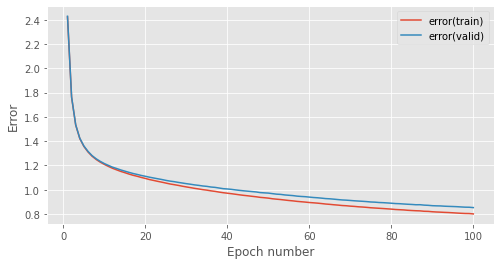

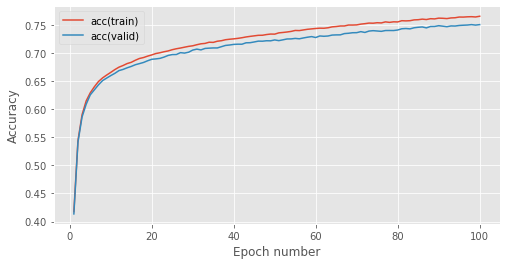

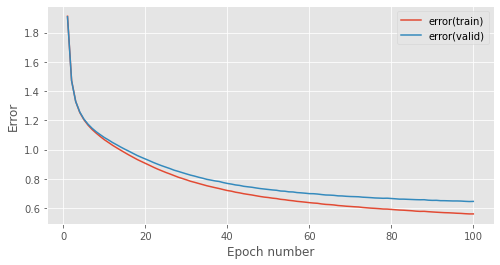

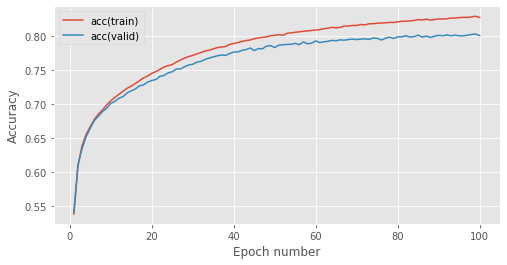

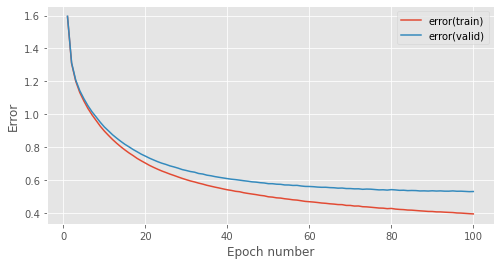

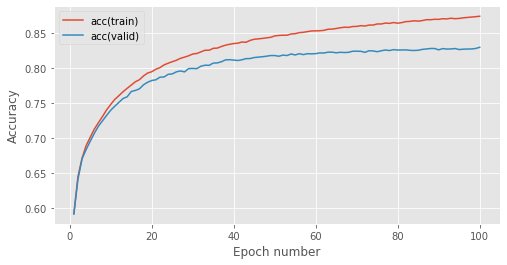

In [78]:
dims = [32, 64, 128]
input_dim, output_dim = 784, 47

error = CrossEntropySoftmaxError()
# Use a Adam learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

for hidden_dim in dims:
    print("Dimension: " + str(hidden_dim))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), # first hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init) # output layer
    ])
    # Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    
    record_all(stats, keys, hidden_dim, fig_1, fig_2, "wd/1layer-" + str(hidden_dim) + "units")

## 2 Hidden layers

Dimension: 32


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 0.6s to complete
    error(train)=2.34e+00, acc(train)=3.92e-01, error(valid)=2.34e+00, acc(valid)=3.89e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 0.6s to complete
    error(train)=1.75e+00, acc(train)=5.28e-01, error(valid)=1.75e+00, acc(valid)=5.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 0.6s to complete
    error(train)=1.56e+00, acc(train)=5.73e-01, error(valid)=1.56e+00, acc(valid)=5.73e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 0.6s to complete
    error(train)=1.46e+00, acc(train)=5.98e-01, error(valid)=1.46e+00, acc(valid)=5.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 0.6s to complete
    error(train)=1.39e+00, acc(train)=6.12e-01, error(valid)=1.39e+00, acc(valid)=6.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 0.6s to complete
    error(train)=1.34e+00, acc(train)=6.26e-01, error(valid)=1.34e+00, acc(valid)=6.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 0.6s to complete
    error(train)=1.30e+00, acc(train)=6.36e-01, error(valid)=1.30e+00, acc(valid)=6.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 0.6s to complete
    error(train)=1.27e+00, acc(train)=6.44e-01, error(valid)=1.27e+00, acc(valid)=6.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 0.6s to complete
    error(train)=1.24e+00, acc(train)=6.52e-01, error(valid)=1.25e+00, acc(valid)=6.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 0.6s to complete
    error(train)=1.22e+00, acc(train)=6.58e-01, error(valid)=1.22e+00, acc(valid)=6.53e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 0.6s to complete
    error(train)=1.20e+00, acc(train)=6.63e-01, error(valid)=1.21e+00, acc(valid)=6.58e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 0.7s to complete
    error(train)=1.18e+00, acc(train)=6.68e-01, error(valid)=1.19e+00, acc(valid)=6.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 0.6s to complete
    error(train)=1.16e+00, acc(train)=6.72e-01, error(valid)=1.17e+00, acc(valid)=6.65e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 0.6s to complete
    error(train)=1.14e+00, acc(train)=6.75e-01, error(valid)=1.16e+00, acc(valid)=6.70e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 0.6s to complete
    error(train)=1.13e+00, acc(train)=6.80e-01, error(valid)=1.14e+00, acc(valid)=6.76e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 0.7s to complete
    error(train)=1.11e+00, acc(train)=6.84e-01, error(valid)=1.13e+00, acc(valid)=6.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 0.6s to complete
    error(train)=1.10e+00, acc(train)=6.87e-01, error(valid)=1.12e+00, acc(valid)=6.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 0.6s to complete
    error(train)=1.09e+00, acc(train)=6.91e-01, error(valid)=1.11e+00, acc(valid)=6.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 0.6s to complete
    error(train)=1.08e+00, acc(train)=6.95e-01, error(valid)=1.09e+00, acc(valid)=6.89e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 0.7s to complete
    error(train)=1.07e+00, acc(train)=6.96e-01, error(valid)=1.09e+00, acc(valid)=6.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 0.6s to complete
    error(train)=1.05e+00, acc(train)=7.01e-01, error(valid)=1.07e+00, acc(valid)=6.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 0.6s to complete
    error(train)=1.04e+00, acc(train)=7.03e-01, error(valid)=1.06e+00, acc(valid)=6.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 0.6s to complete
    error(train)=1.03e+00, acc(train)=7.06e-01, error(valid)=1.05e+00, acc(valid)=6.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 0.6s to complete
    error(train)=1.02e+00, acc(train)=7.10e-01, error(valid)=1.04e+00, acc(valid)=7.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 0.6s to complete
    error(train)=1.01e+00, acc(train)=7.11e-01, error(valid)=1.03e+00, acc(valid)=7.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 0.6s to complete
    error(train)=1.00e+00, acc(train)=7.14e-01, error(valid)=1.03e+00, acc(valid)=7.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 0.6s to complete
    error(train)=9.92e-01, acc(train)=7.16e-01, error(valid)=1.02e+00, acc(valid)=7.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 0.6s to complete
    error(train)=9.84e-01, acc(train)=7.18e-01, error(valid)=1.01e+00, acc(valid)=7.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 0.7s to complete
    error(train)=9.74e-01, acc(train)=7.21e-01, error(valid)=1.00e+00, acc(valid)=7.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 0.6s to complete
    error(train)=9.65e-01, acc(train)=7.23e-01, error(valid)=9.93e-01, acc(valid)=7.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 0.6s to complete
    error(train)=9.58e-01, acc(train)=7.25e-01, error(valid)=9.87e-01, acc(valid)=7.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 0.6s to complete
    error(train)=9.52e-01, acc(train)=7.26e-01, error(valid)=9.79e-01, acc(valid)=7.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 0.6s to complete
    error(train)=9.42e-01, acc(train)=7.28e-01, error(valid)=9.71e-01, acc(valid)=7.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 0.6s to complete
    error(train)=9.34e-01, acc(train)=7.31e-01, error(valid)=9.65e-01, acc(valid)=7.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 0.6s to complete
    error(train)=9.28e-01, acc(train)=7.34e-01, error(valid)=9.58e-01, acc(valid)=7.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 0.7s to complete
    error(train)=9.20e-01, acc(train)=7.34e-01, error(valid)=9.52e-01, acc(valid)=7.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 0.6s to complete
    error(train)=9.13e-01, acc(train)=7.37e-01, error(valid)=9.45e-01, acc(valid)=7.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 0.6s to complete
    error(train)=9.09e-01, acc(train)=7.38e-01, error(valid)=9.41e-01, acc(valid)=7.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 0.6s to complete
    error(train)=9.01e-01, acc(train)=7.39e-01, error(valid)=9.35e-01, acc(valid)=7.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 0.6s to complete
    error(train)=8.94e-01, acc(train)=7.41e-01, error(valid)=9.28e-01, acc(valid)=7.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 0.6s to complete
    error(train)=8.90e-01, acc(train)=7.42e-01, error(valid)=9.24e-01, acc(valid)=7.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 0.6s to complete
    error(train)=8.83e-01, acc(train)=7.45e-01, error(valid)=9.18e-01, acc(valid)=7.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 0.7s to complete
    error(train)=8.78e-01, acc(train)=7.45e-01, error(valid)=9.12e-01, acc(valid)=7.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 0.6s to complete
    error(train)=8.71e-01, acc(train)=7.47e-01, error(valid)=9.07e-01, acc(valid)=7.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 0.6s to complete
    error(train)=8.65e-01, acc(train)=7.49e-01, error(valid)=9.01e-01, acc(valid)=7.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 0.6s to complete
    error(train)=8.61e-01, acc(train)=7.49e-01, error(valid)=8.98e-01, acc(valid)=7.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 0.6s to complete
    error(train)=8.56e-01, acc(train)=7.51e-01, error(valid)=8.93e-01, acc(valid)=7.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 0.6s to complete
    error(train)=8.50e-01, acc(train)=7.52e-01, error(valid)=8.88e-01, acc(valid)=7.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 0.6s to complete
    error(train)=8.44e-01, acc(train)=7.54e-01, error(valid)=8.82e-01, acc(valid)=7.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 0.7s to complete
    error(train)=8.39e-01, acc(train)=7.55e-01, error(valid)=8.77e-01, acc(valid)=7.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 0.6s to complete
    error(train)=8.36e-01, acc(train)=7.56e-01, error(valid)=8.74e-01, acc(valid)=7.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 0.6s to complete
    error(train)=8.31e-01, acc(train)=7.57e-01, error(valid)=8.70e-01, acc(valid)=7.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 0.7s to complete
    error(train)=8.25e-01, acc(train)=7.59e-01, error(valid)=8.63e-01, acc(valid)=7.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 0.6s to complete
    error(train)=8.21e-01, acc(train)=7.60e-01, error(valid)=8.60e-01, acc(valid)=7.51e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 0.6s to complete
    error(train)=8.18e-01, acc(train)=7.60e-01, error(valid)=8.58e-01, acc(valid)=7.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 0.7s to complete
    error(train)=8.13e-01, acc(train)=7.61e-01, error(valid)=8.54e-01, acc(valid)=7.51e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 0.6s to complete
    error(train)=8.08e-01, acc(train)=7.64e-01, error(valid)=8.48e-01, acc(valid)=7.54e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 0.6s to complete
    error(train)=8.03e-01, acc(train)=7.65e-01, error(valid)=8.45e-01, acc(valid)=7.55e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 0.6s to complete
    error(train)=8.01e-01, acc(train)=7.65e-01, error(valid)=8.42e-01, acc(valid)=7.54e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 0.6s to complete
    error(train)=7.96e-01, acc(train)=7.67e-01, error(valid)=8.37e-01, acc(valid)=7.58e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 0.6s to complete
    error(train)=7.93e-01, acc(train)=7.66e-01, error(valid)=8.36e-01, acc(valid)=7.55e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 0.7s to complete
    error(train)=7.88e-01, acc(train)=7.69e-01, error(valid)=8.31e-01, acc(valid)=7.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 0.6s to complete
    error(train)=7.86e-01, acc(train)=7.69e-01, error(valid)=8.29e-01, acc(valid)=7.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 0.7s to complete
    error(train)=7.82e-01, acc(train)=7.70e-01, error(valid)=8.26e-01, acc(valid)=7.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 0.7s to complete
    error(train)=7.79e-01, acc(train)=7.70e-01, error(valid)=8.24e-01, acc(valid)=7.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 0.6s to complete
    error(train)=7.75e-01, acc(train)=7.72e-01, error(valid)=8.19e-01, acc(valid)=7.61e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 0.6s to complete
    error(train)=7.72e-01, acc(train)=7.72e-01, error(valid)=8.18e-01, acc(valid)=7.60e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 0.6s to complete
    error(train)=7.69e-01, acc(train)=7.74e-01, error(valid)=8.13e-01, acc(valid)=7.60e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 0.6s to complete
    error(train)=7.65e-01, acc(train)=7.74e-01, error(valid)=8.11e-01, acc(valid)=7.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 0.6s to complete
    error(train)=7.63e-01, acc(train)=7.74e-01, error(valid)=8.09e-01, acc(valid)=7.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 0.6s to complete
    error(train)=7.61e-01, acc(train)=7.75e-01, error(valid)=8.07e-01, acc(valid)=7.64e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 0.6s to complete
    error(train)=7.56e-01, acc(train)=7.77e-01, error(valid)=8.04e-01, acc(valid)=7.63e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 0.6s to complete
    error(train)=7.57e-01, acc(train)=7.75e-01, error(valid)=8.04e-01, acc(valid)=7.64e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 0.6s to complete
    error(train)=7.53e-01, acc(train)=7.77e-01, error(valid)=8.00e-01, acc(valid)=7.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 0.7s to complete
    error(train)=7.49e-01, acc(train)=7.79e-01, error(valid)=7.98e-01, acc(valid)=7.65e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 0.6s to complete
    error(train)=7.47e-01, acc(train)=7.79e-01, error(valid)=7.96e-01, acc(valid)=7.65e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 0.6s to complete
    error(train)=7.44e-01, acc(train)=7.79e-01, error(valid)=7.93e-01, acc(valid)=7.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 0.6s to complete
    error(train)=7.41e-01, acc(train)=7.79e-01, error(valid)=7.91e-01, acc(valid)=7.67e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 0.6s to complete
    error(train)=7.39e-01, acc(train)=7.81e-01, error(valid)=7.90e-01, acc(valid)=7.68e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 0.6s to complete
    error(train)=7.37e-01, acc(train)=7.81e-01, error(valid)=7.87e-01, acc(valid)=7.68e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 0.6s to complete
    error(train)=7.34e-01, acc(train)=7.82e-01, error(valid)=7.86e-01, acc(valid)=7.70e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 0.6s to complete
    error(train)=7.30e-01, acc(train)=7.82e-01, error(valid)=7.82e-01, acc(valid)=7.70e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 0.6s to complete
    error(train)=7.29e-01, acc(train)=7.83e-01, error(valid)=7.80e-01, acc(valid)=7.70e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 0.6s to complete
    error(train)=7.28e-01, acc(train)=7.82e-01, error(valid)=7.80e-01, acc(valid)=7.70e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 0.6s to complete
    error(train)=7.26e-01, acc(train)=7.83e-01, error(valid)=7.79e-01, acc(valid)=7.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 0.6s to complete
    error(train)=7.22e-01, acc(train)=7.85e-01, error(valid)=7.75e-01, acc(valid)=7.72e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 0.7s to complete
    error(train)=7.24e-01, acc(train)=7.84e-01, error(valid)=7.78e-01, acc(valid)=7.70e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 0.6s to complete
    error(train)=7.19e-01, acc(train)=7.85e-01, error(valid)=7.73e-01, acc(valid)=7.73e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 0.6s to complete
    error(train)=7.19e-01, acc(train)=7.85e-01, error(valid)=7.74e-01, acc(valid)=7.73e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 0.6s to complete
    error(train)=7.16e-01, acc(train)=7.86e-01, error(valid)=7.71e-01, acc(valid)=7.72e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 0.7s to complete
    error(train)=7.14e-01, acc(train)=7.86e-01, error(valid)=7.68e-01, acc(valid)=7.74e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 0.6s to complete
    error(train)=7.11e-01, acc(train)=7.87e-01, error(valid)=7.65e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 0.6s to complete
    error(train)=7.10e-01, acc(train)=7.87e-01, error(valid)=7.66e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 0.6s to complete
    error(train)=7.10e-01, acc(train)=7.87e-01, error(valid)=7.67e-01, acc(valid)=7.72e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 0.6s to complete
    error(train)=7.06e-01, acc(train)=7.88e-01, error(valid)=7.63e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 0.6s to complete
    error(train)=7.06e-01, acc(train)=7.89e-01, error(valid)=7.61e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 0.6s to complete
    error(train)=7.05e-01, acc(train)=7.88e-01, error(valid)=7.62e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 0.6s to complete
    error(train)=7.02e-01, acc(train)=7.89e-01, error(valid)=7.59e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 0.6s to complete
    error(train)=6.99e-01, acc(train)=7.90e-01, error(valid)=7.56e-01, acc(valid)=7.76e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 0.6s to complete
    error(train)=6.98e-01, acc(train)=7.90e-01, error(valid)=7.56e-01, acc(valid)=7.77e-01


Finished model accuracy
Train acc: 0.789559999999998
Val acc: 0.7766455696202534

Finished model error
Train err: 0.6983847387627604
Val err: 0.7563161244862485

Dimension: 64


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 0.9s to complete
    error(train)=1.78e+00, acc(train)=5.39e-01, error(valid)=1.78e+00, acc(valid)=5.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 0.9s to complete
    error(train)=1.40e+00, acc(train)=6.19e-01, error(valid)=1.41e+00, acc(valid)=6.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 0.9s to complete
    error(train)=1.27e+00, acc(train)=6.49e-01, error(valid)=1.28e+00, acc(valid)=6.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 0.9s to complete
    error(train)=1.19e+00, acc(train)=6.69e-01, error(valid)=1.20e+00, acc(valid)=6.61e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 1.0s to complete
    error(train)=1.14e+00, acc(train)=6.83e-01, error(valid)=1.15e+00, acc(valid)=6.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 0.9s to complete
    error(train)=1.09e+00, acc(train)=6.93e-01, error(valid)=1.10e+00, acc(valid)=6.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 0.9s to complete
    error(train)=1.05e+00, acc(train)=7.03e-01, error(valid)=1.07e+00, acc(valid)=6.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 0.9s to complete
    error(train)=1.01e+00, acc(train)=7.13e-01, error(valid)=1.03e+00, acc(valid)=7.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 0.9s to complete
    error(train)=9.73e-01, acc(train)=7.23e-01, error(valid)=9.92e-01, acc(valid)=7.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 0.9s to complete
    error(train)=9.45e-01, acc(train)=7.30e-01, error(valid)=9.64e-01, acc(valid)=7.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 0.9s to complete
    error(train)=9.15e-01, acc(train)=7.38e-01, error(valid)=9.36e-01, acc(valid)=7.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 0.9s to complete
    error(train)=8.90e-01, acc(train)=7.44e-01, error(valid)=9.12e-01, acc(valid)=7.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 0.9s to complete
    error(train)=8.67e-01, acc(train)=7.50e-01, error(valid)=8.91e-01, acc(valid)=7.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 0.9s to complete
    error(train)=8.48e-01, acc(train)=7.55e-01, error(valid)=8.72e-01, acc(valid)=7.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 0.9s to complete
    error(train)=8.28e-01, acc(train)=7.59e-01, error(valid)=8.54e-01, acc(valid)=7.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 1.0s to complete
    error(train)=8.13e-01, acc(train)=7.63e-01, error(valid)=8.40e-01, acc(valid)=7.53e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 0.9s to complete
    error(train)=7.97e-01, acc(train)=7.67e-01, error(valid)=8.24e-01, acc(valid)=7.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 0.9s to complete
    error(train)=7.83e-01, acc(train)=7.69e-01, error(valid)=8.12e-01, acc(valid)=7.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 0.9s to complete
    error(train)=7.72e-01, acc(train)=7.73e-01, error(valid)=8.02e-01, acc(valid)=7.63e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 0.9s to complete
    error(train)=7.57e-01, acc(train)=7.78e-01, error(valid)=7.87e-01, acc(valid)=7.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 0.9s to complete
    error(train)=7.45e-01, acc(train)=7.80e-01, error(valid)=7.76e-01, acc(valid)=7.68e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 0.9s to complete
    error(train)=7.34e-01, acc(train)=7.82e-01, error(valid)=7.66e-01, acc(valid)=7.70e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 0.9s to complete
    error(train)=7.22e-01, acc(train)=7.86e-01, error(valid)=7.55e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 0.9s to complete
    error(train)=7.15e-01, acc(train)=7.85e-01, error(valid)=7.48e-01, acc(valid)=7.74e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 0.9s to complete
    error(train)=7.05e-01, acc(train)=7.90e-01, error(valid)=7.39e-01, acc(valid)=7.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 0.9s to complete
    error(train)=6.95e-01, acc(train)=7.92e-01, error(valid)=7.31e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 0.9s to complete
    error(train)=6.85e-01, acc(train)=7.95e-01, error(valid)=7.21e-01, acc(valid)=7.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 0.9s to complete
    error(train)=6.77e-01, acc(train)=7.97e-01, error(valid)=7.15e-01, acc(valid)=7.85e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 0.9s to complete
    error(train)=6.72e-01, acc(train)=7.98e-01, error(valid)=7.12e-01, acc(valid)=7.85e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 0.9s to complete
    error(train)=6.64e-01, acc(train)=8.01e-01, error(valid)=7.03e-01, acc(valid)=7.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 0.9s to complete
    error(train)=6.56e-01, acc(train)=8.02e-01, error(valid)=6.96e-01, acc(valid)=7.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 0.9s to complete
    error(train)=6.50e-01, acc(train)=8.04e-01, error(valid)=6.90e-01, acc(valid)=7.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 0.9s to complete
    error(train)=6.43e-01, acc(train)=8.05e-01, error(valid)=6.85e-01, acc(valid)=7.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 0.9s to complete
    error(train)=6.37e-01, acc(train)=8.08e-01, error(valid)=6.80e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 0.9s to complete
    error(train)=6.30e-01, acc(train)=8.08e-01, error(valid)=6.73e-01, acc(valid)=7.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 0.9s to complete
    error(train)=6.27e-01, acc(train)=8.09e-01, error(valid)=6.72e-01, acc(valid)=7.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 0.9s to complete
    error(train)=6.23e-01, acc(train)=8.09e-01, error(valid)=6.69e-01, acc(valid)=7.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 0.9s to complete
    error(train)=6.14e-01, acc(train)=8.13e-01, error(valid)=6.60e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 0.9s to complete
    error(train)=6.11e-01, acc(train)=8.13e-01, error(valid)=6.58e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 0.9s to complete
    error(train)=6.06e-01, acc(train)=8.15e-01, error(valid)=6.54e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 0.9s to complete
    error(train)=5.99e-01, acc(train)=8.16e-01, error(valid)=6.49e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 0.9s to complete
    error(train)=5.95e-01, acc(train)=8.16e-01, error(valid)=6.46e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 0.9s to complete
    error(train)=5.93e-01, acc(train)=8.17e-01, error(valid)=6.46e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 0.9s to complete
    error(train)=5.86e-01, acc(train)=8.20e-01, error(valid)=6.39e-01, acc(valid)=8.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 0.9s to complete
    error(train)=5.82e-01, acc(train)=8.20e-01, error(valid)=6.36e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 0.9s to complete
    error(train)=5.80e-01, acc(train)=8.20e-01, error(valid)=6.35e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 0.9s to complete
    error(train)=5.75e-01, acc(train)=8.22e-01, error(valid)=6.30e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 0.9s to complete
    error(train)=5.72e-01, acc(train)=8.22e-01, error(valid)=6.29e-01, acc(valid)=8.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 0.9s to complete
    error(train)=5.69e-01, acc(train)=8.23e-01, error(valid)=6.27e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 0.9s to complete
    error(train)=5.66e-01, acc(train)=8.24e-01, error(valid)=6.24e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 0.9s to complete
    error(train)=5.60e-01, acc(train)=8.26e-01, error(valid)=6.21e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 0.9s to complete
    error(train)=5.60e-01, acc(train)=8.26e-01, error(valid)=6.22e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 0.9s to complete
    error(train)=5.57e-01, acc(train)=8.25e-01, error(valid)=6.19e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 0.9s to complete
    error(train)=5.53e-01, acc(train)=8.27e-01, error(valid)=6.16e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 0.9s to complete
    error(train)=5.51e-01, acc(train)=8.26e-01, error(valid)=6.16e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 0.9s to complete
    error(train)=5.45e-01, acc(train)=8.30e-01, error(valid)=6.11e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 1.1s to complete
    error(train)=5.43e-01, acc(train)=8.31e-01, error(valid)=6.09e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 0.9s to complete
    error(train)=5.42e-01, acc(train)=8.31e-01, error(valid)=6.09e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 0.9s to complete
    error(train)=5.40e-01, acc(train)=8.31e-01, error(valid)=6.09e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 1.0s to complete
    error(train)=5.35e-01, acc(train)=8.33e-01, error(valid)=6.05e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 0.9s to complete
    error(train)=5.31e-01, acc(train)=8.34e-01, error(valid)=6.02e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 0.9s to complete
    error(train)=5.30e-01, acc(train)=8.34e-01, error(valid)=6.01e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 0.9s to complete
    error(train)=5.27e-01, acc(train)=8.35e-01, error(valid)=6.00e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 0.9s to complete
    error(train)=5.26e-01, acc(train)=8.35e-01, error(valid)=5.99e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 0.9s to complete
    error(train)=5.23e-01, acc(train)=8.35e-01, error(valid)=5.98e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 0.9s to complete
    error(train)=5.19e-01, acc(train)=8.36e-01, error(valid)=5.94e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 0.9s to complete
    error(train)=5.18e-01, acc(train)=8.37e-01, error(valid)=5.94e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 0.9s to complete
    error(train)=5.16e-01, acc(train)=8.36e-01, error(valid)=5.93e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 0.9s to complete
    error(train)=5.17e-01, acc(train)=8.36e-01, error(valid)=5.94e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 0.9s to complete
    error(train)=5.12e-01, acc(train)=8.38e-01, error(valid)=5.90e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 0.9s to complete
    error(train)=5.10e-01, acc(train)=8.38e-01, error(valid)=5.92e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 0.9s to complete
    error(train)=5.05e-01, acc(train)=8.39e-01, error(valid)=5.87e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 0.9s to complete
    error(train)=5.05e-01, acc(train)=8.39e-01, error(valid)=5.87e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 0.9s to complete
    error(train)=5.02e-01, acc(train)=8.41e-01, error(valid)=5.85e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 0.9s to complete
    error(train)=5.02e-01, acc(train)=8.41e-01, error(valid)=5.87e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 0.9s to complete
    error(train)=4.99e-01, acc(train)=8.41e-01, error(valid)=5.84e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 0.9s to complete
    error(train)=4.99e-01, acc(train)=8.41e-01, error(valid)=5.85e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 0.9s to complete
    error(train)=4.97e-01, acc(train)=8.42e-01, error(valid)=5.83e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 0.9s to complete
    error(train)=4.95e-01, acc(train)=8.42e-01, error(valid)=5.82e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 0.9s to complete
    error(train)=4.93e-01, acc(train)=8.43e-01, error(valid)=5.82e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 0.9s to complete
    error(train)=4.91e-01, acc(train)=8.43e-01, error(valid)=5.80e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 1.0s to complete
    error(train)=4.89e-01, acc(train)=8.44e-01, error(valid)=5.78e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 0.9s to complete
    error(train)=4.88e-01, acc(train)=8.43e-01, error(valid)=5.79e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 0.9s to complete
    error(train)=4.87e-01, acc(train)=8.44e-01, error(valid)=5.79e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 0.9s to complete
    error(train)=4.86e-01, acc(train)=8.44e-01, error(valid)=5.78e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 0.9s to complete
    error(train)=4.83e-01, acc(train)=8.45e-01, error(valid)=5.77e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 0.9s to complete
    error(train)=4.80e-01, acc(train)=8.45e-01, error(valid)=5.74e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 0.9s to complete
    error(train)=4.79e-01, acc(train)=8.46e-01, error(valid)=5.74e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 0.9s to complete
    error(train)=4.77e-01, acc(train)=8.46e-01, error(valid)=5.74e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 0.9s to complete
    error(train)=4.78e-01, acc(train)=8.47e-01, error(valid)=5.76e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 0.9s to complete
    error(train)=4.75e-01, acc(train)=8.47e-01, error(valid)=5.71e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 0.9s to complete
    error(train)=4.74e-01, acc(train)=8.47e-01, error(valid)=5.74e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 0.9s to complete
    error(train)=4.72e-01, acc(train)=8.48e-01, error(valid)=5.72e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 0.9s to complete
    error(train)=4.72e-01, acc(train)=8.48e-01, error(valid)=5.72e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 0.9s to complete
    error(train)=4.68e-01, acc(train)=8.49e-01, error(valid)=5.69e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 0.9s to complete
    error(train)=4.68e-01, acc(train)=8.48e-01, error(valid)=5.71e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 0.9s to complete
    error(train)=4.68e-01, acc(train)=8.48e-01, error(valid)=5.71e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 1.0s to complete
    error(train)=4.64e-01, acc(train)=8.50e-01, error(valid)=5.68e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 0.9s to complete
    error(train)=4.63e-01, acc(train)=8.50e-01, error(valid)=5.67e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 0.9s to complete
    error(train)=4.62e-01, acc(train)=8.51e-01, error(valid)=5.67e-01, acc(valid)=8.22e-01


Finished model accuracy
Train acc: 0.8505700000000015
Val acc: 0.8220886075949361

Finished model error
Train err: 0.4618233977375566
Val err: 0.56655315577991

Dimension: 128


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 1.4s to complete
    error(train)=1.38e+00, acc(train)=6.22e-01, error(valid)=1.39e+00, acc(valid)=6.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 1.4s to complete
    error(train)=1.16e+00, acc(train)=6.75e-01, error(valid)=1.16e+00, acc(valid)=6.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 1.4s to complete
    error(train)=1.04e+00, acc(train)=7.05e-01, error(valid)=1.05e+00, acc(valid)=7.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 1.4s to complete
    error(train)=9.65e-01, acc(train)=7.25e-01, error(valid)=9.80e-01, acc(valid)=7.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 1.4s to complete
    error(train)=8.96e-01, acc(train)=7.42e-01, error(valid)=9.14e-01, acc(valid)=7.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 1.5s to complete
    error(train)=8.48e-01, acc(train)=7.52e-01, error(valid)=8.68e-01, acc(valid)=7.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 1.4s to complete
    error(train)=8.00e-01, acc(train)=7.66e-01, error(valid)=8.23e-01, acc(valid)=7.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 1.4s to complete
    error(train)=7.64e-01, acc(train)=7.75e-01, error(valid)=7.90e-01, acc(valid)=7.67e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 1.4s to complete
    error(train)=7.34e-01, acc(train)=7.83e-01, error(valid)=7.63e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 1.4s to complete
    error(train)=7.07e-01, acc(train)=7.89e-01, error(valid)=7.37e-01, acc(valid)=7.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 1.4s to complete
    error(train)=6.82e-01, acc(train)=7.95e-01, error(valid)=7.15e-01, acc(valid)=7.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 1.4s to complete
    error(train)=6.65e-01, acc(train)=8.00e-01, error(valid)=7.01e-01, acc(valid)=7.89e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 1.4s to complete
    error(train)=6.45e-01, acc(train)=8.05e-01, error(valid)=6.83e-01, acc(valid)=7.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 1.4s to complete
    error(train)=6.29e-01, acc(train)=8.10e-01, error(valid)=6.72e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 1.4s to complete
    error(train)=6.12e-01, acc(train)=8.14e-01, error(valid)=6.55e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 1.4s to complete
    error(train)=5.97e-01, acc(train)=8.19e-01, error(valid)=6.43e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 1.4s to complete
    error(train)=5.85e-01, acc(train)=8.21e-01, error(valid)=6.33e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 1.4s to complete
    error(train)=5.73e-01, acc(train)=8.24e-01, error(valid)=6.24e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 1.4s to complete
    error(train)=5.62e-01, acc(train)=8.27e-01, error(valid)=6.16e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 1.5s to complete
    error(train)=5.53e-01, acc(train)=8.29e-01, error(valid)=6.08e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 1.4s to complete
    error(train)=5.45e-01, acc(train)=8.31e-01, error(valid)=6.04e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 1.4s to complete
    error(train)=5.36e-01, acc(train)=8.33e-01, error(valid)=5.98e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 1.4s to complete
    error(train)=5.27e-01, acc(train)=8.35e-01, error(valid)=5.92e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 1.5s to complete
    error(train)=5.22e-01, acc(train)=8.35e-01, error(valid)=5.88e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 1.5s to complete
    error(train)=5.14e-01, acc(train)=8.39e-01, error(valid)=5.83e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 1.4s to complete
    error(train)=5.05e-01, acc(train)=8.42e-01, error(valid)=5.75e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 1.4s to complete
    error(train)=4.99e-01, acc(train)=8.42e-01, error(valid)=5.70e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 1.5s to complete
    error(train)=4.90e-01, acc(train)=8.45e-01, error(valid)=5.66e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 1.4s to complete
    error(train)=4.84e-01, acc(train)=8.47e-01, error(valid)=5.62e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 1.4s to complete
    error(train)=4.81e-01, acc(train)=8.47e-01, error(valid)=5.60e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 1.5s to complete
    error(train)=4.78e-01, acc(train)=8.47e-01, error(valid)=5.60e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 1.4s to complete
    error(train)=4.69e-01, acc(train)=8.50e-01, error(valid)=5.53e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 1.5s to complete
    error(train)=4.64e-01, acc(train)=8.52e-01, error(valid)=5.49e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 1.4s to complete
    error(train)=4.60e-01, acc(train)=8.52e-01, error(valid)=5.48e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 1.4s to complete
    error(train)=4.52e-01, acc(train)=8.56e-01, error(valid)=5.43e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 1.4s to complete
    error(train)=4.50e-01, acc(train)=8.55e-01, error(valid)=5.41e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 1.4s to complete
    error(train)=4.46e-01, acc(train)=8.57e-01, error(valid)=5.39e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 1.4s to complete
    error(train)=4.42e-01, acc(train)=8.58e-01, error(valid)=5.40e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 1.4s to complete
    error(train)=4.38e-01, acc(train)=8.59e-01, error(valid)=5.37e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 1.5s to complete
    error(train)=4.31e-01, acc(train)=8.59e-01, error(valid)=5.32e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 1.4s to complete
    error(train)=4.29e-01, acc(train)=8.61e-01, error(valid)=5.34e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 1.4s to complete
    error(train)=4.26e-01, acc(train)=8.61e-01, error(valid)=5.31e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 1.4s to complete
    error(train)=4.23e-01, acc(train)=8.63e-01, error(valid)=5.32e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 1.5s to complete
    error(train)=4.15e-01, acc(train)=8.65e-01, error(valid)=5.26e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 1.4s to complete
    error(train)=4.15e-01, acc(train)=8.66e-01, error(valid)=5.25e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 1.4s to complete
    error(train)=4.09e-01, acc(train)=8.67e-01, error(valid)=5.23e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 1.4s to complete
    error(train)=4.07e-01, acc(train)=8.68e-01, error(valid)=5.22e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 1.5s to complete
    error(train)=4.03e-01, acc(train)=8.68e-01, error(valid)=5.22e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 1.4s to complete
    error(train)=4.01e-01, acc(train)=8.69e-01, error(valid)=5.20e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 1.4s to complete
    error(train)=3.97e-01, acc(train)=8.71e-01, error(valid)=5.18e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 1.4s to complete
    error(train)=3.96e-01, acc(train)=8.71e-01, error(valid)=5.19e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 1.4s to complete
    error(train)=3.91e-01, acc(train)=8.73e-01, error(valid)=5.16e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 1.4s to complete
    error(train)=3.90e-01, acc(train)=8.73e-01, error(valid)=5.16e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 1.4s to complete
    error(train)=3.85e-01, acc(train)=8.74e-01, error(valid)=5.14e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 1.4s to complete
    error(train)=3.88e-01, acc(train)=8.72e-01, error(valid)=5.17e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 1.4s to complete
    error(train)=3.83e-01, acc(train)=8.75e-01, error(valid)=5.14e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 1.4s to complete
    error(train)=3.79e-01, acc(train)=8.75e-01, error(valid)=5.15e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 1.4s to complete
    error(train)=3.77e-01, acc(train)=8.76e-01, error(valid)=5.14e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 1.4s to complete
    error(train)=3.73e-01, acc(train)=8.77e-01, error(valid)=5.11e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 1.4s to complete
    error(train)=3.70e-01, acc(train)=8.78e-01, error(valid)=5.12e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 1.4s to complete
    error(train)=3.68e-01, acc(train)=8.78e-01, error(valid)=5.10e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 1.4s to complete
    error(train)=3.64e-01, acc(train)=8.80e-01, error(valid)=5.07e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 1.4s to complete
    error(train)=3.67e-01, acc(train)=8.78e-01, error(valid)=5.14e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 1.4s to complete
    error(train)=3.62e-01, acc(train)=8.80e-01, error(valid)=5.10e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 1.4s to complete
    error(train)=3.62e-01, acc(train)=8.79e-01, error(valid)=5.11e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 1.4s to complete
    error(train)=3.58e-01, acc(train)=8.82e-01, error(valid)=5.10e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 1.4s to complete
    error(train)=3.53e-01, acc(train)=8.83e-01, error(valid)=5.06e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 1.4s to complete
    error(train)=3.54e-01, acc(train)=8.82e-01, error(valid)=5.09e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 1.4s to complete
    error(train)=3.53e-01, acc(train)=8.82e-01, error(valid)=5.09e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 1.4s to complete
    error(train)=3.51e-01, acc(train)=8.83e-01, error(valid)=5.11e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 1.4s to complete
    error(train)=3.45e-01, acc(train)=8.85e-01, error(valid)=5.07e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 1.4s to complete
    error(train)=3.42e-01, acc(train)=8.86e-01, error(valid)=5.05e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 1.4s to complete
    error(train)=3.41e-01, acc(train)=8.86e-01, error(valid)=5.06e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 1.4s to complete
    error(train)=3.38e-01, acc(train)=8.87e-01, error(valid)=5.06e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 1.4s to complete
    error(train)=3.38e-01, acc(train)=8.87e-01, error(valid)=5.07e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 1.4s to complete
    error(train)=3.35e-01, acc(train)=8.88e-01, error(valid)=5.04e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 1.4s to complete
    error(train)=3.34e-01, acc(train)=8.88e-01, error(valid)=5.07e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 1.4s to complete
    error(train)=3.34e-01, acc(train)=8.88e-01, error(valid)=5.10e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 1.5s to complete
    error(train)=3.31e-01, acc(train)=8.89e-01, error(valid)=5.08e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 1.4s to complete
    error(train)=3.28e-01, acc(train)=8.90e-01, error(valid)=5.05e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 1.4s to complete
    error(train)=3.26e-01, acc(train)=8.91e-01, error(valid)=5.06e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 1.4s to complete
    error(train)=3.24e-01, acc(train)=8.92e-01, error(valid)=5.06e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 1.4s to complete
    error(train)=3.24e-01, acc(train)=8.92e-01, error(valid)=5.08e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 1.4s to complete
    error(train)=3.25e-01, acc(train)=8.91e-01, error(valid)=5.11e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 1.4s to complete
    error(train)=3.19e-01, acc(train)=8.93e-01, error(valid)=5.07e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 1.4s to complete
    error(train)=3.18e-01, acc(train)=8.93e-01, error(valid)=5.07e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 1.4s to complete
    error(train)=3.19e-01, acc(train)=8.92e-01, error(valid)=5.10e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 1.4s to complete
    error(train)=3.13e-01, acc(train)=8.95e-01, error(valid)=5.05e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 1.4s to complete
    error(train)=3.13e-01, acc(train)=8.94e-01, error(valid)=5.06e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 1.4s to complete
    error(train)=3.13e-01, acc(train)=8.94e-01, error(valid)=5.12e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 1.4s to complete
    error(train)=3.12e-01, acc(train)=8.95e-01, error(valid)=5.10e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 1.4s to complete
    error(train)=3.12e-01, acc(train)=8.93e-01, error(valid)=5.13e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 1.4s to complete
    error(train)=3.10e-01, acc(train)=8.94e-01, error(valid)=5.14e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 1.4s to complete
    error(train)=3.05e-01, acc(train)=8.97e-01, error(valid)=5.09e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 1.4s to complete
    error(train)=3.06e-01, acc(train)=8.96e-01, error(valid)=5.14e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 1.4s to complete
    error(train)=3.01e-01, acc(train)=8.98e-01, error(valid)=5.10e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 1.4s to complete
    error(train)=3.00e-01, acc(train)=8.99e-01, error(valid)=5.10e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 1.4s to complete
    error(train)=3.00e-01, acc(train)=8.99e-01, error(valid)=5.12e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 1.4s to complete
    error(train)=2.98e-01, acc(train)=8.99e-01, error(valid)=5.15e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 1.4s to complete
    error(train)=2.97e-01, acc(train)=8.99e-01, error(valid)=5.12e-01, acc(valid)=8.36e-01


Finished model accuracy
Train acc: 0.8992299999999951
Val acc: 0.8363924050632915

Finished model error
Train err: 0.29726490137352457
Val err: 0.5119723158564484



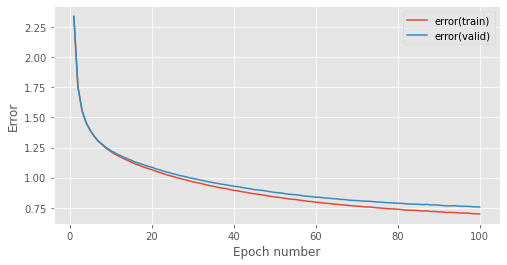

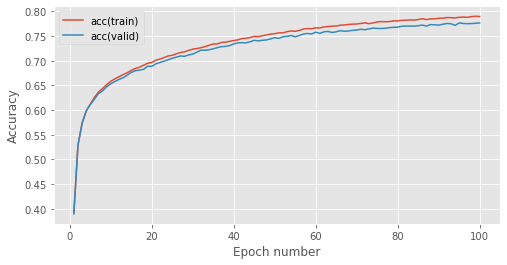

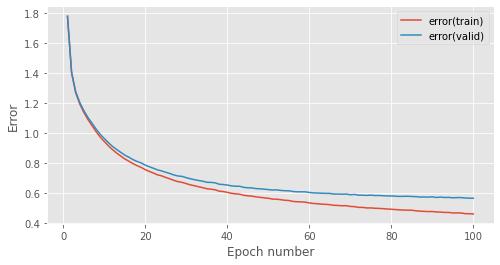

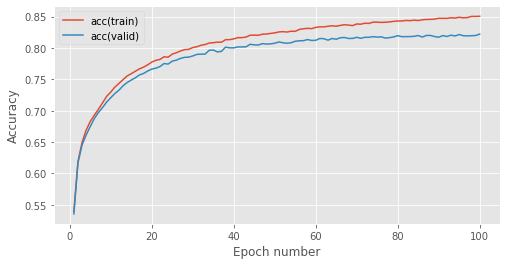

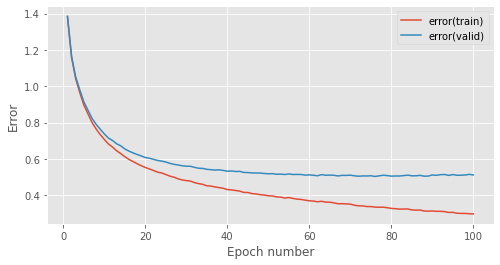

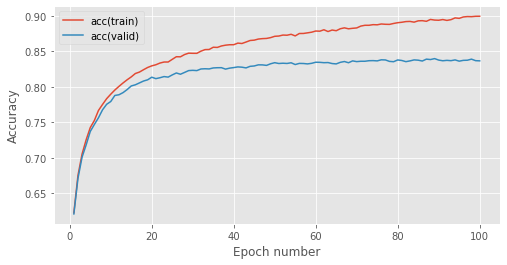

In [80]:
dims = [32, 64, 128]
input_dim, output_dim = 784, 47

error = CrossEntropySoftmaxError()
# Use a Adam learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

for hidden_dim in dims:
    print("Dimension: " + str(hidden_dim))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), # first hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # second hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init) # output layer
    ])
    # Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    
    record_all(stats, keys, hidden_dim, fig_1, fig_2, "wd/2layers-" + str(hidden_dim) + "units")

## 3 Hidden layers

Dimension: 32


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 0.7s to complete
    error(train)=2.36e+00, acc(train)=3.96e-01, error(valid)=2.36e+00, acc(valid)=3.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 0.7s to complete
    error(train)=1.73e+00, acc(train)=5.26e-01, error(valid)=1.73e+00, acc(valid)=5.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 0.7s to complete
    error(train)=1.50e+00, acc(train)=5.83e-01, error(valid)=1.50e+00, acc(valid)=5.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 0.7s to complete
    error(train)=1.37e+00, acc(train)=6.15e-01, error(valid)=1.37e+00, acc(valid)=6.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 0.7s to complete
    error(train)=1.27e+00, acc(train)=6.40e-01, error(valid)=1.28e+00, acc(valid)=6.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 0.7s to complete
    error(train)=1.21e+00, acc(train)=6.55e-01, error(valid)=1.22e+00, acc(valid)=6.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 0.8s to complete
    error(train)=1.15e+00, acc(train)=6.70e-01, error(valid)=1.16e+00, acc(valid)=6.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 0.7s to complete
    error(train)=1.11e+00, acc(train)=6.79e-01, error(valid)=1.12e+00, acc(valid)=6.73e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 0.7s to complete
    error(train)=1.08e+00, acc(train)=6.88e-01, error(valid)=1.09e+00, acc(valid)=6.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 0.7s to complete
    error(train)=1.05e+00, acc(train)=6.97e-01, error(valid)=1.06e+00, acc(valid)=6.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 0.7s to complete
    error(train)=1.02e+00, acc(train)=7.03e-01, error(valid)=1.03e+00, acc(valid)=6.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 0.7s to complete
    error(train)=1.00e+00, acc(train)=7.07e-01, error(valid)=1.02e+00, acc(valid)=7.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 0.7s to complete
    error(train)=9.76e-01, acc(train)=7.14e-01, error(valid)=9.91e-01, acc(valid)=7.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 0.7s to complete
    error(train)=9.58e-01, acc(train)=7.19e-01, error(valid)=9.74e-01, acc(valid)=7.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 0.8s to complete
    error(train)=9.44e-01, acc(train)=7.23e-01, error(valid)=9.59e-01, acc(valid)=7.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 0.8s to complete
    error(train)=9.31e-01, acc(train)=7.27e-01, error(valid)=9.48e-01, acc(valid)=7.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 0.7s to complete
    error(train)=9.16e-01, acc(train)=7.30e-01, error(valid)=9.34e-01, acc(valid)=7.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 0.8s to complete
    error(train)=9.04e-01, acc(train)=7.34e-01, error(valid)=9.23e-01, acc(valid)=7.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 0.7s to complete
    error(train)=8.94e-01, acc(train)=7.36e-01, error(valid)=9.14e-01, acc(valid)=7.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 0.7s to complete
    error(train)=8.82e-01, acc(train)=7.40e-01, error(valid)=9.03e-01, acc(valid)=7.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 0.7s to complete
    error(train)=8.73e-01, acc(train)=7.41e-01, error(valid)=8.95e-01, acc(valid)=7.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 0.7s to complete
    error(train)=8.68e-01, acc(train)=7.42e-01, error(valid)=8.90e-01, acc(valid)=7.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 0.7s to complete
    error(train)=8.57e-01, acc(train)=7.46e-01, error(valid)=8.81e-01, acc(valid)=7.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 0.7s to complete
    error(train)=8.47e-01, acc(train)=7.48e-01, error(valid)=8.71e-01, acc(valid)=7.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 0.8s to complete
    error(train)=8.40e-01, acc(train)=7.50e-01, error(valid)=8.64e-01, acc(valid)=7.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 0.7s to complete
    error(train)=8.32e-01, acc(train)=7.52e-01, error(valid)=8.58e-01, acc(valid)=7.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 0.7s to complete
    error(train)=8.29e-01, acc(train)=7.52e-01, error(valid)=8.54e-01, acc(valid)=7.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 0.7s to complete
    error(train)=8.21e-01, acc(train)=7.55e-01, error(valid)=8.49e-01, acc(valid)=7.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 0.7s to complete
    error(train)=8.14e-01, acc(train)=7.57e-01, error(valid)=8.43e-01, acc(valid)=7.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 0.7s to complete
    error(train)=8.09e-01, acc(train)=7.58e-01, error(valid)=8.37e-01, acc(valid)=7.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 1.0s to complete
    error(train)=8.01e-01, acc(train)=7.61e-01, error(valid)=8.31e-01, acc(valid)=7.50e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 0.8s to complete
    error(train)=7.97e-01, acc(train)=7.61e-01, error(valid)=8.28e-01, acc(valid)=7.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 0.8s to complete
    error(train)=7.91e-01, acc(train)=7.63e-01, error(valid)=8.21e-01, acc(valid)=7.53e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 0.7s to complete
    error(train)=7.86e-01, acc(train)=7.64e-01, error(valid)=8.18e-01, acc(valid)=7.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 0.7s to complete
    error(train)=7.83e-01, acc(train)=7.64e-01, error(valid)=8.15e-01, acc(valid)=7.53e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 0.7s to complete
    error(train)=7.77e-01, acc(train)=7.66e-01, error(valid)=8.10e-01, acc(valid)=7.54e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 0.7s to complete
    error(train)=7.74e-01, acc(train)=7.67e-01, error(valid)=8.08e-01, acc(valid)=7.54e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 0.7s to complete
    error(train)=7.70e-01, acc(train)=7.68e-01, error(valid)=8.04e-01, acc(valid)=7.55e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 0.7s to complete
    error(train)=7.65e-01, acc(train)=7.69e-01, error(valid)=8.00e-01, acc(valid)=7.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 0.8s to complete
    error(train)=7.60e-01, acc(train)=7.71e-01, error(valid)=7.97e-01, acc(valid)=7.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 0.7s to complete
    error(train)=7.59e-01, acc(train)=7.71e-01, error(valid)=7.96e-01, acc(valid)=7.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 0.7s to complete
    error(train)=7.54e-01, acc(train)=7.72e-01, error(valid)=7.91e-01, acc(valid)=7.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 0.8s to complete
    error(train)=7.48e-01, acc(train)=7.74e-01, error(valid)=7.87e-01, acc(valid)=7.61e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 0.8s to complete
    error(train)=7.48e-01, acc(train)=7.73e-01, error(valid)=7.87e-01, acc(valid)=7.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 0.8s to complete
    error(train)=7.43e-01, acc(train)=7.75e-01, error(valid)=7.84e-01, acc(valid)=7.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 0.8s to complete
    error(train)=7.38e-01, acc(train)=7.76e-01, error(valid)=7.78e-01, acc(valid)=7.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 0.8s to complete
    error(train)=7.37e-01, acc(train)=7.76e-01, error(valid)=7.79e-01, acc(valid)=7.61e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 0.8s to complete
    error(train)=7.32e-01, acc(train)=7.77e-01, error(valid)=7.74e-01, acc(valid)=7.64e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 0.8s to complete
    error(train)=7.28e-01, acc(train)=7.78e-01, error(valid)=7.71e-01, acc(valid)=7.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 0.8s to complete
    error(train)=7.26e-01, acc(train)=7.80e-01, error(valid)=7.69e-01, acc(valid)=7.64e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 0.8s to complete
    error(train)=7.25e-01, acc(train)=7.79e-01, error(valid)=7.69e-01, acc(valid)=7.63e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 0.8s to complete
    error(train)=7.19e-01, acc(train)=7.81e-01, error(valid)=7.63e-01, acc(valid)=7.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 0.8s to complete
    error(train)=7.17e-01, acc(train)=7.81e-01, error(valid)=7.62e-01, acc(valid)=7.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 0.8s to complete
    error(train)=7.15e-01, acc(train)=7.82e-01, error(valid)=7.62e-01, acc(valid)=7.69e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 0.8s to complete
    error(train)=7.11e-01, acc(train)=7.82e-01, error(valid)=7.57e-01, acc(valid)=7.70e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 0.8s to complete
    error(train)=7.09e-01, acc(train)=7.83e-01, error(valid)=7.57e-01, acc(valid)=7.69e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 0.8s to complete
    error(train)=7.04e-01, acc(train)=7.85e-01, error(valid)=7.52e-01, acc(valid)=7.72e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 0.8s to complete
    error(train)=7.04e-01, acc(train)=7.86e-01, error(valid)=7.53e-01, acc(valid)=7.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 0.8s to complete
    error(train)=7.01e-01, acc(train)=7.86e-01, error(valid)=7.51e-01, acc(valid)=7.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 0.8s to complete
    error(train)=6.98e-01, acc(train)=7.86e-01, error(valid)=7.48e-01, acc(valid)=7.70e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 0.8s to complete
    error(train)=6.96e-01, acc(train)=7.87e-01, error(valid)=7.46e-01, acc(valid)=7.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 0.8s to complete
    error(train)=6.95e-01, acc(train)=7.86e-01, error(valid)=7.45e-01, acc(valid)=7.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 0.8s to complete
    error(train)=6.92e-01, acc(train)=7.88e-01, error(valid)=7.42e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 0.9s to complete
    error(train)=6.89e-01, acc(train)=7.89e-01, error(valid)=7.41e-01, acc(valid)=7.73e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 0.7s to complete
    error(train)=6.87e-01, acc(train)=7.90e-01, error(valid)=7.40e-01, acc(valid)=7.73e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 0.7s to complete
    error(train)=6.86e-01, acc(train)=7.89e-01, error(valid)=7.40e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 0.7s to complete
    error(train)=6.83e-01, acc(train)=7.90e-01, error(valid)=7.38e-01, acc(valid)=7.73e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 0.7s to complete
    error(train)=6.82e-01, acc(train)=7.91e-01, error(valid)=7.36e-01, acc(valid)=7.74e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 0.8s to complete
    error(train)=6.80e-01, acc(train)=7.92e-01, error(valid)=7.34e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 0.7s to complete
    error(train)=6.79e-01, acc(train)=7.91e-01, error(valid)=7.35e-01, acc(valid)=7.72e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 0.7s to complete
    error(train)=6.77e-01, acc(train)=7.92e-01, error(valid)=7.32e-01, acc(valid)=7.76e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 0.7s to complete
    error(train)=6.74e-01, acc(train)=7.93e-01, error(valid)=7.31e-01, acc(valid)=7.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 0.7s to complete
    error(train)=6.73e-01, acc(train)=7.93e-01, error(valid)=7.30e-01, acc(valid)=7.76e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 0.8s to complete
    error(train)=6.70e-01, acc(train)=7.94e-01, error(valid)=7.27e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 0.7s to complete
    error(train)=6.69e-01, acc(train)=7.94e-01, error(valid)=7.26e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 0.8s to complete
    error(train)=6.72e-01, acc(train)=7.93e-01, error(valid)=7.30e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 0.7s to complete
    error(train)=6.67e-01, acc(train)=7.94e-01, error(valid)=7.27e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 0.7s to complete
    error(train)=6.64e-01, acc(train)=7.95e-01, error(valid)=7.24e-01, acc(valid)=7.76e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 0.7s to complete
    error(train)=6.63e-01, acc(train)=7.96e-01, error(valid)=7.24e-01, acc(valid)=7.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 0.7s to complete
    error(train)=6.61e-01, acc(train)=7.97e-01, error(valid)=7.21e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 0.7s to complete
    error(train)=6.60e-01, acc(train)=7.97e-01, error(valid)=7.21e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 0.7s to complete
    error(train)=6.59e-01, acc(train)=7.96e-01, error(valid)=7.22e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 0.8s to complete
    error(train)=6.57e-01, acc(train)=7.97e-01, error(valid)=7.19e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 0.7s to complete
    error(train)=6.54e-01, acc(train)=7.99e-01, error(valid)=7.17e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 0.7s to complete
    error(train)=6.52e-01, acc(train)=7.99e-01, error(valid)=7.16e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 0.7s to complete
    error(train)=6.53e-01, acc(train)=7.99e-01, error(valid)=7.17e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 0.7s to complete
    error(train)=6.52e-01, acc(train)=7.99e-01, error(valid)=7.17e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 0.7s to complete
    error(train)=6.49e-01, acc(train)=8.00e-01, error(valid)=7.15e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 0.8s to complete
    error(train)=6.49e-01, acc(train)=7.99e-01, error(valid)=7.13e-01, acc(valid)=7.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 0.7s to complete
    error(train)=6.46e-01, acc(train)=8.00e-01, error(valid)=7.12e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 0.7s to complete
    error(train)=6.47e-01, acc(train)=7.99e-01, error(valid)=7.13e-01, acc(valid)=7.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 0.9s to complete
    error(train)=6.43e-01, acc(train)=8.01e-01, error(valid)=7.11e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 0.7s to complete
    error(train)=6.41e-01, acc(train)=8.01e-01, error(valid)=7.10e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 0.7s to complete
    error(train)=6.41e-01, acc(train)=8.02e-01, error(valid)=7.09e-01, acc(valid)=7.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 0.7s to complete
    error(train)=6.43e-01, acc(train)=8.01e-01, error(valid)=7.13e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 0.7s to complete
    error(train)=6.38e-01, acc(train)=8.03e-01, error(valid)=7.09e-01, acc(valid)=7.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 0.7s to complete
    error(train)=6.39e-01, acc(train)=8.03e-01, error(valid)=7.09e-01, acc(valid)=7.85e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 0.7s to complete
    error(train)=6.36e-01, acc(train)=8.04e-01, error(valid)=7.06e-01, acc(valid)=7.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 0.7s to complete
    error(train)=6.33e-01, acc(train)=8.04e-01, error(valid)=7.04e-01, acc(valid)=7.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 0.7s to complete
    error(train)=6.33e-01, acc(train)=8.04e-01, error(valid)=7.04e-01, acc(valid)=7.84e-01


Finished model accuracy
Train acc: 0.8036799999999992
Val acc: 0.7839240506329118

Finished model error
Train err: 0.6331422493626739
Val err: 0.7039552689390018

Dimension: 64


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 1.0s to complete
    error(train)=1.69e+00, acc(train)=5.41e-01, error(valid)=1.69e+00, acc(valid)=5.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 0.9s to complete
    error(train)=1.34e+00, acc(train)=6.27e-01, error(valid)=1.34e+00, acc(valid)=6.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 0.9s to complete
    error(train)=1.19e+00, acc(train)=6.63e-01, error(valid)=1.20e+00, acc(valid)=6.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 1.0s to complete
    error(train)=1.11e+00, acc(train)=6.85e-01, error(valid)=1.12e+00, acc(valid)=6.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 1.0s to complete
    error(train)=1.03e+00, acc(train)=7.04e-01, error(valid)=1.05e+00, acc(valid)=6.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 1.0s to complete
    error(train)=9.84e-01, acc(train)=7.15e-01, error(valid)=9.98e-01, acc(valid)=7.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 1.0s to complete
    error(train)=9.37e-01, acc(train)=7.27e-01, error(valid)=9.52e-01, acc(valid)=7.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 1.0s to complete
    error(train)=9.03e-01, acc(train)=7.37e-01, error(valid)=9.21e-01, acc(valid)=7.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 1.0s to complete
    error(train)=8.70e-01, acc(train)=7.44e-01, error(valid)=8.88e-01, acc(valid)=7.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 1.0s to complete
    error(train)=8.44e-01, acc(train)=7.52e-01, error(valid)=8.65e-01, acc(valid)=7.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 1.0s to complete
    error(train)=8.21e-01, acc(train)=7.58e-01, error(valid)=8.43e-01, acc(valid)=7.50e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 1.0s to complete
    error(train)=7.97e-01, acc(train)=7.64e-01, error(valid)=8.20e-01, acc(valid)=7.58e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 1.1s to complete
    error(train)=7.79e-01, acc(train)=7.68e-01, error(valid)=8.03e-01, acc(valid)=7.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 1.0s to complete
    error(train)=7.62e-01, acc(train)=7.71e-01, error(valid)=7.89e-01, acc(valid)=7.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 1.0s to complete
    error(train)=7.43e-01, acc(train)=7.76e-01, error(valid)=7.73e-01, acc(valid)=7.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 1.0s to complete
    error(train)=7.28e-01, acc(train)=7.80e-01, error(valid)=7.60e-01, acc(valid)=7.70e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 1.0s to complete
    error(train)=7.18e-01, acc(train)=7.84e-01, error(valid)=7.51e-01, acc(valid)=7.74e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 1.0s to complete
    error(train)=7.05e-01, acc(train)=7.86e-01, error(valid)=7.39e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 1.1s to complete
    error(train)=6.93e-01, acc(train)=7.88e-01, error(valid)=7.28e-01, acc(valid)=7.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 1.0s to complete
    error(train)=6.83e-01, acc(train)=7.93e-01, error(valid)=7.20e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 1.0s to complete
    error(train)=6.70e-01, acc(train)=7.96e-01, error(valid)=7.09e-01, acc(valid)=7.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 1.0s to complete
    error(train)=6.66e-01, acc(train)=7.97e-01, error(valid)=7.07e-01, acc(valid)=7.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 1.0s to complete
    error(train)=6.52e-01, acc(train)=8.00e-01, error(valid)=6.94e-01, acc(valid)=7.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 1.0s to complete
    error(train)=6.43e-01, acc(train)=8.03e-01, error(valid)=6.86e-01, acc(valid)=7.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 1.0s to complete
    error(train)=6.35e-01, acc(train)=8.05e-01, error(valid)=6.81e-01, acc(valid)=7.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 1.1s to complete
    error(train)=6.28e-01, acc(train)=8.07e-01, error(valid)=6.75e-01, acc(valid)=7.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 1.1s to complete
    error(train)=6.23e-01, acc(train)=8.07e-01, error(valid)=6.72e-01, acc(valid)=7.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 1.1s to complete
    error(train)=6.15e-01, acc(train)=8.10e-01, error(valid)=6.64e-01, acc(valid)=7.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 1.0s to complete
    error(train)=6.09e-01, acc(train)=8.11e-01, error(valid)=6.61e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 1.0s to complete
    error(train)=6.03e-01, acc(train)=8.12e-01, error(valid)=6.57e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 1.2s to complete
    error(train)=5.97e-01, acc(train)=8.14e-01, error(valid)=6.52e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 1.0s to complete
    error(train)=5.91e-01, acc(train)=8.15e-01, error(valid)=6.48e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 1.0s to complete
    error(train)=5.83e-01, acc(train)=8.18e-01, error(valid)=6.41e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 1.0s to complete
    error(train)=5.80e-01, acc(train)=8.19e-01, error(valid)=6.40e-01, acc(valid)=8.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 1.1s to complete
    error(train)=5.75e-01, acc(train)=8.21e-01, error(valid)=6.36e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 1.0s to complete
    error(train)=5.72e-01, acc(train)=8.20e-01, error(valid)=6.33e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 1.1s to complete
    error(train)=5.69e-01, acc(train)=8.22e-01, error(valid)=6.31e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 1.1s to complete
    error(train)=5.63e-01, acc(train)=8.23e-01, error(valid)=6.25e-01, acc(valid)=8.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 1.1s to complete
    error(train)=5.61e-01, acc(train)=8.24e-01, error(valid)=6.26e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 1.0s to complete
    error(train)=5.56e-01, acc(train)=8.24e-01, error(valid)=6.23e-01, acc(valid)=8.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 1.1s to complete
    error(train)=5.50e-01, acc(train)=8.26e-01, error(valid)=6.17e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 1.1s to complete
    error(train)=5.45e-01, acc(train)=8.28e-01, error(valid)=6.14e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 1.1s to complete
    error(train)=5.42e-01, acc(train)=8.29e-01, error(valid)=6.13e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 1.1s to complete
    error(train)=5.38e-01, acc(train)=8.30e-01, error(valid)=6.09e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 1.1s to complete
    error(train)=5.35e-01, acc(train)=8.31e-01, error(valid)=6.06e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 1.1s to complete
    error(train)=5.31e-01, acc(train)=8.32e-01, error(valid)=6.07e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 1.1s to complete
    error(train)=5.27e-01, acc(train)=8.32e-01, error(valid)=6.02e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 1.1s to complete
    error(train)=5.27e-01, acc(train)=8.32e-01, error(valid)=6.04e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 1.2s to complete
    error(train)=5.27e-01, acc(train)=8.32e-01, error(valid)=6.04e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 1.0s to complete
    error(train)=5.19e-01, acc(train)=8.35e-01, error(valid)=6.01e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 1.1s to complete
    error(train)=5.16e-01, acc(train)=8.36e-01, error(valid)=5.96e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 1.0s to complete
    error(train)=5.14e-01, acc(train)=8.37e-01, error(valid)=5.96e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 1.0s to complete
    error(train)=5.10e-01, acc(train)=8.37e-01, error(valid)=5.93e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 1.1s to complete
    error(train)=5.10e-01, acc(train)=8.38e-01, error(valid)=5.93e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 1.1s to complete
    error(train)=5.06e-01, acc(train)=8.38e-01, error(valid)=5.91e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 1.0s to complete
    error(train)=5.02e-01, acc(train)=8.38e-01, error(valid)=5.87e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 1.1s to complete
    error(train)=5.01e-01, acc(train)=8.40e-01, error(valid)=5.88e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 1.1s to complete
    error(train)=5.00e-01, acc(train)=8.38e-01, error(valid)=5.87e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 1.0s to complete
    error(train)=4.94e-01, acc(train)=8.40e-01, error(valid)=5.84e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 1.1s to complete
    error(train)=4.94e-01, acc(train)=8.39e-01, error(valid)=5.87e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 1.1s to complete
    error(train)=4.91e-01, acc(train)=8.42e-01, error(valid)=5.82e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 1.1s to complete
    error(train)=4.91e-01, acc(train)=8.42e-01, error(valid)=5.85e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 1.0s to complete
    error(train)=4.84e-01, acc(train)=8.44e-01, error(valid)=5.80e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 1.1s to complete
    error(train)=4.83e-01, acc(train)=8.44e-01, error(valid)=5.77e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 1.0s to complete
    error(train)=4.87e-01, acc(train)=8.42e-01, error(valid)=5.85e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 1.0s to complete
    error(train)=4.78e-01, acc(train)=8.45e-01, error(valid)=5.76e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 1.1s to complete
    error(train)=4.79e-01, acc(train)=8.45e-01, error(valid)=5.77e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 1.1s to complete
    error(train)=4.74e-01, acc(train)=8.46e-01, error(valid)=5.73e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 1.2s to complete
    error(train)=4.72e-01, acc(train)=8.47e-01, error(valid)=5.74e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 1.1s to complete
    error(train)=4.71e-01, acc(train)=8.47e-01, error(valid)=5.73e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 1.1s to complete
    error(train)=4.68e-01, acc(train)=8.48e-01, error(valid)=5.71e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 1.1s to complete
    error(train)=4.66e-01, acc(train)=8.48e-01, error(valid)=5.71e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 1.1s to complete
    error(train)=4.68e-01, acc(train)=8.46e-01, error(valid)=5.74e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 1.1s to complete
    error(train)=4.64e-01, acc(train)=8.48e-01, error(valid)=5.72e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 1.1s to complete
    error(train)=4.63e-01, acc(train)=8.49e-01, error(valid)=5.69e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 1.1s to complete
    error(train)=4.64e-01, acc(train)=8.48e-01, error(valid)=5.75e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 1.1s to complete
    error(train)=4.59e-01, acc(train)=8.50e-01, error(valid)=5.70e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 1.1s to complete
    error(train)=4.56e-01, acc(train)=8.51e-01, error(valid)=5.68e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 1.1s to complete
    error(train)=4.56e-01, acc(train)=8.50e-01, error(valid)=5.69e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 1.1s to complete
    error(train)=4.56e-01, acc(train)=8.50e-01, error(valid)=5.69e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 1.1s to complete
    error(train)=4.49e-01, acc(train)=8.53e-01, error(valid)=5.64e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 1.1s to complete
    error(train)=4.49e-01, acc(train)=8.53e-01, error(valid)=5.63e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 1.1s to complete
    error(train)=4.46e-01, acc(train)=8.54e-01, error(valid)=5.62e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 1.1s to complete
    error(train)=4.47e-01, acc(train)=8.53e-01, error(valid)=5.64e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 1.1s to complete
    error(train)=4.42e-01, acc(train)=8.55e-01, error(valid)=5.61e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 1.1s to complete
    error(train)=4.43e-01, acc(train)=8.54e-01, error(valid)=5.63e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 1.0s to complete
    error(train)=4.43e-01, acc(train)=8.53e-01, error(valid)=5.63e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 1.1s to complete
    error(train)=4.45e-01, acc(train)=8.53e-01, error(valid)=5.67e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 1.1s to complete
    error(train)=4.39e-01, acc(train)=8.56e-01, error(valid)=5.62e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 1.1s to complete
    error(train)=4.44e-01, acc(train)=8.54e-01, error(valid)=5.66e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 1.1s to complete
    error(train)=4.37e-01, acc(train)=8.55e-01, error(valid)=5.62e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 1.1s to complete
    error(train)=4.35e-01, acc(train)=8.56e-01, error(valid)=5.59e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 1.1s to complete
    error(train)=4.36e-01, acc(train)=8.55e-01, error(valid)=5.61e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 1.1s to complete
    error(train)=4.32e-01, acc(train)=8.58e-01, error(valid)=5.61e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 1.0s to complete
    error(train)=4.32e-01, acc(train)=8.57e-01, error(valid)=5.61e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 1.0s to complete
    error(train)=4.32e-01, acc(train)=8.58e-01, error(valid)=5.61e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 1.0s to complete
    error(train)=4.29e-01, acc(train)=8.58e-01, error(valid)=5.61e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 1.0s to complete
    error(train)=4.28e-01, acc(train)=8.58e-01, error(valid)=5.61e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 1.0s to complete
    error(train)=4.24e-01, acc(train)=8.60e-01, error(valid)=5.57e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 1.1s to complete
    error(train)=4.24e-01, acc(train)=8.60e-01, error(valid)=5.59e-01, acc(valid)=8.22e-01


Finished model accuracy
Train acc: 0.8602900000000009
Val acc: 0.8224683544303795

Finished model error
Train err: 0.42443269164274444
Val err: 0.5590077177451024

Dimension: 128


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 1.6s to complete
    error(train)=1.36e+00, acc(train)=6.22e-01, error(valid)=1.36e+00, acc(valid)=6.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 1.7s to complete
    error(train)=1.13e+00, acc(train)=6.76e-01, error(valid)=1.14e+00, acc(valid)=6.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 1.6s to complete
    error(train)=1.00e+00, acc(train)=7.11e-01, error(valid)=1.01e+00, acc(valid)=7.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 1.6s to complete
    error(train)=9.12e-01, acc(train)=7.33e-01, error(valid)=9.25e-01, acc(valid)=7.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 1.6s to complete
    error(train)=8.41e-01, acc(train)=7.51e-01, error(valid)=8.57e-01, acc(valid)=7.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 1.6s to complete
    error(train)=7.83e-01, acc(train)=7.65e-01, error(valid)=8.02e-01, acc(valid)=7.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 1.8s to complete
    error(train)=7.37e-01, acc(train)=7.78e-01, error(valid)=7.59e-01, acc(valid)=7.70e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 1.8s to complete
    error(train)=7.00e-01, acc(train)=7.88e-01, error(valid)=7.26e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 1.8s to complete
    error(train)=6.67e-01, acc(train)=7.97e-01, error(valid)=6.94e-01, acc(valid)=7.89e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 1.8s to complete
    error(train)=6.44e-01, acc(train)=8.02e-01, error(valid)=6.72e-01, acc(valid)=7.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 1.8s to complete
    error(train)=6.26e-01, acc(train)=8.05e-01, error(valid)=6.58e-01, acc(valid)=7.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 1.8s to complete
    error(train)=5.96e-01, acc(train)=8.15e-01, error(valid)=6.33e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 1.8s to complete
    error(train)=5.84e-01, acc(train)=8.17e-01, error(valid)=6.26e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 1.8s to complete
    error(train)=5.65e-01, acc(train)=8.23e-01, error(valid)=6.07e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 1.8s to complete
    error(train)=5.46e-01, acc(train)=8.28e-01, error(valid)=5.92e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 1.8s to complete
    error(train)=5.34e-01, acc(train)=8.29e-01, error(valid)=5.82e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 1.8s to complete
    error(train)=5.20e-01, acc(train)=8.36e-01, error(valid)=5.72e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 1.9s to complete
    error(train)=5.14e-01, acc(train)=8.35e-01, error(valid)=5.69e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 1.9s to complete
    error(train)=5.00e-01, acc(train)=8.40e-01, error(valid)=5.60e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 1.8s to complete
    error(train)=4.91e-01, acc(train)=8.44e-01, error(valid)=5.50e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 1.9s to complete
    error(train)=4.84e-01, acc(train)=8.44e-01, error(valid)=5.49e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 1.8s to complete
    error(train)=4.71e-01, acc(train)=8.48e-01, error(valid)=5.37e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 1.8s to complete
    error(train)=4.66e-01, acc(train)=8.49e-01, error(valid)=5.37e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 1.8s to complete
    error(train)=4.61e-01, acc(train)=8.51e-01, error(valid)=5.34e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 1.8s to complete
    error(train)=4.52e-01, acc(train)=8.54e-01, error(valid)=5.29e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 1.9s to complete
    error(train)=4.46e-01, acc(train)=8.55e-01, error(valid)=5.26e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 1.9s to complete
    error(train)=4.37e-01, acc(train)=8.58e-01, error(valid)=5.21e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 1.9s to complete
    error(train)=4.32e-01, acc(train)=8.58e-01, error(valid)=5.20e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 1.9s to complete
    error(train)=4.30e-01, acc(train)=8.59e-01, error(valid)=5.18e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 1.8s to complete
    error(train)=4.21e-01, acc(train)=8.61e-01, error(valid)=5.15e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 1.9s to complete
    error(train)=4.17e-01, acc(train)=8.61e-01, error(valid)=5.15e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 1.8s to complete
    error(train)=4.08e-01, acc(train)=8.65e-01, error(valid)=5.10e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 1.8s to complete
    error(train)=4.09e-01, acc(train)=8.64e-01, error(valid)=5.11e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 1.8s to complete
    error(train)=4.02e-01, acc(train)=8.67e-01, error(valid)=5.07e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 1.9s to complete
    error(train)=3.97e-01, acc(train)=8.69e-01, error(valid)=5.02e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 1.9s to complete
    error(train)=3.94e-01, acc(train)=8.69e-01, error(valid)=5.04e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 1.8s to complete
    error(train)=3.91e-01, acc(train)=8.69e-01, error(valid)=5.05e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 1.8s to complete
    error(train)=3.87e-01, acc(train)=8.70e-01, error(valid)=5.04e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 1.9s to complete
    error(train)=3.78e-01, acc(train)=8.73e-01, error(valid)=5.00e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 1.8s to complete
    error(train)=3.79e-01, acc(train)=8.73e-01, error(valid)=5.04e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 1.8s to complete
    error(train)=3.75e-01, acc(train)=8.75e-01, error(valid)=5.00e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 1.8s to complete
    error(train)=3.68e-01, acc(train)=8.76e-01, error(valid)=4.95e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 1.8s to complete
    error(train)=3.73e-01, acc(train)=8.74e-01, error(valid)=5.02e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 1.8s to complete
    error(train)=3.67e-01, acc(train)=8.75e-01, error(valid)=5.01e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 1.8s to complete
    error(train)=3.61e-01, acc(train)=8.77e-01, error(valid)=4.97e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 1.8s to complete
    error(train)=3.54e-01, acc(train)=8.81e-01, error(valid)=4.92e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 1.8s to complete
    error(train)=3.50e-01, acc(train)=8.81e-01, error(valid)=4.91e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 1.8s to complete
    error(train)=3.50e-01, acc(train)=8.80e-01, error(valid)=4.92e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 1.8s to complete
    error(train)=3.43e-01, acc(train)=8.84e-01, error(valid)=4.89e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 1.8s to complete
    error(train)=3.48e-01, acc(train)=8.80e-01, error(valid)=4.96e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 1.8s to complete
    error(train)=3.39e-01, acc(train)=8.84e-01, error(valid)=4.92e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 1.9s to complete
    error(train)=3.39e-01, acc(train)=8.85e-01, error(valid)=4.95e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 1.8s to complete
    error(train)=3.35e-01, acc(train)=8.85e-01, error(valid)=4.91e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 1.8s to complete
    error(train)=3.30e-01, acc(train)=8.87e-01, error(valid)=4.94e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 1.9s to complete
    error(train)=3.30e-01, acc(train)=8.87e-01, error(valid)=4.93e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 1.8s to complete
    error(train)=3.30e-01, acc(train)=8.87e-01, error(valid)=4.93e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 1.9s to complete
    error(train)=3.21e-01, acc(train)=8.90e-01, error(valid)=4.91e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 1.8s to complete
    error(train)=3.20e-01, acc(train)=8.90e-01, error(valid)=4.90e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 1.8s to complete
    error(train)=3.17e-01, acc(train)=8.91e-01, error(valid)=4.92e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 1.8s to complete
    error(train)=3.22e-01, acc(train)=8.88e-01, error(valid)=5.00e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 1.7s to complete
    error(train)=3.20e-01, acc(train)=8.89e-01, error(valid)=5.00e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 1.7s to complete
    error(train)=3.16e-01, acc(train)=8.91e-01, error(valid)=4.98e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 1.7s to complete
    error(train)=3.08e-01, acc(train)=8.94e-01, error(valid)=4.94e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 1.7s to complete
    error(train)=3.08e-01, acc(train)=8.93e-01, error(valid)=4.96e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 1.8s to complete
    error(train)=3.06e-01, acc(train)=8.95e-01, error(valid)=4.97e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 1.8s to complete
    error(train)=2.97e-01, acc(train)=8.98e-01, error(valid)=4.89e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 1.7s to complete
    error(train)=3.01e-01, acc(train)=8.96e-01, error(valid)=4.95e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 1.7s to complete
    error(train)=2.99e-01, acc(train)=8.96e-01, error(valid)=4.98e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 1.8s to complete
    error(train)=2.94e-01, acc(train)=8.98e-01, error(valid)=4.94e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 1.8s to complete
    error(train)=2.92e-01, acc(train)=8.98e-01, error(valid)=4.95e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 1.7s to complete
    error(train)=2.92e-01, acc(train)=8.98e-01, error(valid)=5.00e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 1.7s to complete
    error(train)=2.90e-01, acc(train)=8.99e-01, error(valid)=4.98e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 1.7s to complete
    error(train)=2.87e-01, acc(train)=9.00e-01, error(valid)=4.95e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 1.8s to complete
    error(train)=2.82e-01, acc(train)=9.02e-01, error(valid)=4.95e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 1.8s to complete
    error(train)=2.85e-01, acc(train)=9.00e-01, error(valid)=5.02e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 1.7s to complete
    error(train)=2.80e-01, acc(train)=9.02e-01, error(valid)=4.96e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 1.7s to complete
    error(train)=2.78e-01, acc(train)=9.03e-01, error(valid)=4.99e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 1.7s to complete
    error(train)=2.77e-01, acc(train)=9.03e-01, error(valid)=5.00e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 1.7s to complete
    error(train)=2.74e-01, acc(train)=9.04e-01, error(valid)=5.00e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 1.8s to complete
    error(train)=2.76e-01, acc(train)=9.03e-01, error(valid)=5.06e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 1.8s to complete
    error(train)=2.73e-01, acc(train)=9.03e-01, error(valid)=5.09e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 1.7s to complete
    error(train)=2.71e-01, acc(train)=9.04e-01, error(valid)=5.09e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 1.8s to complete
    error(train)=2.65e-01, acc(train)=9.07e-01, error(valid)=5.05e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 1.7s to complete
    error(train)=2.63e-01, acc(train)=9.08e-01, error(valid)=5.02e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 1.7s to complete
    error(train)=2.66e-01, acc(train)=9.07e-01, error(valid)=5.09e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 1.7s to complete
    error(train)=2.62e-01, acc(train)=9.07e-01, error(valid)=5.08e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 1.7s to complete
    error(train)=2.59e-01, acc(train)=9.10e-01, error(valid)=5.05e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 1.7s to complete
    error(train)=2.58e-01, acc(train)=9.09e-01, error(valid)=5.10e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 1.7s to complete
    error(train)=2.53e-01, acc(train)=9.11e-01, error(valid)=5.06e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 1.7s to complete
    error(train)=2.54e-01, acc(train)=9.10e-01, error(valid)=5.10e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 1.7s to complete
    error(train)=2.53e-01, acc(train)=9.11e-01, error(valid)=5.14e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 1.7s to complete
    error(train)=2.52e-01, acc(train)=9.11e-01, error(valid)=5.11e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 1.7s to complete
    error(train)=2.51e-01, acc(train)=9.11e-01, error(valid)=5.13e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 1.7s to complete
    error(train)=2.45e-01, acc(train)=9.14e-01, error(valid)=5.12e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 1.7s to complete
    error(train)=2.48e-01, acc(train)=9.12e-01, error(valid)=5.20e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 1.7s to complete
    error(train)=2.45e-01, acc(train)=9.14e-01, error(valid)=5.21e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 1.7s to complete
    error(train)=2.46e-01, acc(train)=9.12e-01, error(valid)=5.23e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 1.7s to complete
    error(train)=2.38e-01, acc(train)=9.17e-01, error(valid)=5.20e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 1.7s to complete
    error(train)=2.43e-01, acc(train)=9.14e-01, error(valid)=5.25e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 1.7s to complete
    error(train)=2.38e-01, acc(train)=9.16e-01, error(valid)=5.21e-01, acc(valid)=8.41e-01


Finished model accuracy
Train acc: 0.9161799999999959
Val acc: 0.8410759493670883

Finished model error
Train err: 0.23751071573212096
Val err: 0.5205550463692913



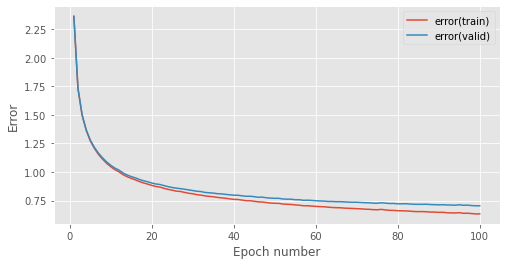

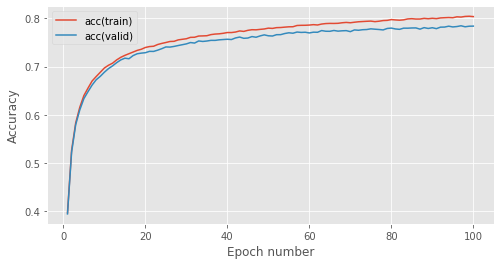

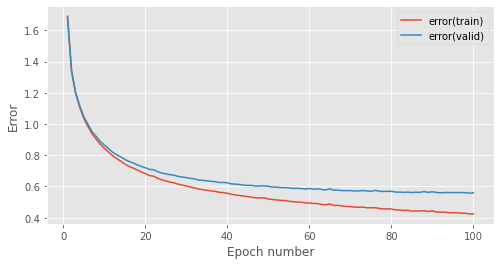

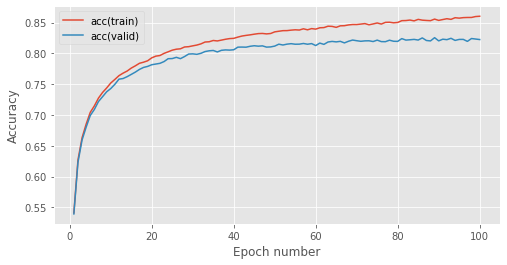

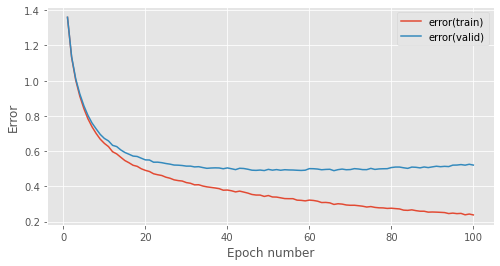

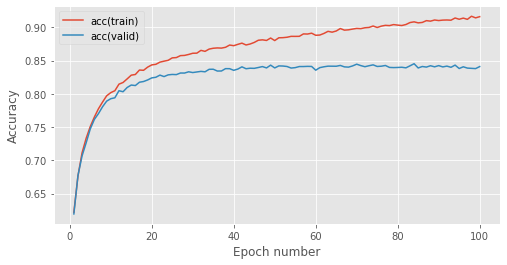

In [81]:
dims = [32, 64, 128]
input_dim, output_dim = 784, 47

error = CrossEntropySoftmaxError()
# Use a Adam learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

for hidden_dim in dims:
    print("Dimension: " + str(hidden_dim))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), # first hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # second hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # third hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init) # output layer
    ])
    # Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    
    record_all(stats, keys, hidden_dim, fig_1, fig_2, "wd/3layers-" + str(hidden_dim) + "units")

# Q3

### Dropout

In [92]:
from mlp.layers import DropoutLayer

Dropout prob: 0.7


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 1.8s to complete
    error(train)=2.65e+00, acc(train)=3.76e-01, error(valid)=2.65e+00, acc(valid)=3.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 2.0s to complete
    error(train)=2.00e+00, acc(train)=5.07e-01, error(valid)=2.00e+00, acc(valid)=5.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 1.9s to complete
    error(train)=1.71e+00, acc(train)=5.62e-01, error(valid)=1.71e+00, acc(valid)=5.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 1.9s to complete
    error(train)=1.56e+00, acc(train)=5.87e-01, error(valid)=1.56e+00, acc(valid)=5.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 2.0s to complete
    error(train)=1.44e+00, acc(train)=6.09e-01, error(valid)=1.44e+00, acc(valid)=6.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 2.0s to complete
    error(train)=1.35e+00, acc(train)=6.26e-01, error(valid)=1.36e+00, acc(valid)=6.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 2.0s to complete
    error(train)=1.27e+00, acc(train)=6.44e-01, error(valid)=1.28e+00, acc(valid)=6.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 2.0s to complete
    error(train)=1.20e+00, acc(train)=6.59e-01, error(valid)=1.21e+00, acc(valid)=6.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 2.1s to complete
    error(train)=1.15e+00, acc(train)=6.71e-01, error(valid)=1.15e+00, acc(valid)=6.69e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 2.0s to complete
    error(train)=1.11e+00, acc(train)=6.82e-01, error(valid)=1.11e+00, acc(valid)=6.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 2.0s to complete
    error(train)=1.07e+00, acc(train)=6.91e-01, error(valid)=1.07e+00, acc(valid)=6.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 2.0s to complete
    error(train)=1.03e+00, acc(train)=6.97e-01, error(valid)=1.04e+00, acc(valid)=6.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 2.0s to complete
    error(train)=1.00e+00, acc(train)=7.04e-01, error(valid)=1.01e+00, acc(valid)=7.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 2.0s to complete
    error(train)=9.62e-01, acc(train)=7.15e-01, error(valid)=9.69e-01, acc(valid)=7.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 2.0s to complete
    error(train)=9.45e-01, acc(train)=7.19e-01, error(valid)=9.53e-01, acc(valid)=7.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 2.0s to complete
    error(train)=9.18e-01, acc(train)=7.25e-01, error(valid)=9.26e-01, acc(valid)=7.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 2.0s to complete
    error(train)=9.01e-01, acc(train)=7.30e-01, error(valid)=9.08e-01, acc(valid)=7.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 1.9s to complete
    error(train)=8.80e-01, acc(train)=7.35e-01, error(valid)=8.89e-01, acc(valid)=7.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 2.0s to complete
    error(train)=8.58e-01, acc(train)=7.40e-01, error(valid)=8.67e-01, acc(valid)=7.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 2.0s to complete
    error(train)=8.43e-01, acc(train)=7.41e-01, error(valid)=8.53e-01, acc(valid)=7.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 1.9s to complete
    error(train)=8.28e-01, acc(train)=7.49e-01, error(valid)=8.37e-01, acc(valid)=7.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 2.0s to complete
    error(train)=8.18e-01, acc(train)=7.50e-01, error(valid)=8.29e-01, acc(valid)=7.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 2.0s to complete
    error(train)=7.99e-01, acc(train)=7.55e-01, error(valid)=8.09e-01, acc(valid)=7.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 2.0s to complete
    error(train)=7.89e-01, acc(train)=7.57e-01, error(valid)=7.99e-01, acc(valid)=7.54e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 1.9s to complete
    error(train)=7.80e-01, acc(train)=7.59e-01, error(valid)=7.90e-01, acc(valid)=7.55e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 1.9s to complete
    error(train)=7.69e-01, acc(train)=7.61e-01, error(valid)=7.80e-01, acc(valid)=7.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 2.0s to complete
    error(train)=7.62e-01, acc(train)=7.63e-01, error(valid)=7.72e-01, acc(valid)=7.58e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 1.9s to complete
    error(train)=7.48e-01, acc(train)=7.68e-01, error(valid)=7.60e-01, acc(valid)=7.63e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 1.9s to complete
    error(train)=7.37e-01, acc(train)=7.69e-01, error(valid)=7.49e-01, acc(valid)=7.63e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 2.1s to complete
    error(train)=7.32e-01, acc(train)=7.70e-01, error(valid)=7.45e-01, acc(valid)=7.64e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 2.0s to complete
    error(train)=7.21e-01, acc(train)=7.72e-01, error(valid)=7.35e-01, acc(valid)=7.67e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 2.1s to complete
    error(train)=7.14e-01, acc(train)=7.75e-01, error(valid)=7.28e-01, acc(valid)=7.69e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 2.0s to complete
    error(train)=7.08e-01, acc(train)=7.78e-01, error(valid)=7.22e-01, acc(valid)=7.74e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 2.1s to complete
    error(train)=7.03e-01, acc(train)=7.78e-01, error(valid)=7.16e-01, acc(valid)=7.74e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 2.0s to complete
    error(train)=6.96e-01, acc(train)=7.79e-01, error(valid)=7.10e-01, acc(valid)=7.74e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 2.0s to complete
    error(train)=6.86e-01, acc(train)=7.81e-01, error(valid)=7.02e-01, acc(valid)=7.74e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 2.0s to complete
    error(train)=6.81e-01, acc(train)=7.84e-01, error(valid)=6.97e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 2.1s to complete
    error(train)=6.75e-01, acc(train)=7.85e-01, error(valid)=6.91e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 2.1s to complete
    error(train)=6.71e-01, acc(train)=7.87e-01, error(valid)=6.87e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 2.1s to complete
    error(train)=6.67e-01, acc(train)=7.88e-01, error(valid)=6.84e-01, acc(valid)=7.82e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 2.1s to complete
    error(train)=6.58e-01, acc(train)=7.89e-01, error(valid)=6.75e-01, acc(valid)=7.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 2.1s to complete
    error(train)=6.54e-01, acc(train)=7.91e-01, error(valid)=6.71e-01, acc(valid)=7.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 2.0s to complete
    error(train)=6.49e-01, acc(train)=7.93e-01, error(valid)=6.66e-01, acc(valid)=7.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 2.0s to complete
    error(train)=6.45e-01, acc(train)=7.92e-01, error(valid)=6.63e-01, acc(valid)=7.86e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 2.0s to complete
    error(train)=6.41e-01, acc(train)=7.93e-01, error(valid)=6.59e-01, acc(valid)=7.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 1.9s to complete
    error(train)=6.36e-01, acc(train)=7.97e-01, error(valid)=6.55e-01, acc(valid)=7.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 2.0s to complete
    error(train)=6.32e-01, acc(train)=7.98e-01, error(valid)=6.51e-01, acc(valid)=7.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 2.0s to complete
    error(train)=6.32e-01, acc(train)=7.96e-01, error(valid)=6.52e-01, acc(valid)=7.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 2.0s to complete
    error(train)=6.24e-01, acc(train)=7.99e-01, error(valid)=6.43e-01, acc(valid)=7.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 1.9s to complete
    error(train)=6.22e-01, acc(train)=7.99e-01, error(valid)=6.42e-01, acc(valid)=7.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 2.0s to complete
    error(train)=6.19e-01, acc(train)=8.01e-01, error(valid)=6.39e-01, acc(valid)=7.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 2.0s to complete
    error(train)=6.12e-01, acc(train)=8.03e-01, error(valid)=6.31e-01, acc(valid)=7.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 2.0s to complete
    error(train)=6.10e-01, acc(train)=8.02e-01, error(valid)=6.30e-01, acc(valid)=7.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 2.0s to complete
    error(train)=6.06e-01, acc(train)=8.04e-01, error(valid)=6.27e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 2.0s to complete
    error(train)=6.04e-01, acc(train)=8.05e-01, error(valid)=6.24e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 2.0s to complete
    error(train)=5.99e-01, acc(train)=8.06e-01, error(valid)=6.20e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 2.0s to complete
    error(train)=5.98e-01, acc(train)=8.05e-01, error(valid)=6.20e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 2.0s to complete
    error(train)=5.93e-01, acc(train)=8.06e-01, error(valid)=6.15e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 2.1s to complete
    error(train)=5.89e-01, acc(train)=8.07e-01, error(valid)=6.11e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 2.1s to complete
    error(train)=5.86e-01, acc(train)=8.10e-01, error(valid)=6.09e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 2.0s to complete
    error(train)=5.89e-01, acc(train)=8.08e-01, error(valid)=6.12e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 2.1s to complete
    error(train)=5.82e-01, acc(train)=8.09e-01, error(valid)=6.05e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 2.1s to complete
    error(train)=5.82e-01, acc(train)=8.10e-01, error(valid)=6.06e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 2.1s to complete
    error(train)=5.79e-01, acc(train)=8.11e-01, error(valid)=6.02e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 2.0s to complete
    error(train)=5.77e-01, acc(train)=8.12e-01, error(valid)=6.01e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 2.0s to complete
    error(train)=5.72e-01, acc(train)=8.12e-01, error(valid)=5.95e-01, acc(valid)=8.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 2.0s to complete
    error(train)=5.70e-01, acc(train)=8.13e-01, error(valid)=5.94e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 2.1s to complete
    error(train)=5.69e-01, acc(train)=8.14e-01, error(valid)=5.93e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 2.0s to complete
    error(train)=5.68e-01, acc(train)=8.14e-01, error(valid)=5.93e-01, acc(valid)=8.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 2.0s to complete
    error(train)=5.64e-01, acc(train)=8.14e-01, error(valid)=5.89e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 2.0s to complete
    error(train)=5.61e-01, acc(train)=8.16e-01, error(valid)=5.85e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 2.0s to complete
    error(train)=5.60e-01, acc(train)=8.17e-01, error(valid)=5.86e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 2.0s to complete
    error(train)=5.56e-01, acc(train)=8.17e-01, error(valid)=5.82e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 2.0s to complete
    error(train)=5.55e-01, acc(train)=8.17e-01, error(valid)=5.80e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 2.0s to complete
    error(train)=5.50e-01, acc(train)=8.18e-01, error(valid)=5.76e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 2.0s to complete
    error(train)=5.53e-01, acc(train)=8.18e-01, error(valid)=5.79e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 2.1s to complete
    error(train)=5.50e-01, acc(train)=8.18e-01, error(valid)=5.76e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 2.0s to complete
    error(train)=5.47e-01, acc(train)=8.19e-01, error(valid)=5.73e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 2.0s to complete
    error(train)=5.45e-01, acc(train)=8.20e-01, error(valid)=5.71e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 2.0s to complete
    error(train)=5.46e-01, acc(train)=8.19e-01, error(valid)=5.72e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 2.1s to complete
    error(train)=5.43e-01, acc(train)=8.20e-01, error(valid)=5.69e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 2.1s to complete
    error(train)=5.41e-01, acc(train)=8.20e-01, error(valid)=5.68e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 2.0s to complete
    error(train)=5.41e-01, acc(train)=8.20e-01, error(valid)=5.67e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 2.0s to complete
    error(train)=5.37e-01, acc(train)=8.21e-01, error(valid)=5.66e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 2.0s to complete
    error(train)=5.36e-01, acc(train)=8.21e-01, error(valid)=5.62e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 2.0s to complete
    error(train)=5.34e-01, acc(train)=8.21e-01, error(valid)=5.62e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 2.0s to complete
    error(train)=5.32e-01, acc(train)=8.22e-01, error(valid)=5.60e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 2.0s to complete
    error(train)=5.32e-01, acc(train)=8.23e-01, error(valid)=5.59e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 2.0s to complete
    error(train)=5.29e-01, acc(train)=8.23e-01, error(valid)=5.57e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 1.9s to complete
    error(train)=5.28e-01, acc(train)=8.24e-01, error(valid)=5.56e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 2.0s to complete
    error(train)=5.26e-01, acc(train)=8.23e-01, error(valid)=5.55e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 2.0s to complete
    error(train)=5.24e-01, acc(train)=8.25e-01, error(valid)=5.52e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 2.0s to complete
    error(train)=5.24e-01, acc(train)=8.25e-01, error(valid)=5.53e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 2.1s to complete
    error(train)=5.23e-01, acc(train)=8.25e-01, error(valid)=5.52e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 2.0s to complete
    error(train)=5.20e-01, acc(train)=8.25e-01, error(valid)=5.50e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 2.0s to complete
    error(train)=5.21e-01, acc(train)=8.25e-01, error(valid)=5.51e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 2.0s to complete
    error(train)=5.19e-01, acc(train)=8.26e-01, error(valid)=5.49e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 2.0s to complete
    error(train)=5.17e-01, acc(train)=8.26e-01, error(valid)=5.47e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 2.0s to complete
    error(train)=5.18e-01, acc(train)=8.26e-01, error(valid)=5.48e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 2.0s to complete
    error(train)=5.17e-01, acc(train)=8.26e-01, error(valid)=5.47e-01, acc(valid)=8.17e-01


Finished model accuracy
Train acc: 0.825599999999999
Val acc: 0.8167721518987341

Finished model error
Train err: 0.5171673444112346
Val err: 0.546977699131532

Dropout prob: 0.9


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 1.8s to complete
    error(train)=1.69e+00, acc(train)=5.55e-01, error(valid)=1.69e+00, acc(valid)=5.53e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 1.8s to complete
    error(train)=1.32e+00, acc(train)=6.32e-01, error(valid)=1.33e+00, acc(valid)=6.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 1.8s to complete
    error(train)=1.16e+00, acc(train)=6.69e-01, error(valid)=1.17e+00, acc(valid)=6.64e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 2.5s to complete
    error(train)=1.05e+00, acc(train)=6.98e-01, error(valid)=1.05e+00, acc(valid)=6.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 1.9s to complete
    error(train)=9.60e-01, acc(train)=7.19e-01, error(valid)=9.69e-01, acc(valid)=7.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 2.0s to complete
    error(train)=8.94e-01, acc(train)=7.34e-01, error(valid)=9.04e-01, acc(valid)=7.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 1.9s to complete
    error(train)=8.39e-01, acc(train)=7.49e-01, error(valid)=8.51e-01, acc(valid)=7.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 1.9s to complete
    error(train)=7.93e-01, acc(train)=7.60e-01, error(valid)=8.04e-01, acc(valid)=7.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 1.9s to complete
    error(train)=7.55e-01, acc(train)=7.68e-01, error(valid)=7.68e-01, acc(valid)=7.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 2.0s to complete
    error(train)=7.24e-01, acc(train)=7.77e-01, error(valid)=7.38e-01, acc(valid)=7.73e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 2.0s to complete
    error(train)=6.95e-01, acc(train)=7.84e-01, error(valid)=7.09e-01, acc(valid)=7.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 2.1s to complete
    error(train)=6.70e-01, acc(train)=7.91e-01, error(valid)=6.84e-01, acc(valid)=7.85e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 2.0s to complete
    error(train)=6.49e-01, acc(train)=7.96e-01, error(valid)=6.64e-01, acc(valid)=7.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 2.0s to complete
    error(train)=6.34e-01, acc(train)=8.00e-01, error(valid)=6.51e-01, acc(valid)=7.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 1.9s to complete
    error(train)=6.15e-01, acc(train)=8.04e-01, error(valid)=6.34e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 2.0s to complete
    error(train)=6.01e-01, acc(train)=8.08e-01, error(valid)=6.21e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 2.0s to complete
    error(train)=5.85e-01, acc(train)=8.13e-01, error(valid)=6.06e-01, acc(valid)=8.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 2.0s to complete
    error(train)=5.72e-01, acc(train)=8.16e-01, error(valid)=5.94e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 2.0s to complete
    error(train)=5.63e-01, acc(train)=8.18e-01, error(valid)=5.88e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 2.0s to complete
    error(train)=5.51e-01, acc(train)=8.21e-01, error(valid)=5.77e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 2.0s to complete
    error(train)=5.41e-01, acc(train)=8.24e-01, error(valid)=5.68e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 2.1s to complete
    error(train)=5.30e-01, acc(train)=8.27e-01, error(valid)=5.59e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 2.0s to complete
    error(train)=5.23e-01, acc(train)=8.29e-01, error(valid)=5.51e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 2.0s to complete
    error(train)=5.17e-01, acc(train)=8.30e-01, error(valid)=5.47e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 2.0s to complete
    error(train)=5.08e-01, acc(train)=8.32e-01, error(valid)=5.41e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 2.0s to complete
    error(train)=5.00e-01, acc(train)=8.35e-01, error(valid)=5.33e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 2.0s to complete
    error(train)=4.96e-01, acc(train)=8.36e-01, error(valid)=5.32e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 2.0s to complete
    error(train)=4.88e-01, acc(train)=8.38e-01, error(valid)=5.26e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 2.0s to complete
    error(train)=4.81e-01, acc(train)=8.40e-01, error(valid)=5.20e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 2.0s to complete
    error(train)=4.76e-01, acc(train)=8.42e-01, error(valid)=5.17e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 2.0s to complete
    error(train)=4.70e-01, acc(train)=8.44e-01, error(valid)=5.11e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 2.0s to complete
    error(train)=4.65e-01, acc(train)=8.45e-01, error(valid)=5.05e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 2.0s to complete
    error(train)=4.60e-01, acc(train)=8.46e-01, error(valid)=5.02e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 2.0s to complete
    error(train)=4.54e-01, acc(train)=8.48e-01, error(valid)=4.98e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 2.0s to complete
    error(train)=4.52e-01, acc(train)=8.48e-01, error(valid)=4.98e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 2.0s to complete
    error(train)=4.48e-01, acc(train)=8.49e-01, error(valid)=4.94e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 2.0s to complete
    error(train)=4.42e-01, acc(train)=8.51e-01, error(valid)=4.90e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 2.0s to complete
    error(train)=4.41e-01, acc(train)=8.51e-01, error(valid)=4.90e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 2.1s to complete
    error(train)=4.35e-01, acc(train)=8.54e-01, error(valid)=4.85e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 2.0s to complete
    error(train)=4.32e-01, acc(train)=8.54e-01, error(valid)=4.84e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 2.0s to complete
    error(train)=4.31e-01, acc(train)=8.54e-01, error(valid)=4.84e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 2.0s to complete
    error(train)=4.24e-01, acc(train)=8.57e-01, error(valid)=4.77e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 2.0s to complete
    error(train)=4.22e-01, acc(train)=8.57e-01, error(valid)=4.78e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 2.0s to complete
    error(train)=4.18e-01, acc(train)=8.58e-01, error(valid)=4.74e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 2.0s to complete
    error(train)=4.17e-01, acc(train)=8.57e-01, error(valid)=4.74e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 2.0s to complete
    error(train)=4.13e-01, acc(train)=8.59e-01, error(valid)=4.71e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 2.1s to complete
    error(train)=4.09e-01, acc(train)=8.61e-01, error(valid)=4.68e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 2.0s to complete
    error(train)=4.05e-01, acc(train)=8.61e-01, error(valid)=4.65e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 2.0s to complete
    error(train)=4.03e-01, acc(train)=8.61e-01, error(valid)=4.64e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 2.0s to complete
    error(train)=4.02e-01, acc(train)=8.63e-01, error(valid)=4.64e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 2.0s to complete
    error(train)=3.99e-01, acc(train)=8.64e-01, error(valid)=4.59e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 2.0s to complete
    error(train)=3.98e-01, acc(train)=8.63e-01, error(valid)=4.60e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 2.0s to complete
    error(train)=3.93e-01, acc(train)=8.64e-01, error(valid)=4.56e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 2.0s to complete
    error(train)=3.90e-01, acc(train)=8.65e-01, error(valid)=4.55e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 2.0s to complete
    error(train)=3.89e-01, acc(train)=8.65e-01, error(valid)=4.54e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 2.0s to complete
    error(train)=3.87e-01, acc(train)=8.65e-01, error(valid)=4.52e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 2.0s to complete
    error(train)=3.85e-01, acc(train)=8.66e-01, error(valid)=4.50e-01, acc(valid)=8.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 2.0s to complete
    error(train)=3.82e-01, acc(train)=8.66e-01, error(valid)=4.49e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 2.1s to complete
    error(train)=3.82e-01, acc(train)=8.67e-01, error(valid)=4.51e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 2.0s to complete
    error(train)=3.78e-01, acc(train)=8.68e-01, error(valid)=4.48e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 2.0s to complete
    error(train)=3.76e-01, acc(train)=8.69e-01, error(valid)=4.46e-01, acc(valid)=8.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 2.0s to complete
    error(train)=3.74e-01, acc(train)=8.69e-01, error(valid)=4.46e-01, acc(valid)=8.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 2.0s to complete
    error(train)=3.73e-01, acc(train)=8.69e-01, error(valid)=4.46e-01, acc(valid)=8.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 2.0s to complete
    error(train)=3.69e-01, acc(train)=8.72e-01, error(valid)=4.42e-01, acc(valid)=8.50e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 2.1s to complete
    error(train)=3.70e-01, acc(train)=8.71e-01, error(valid)=4.43e-01, acc(valid)=8.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 2.0s to complete
    error(train)=3.66e-01, acc(train)=8.72e-01, error(valid)=4.39e-01, acc(valid)=8.51e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 2.0s to complete
    error(train)=3.66e-01, acc(train)=8.72e-01, error(valid)=4.40e-01, acc(valid)=8.50e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 2.0s to complete
    error(train)=3.63e-01, acc(train)=8.73e-01, error(valid)=4.37e-01, acc(valid)=8.51e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 2.1s to complete
    error(train)=3.61e-01, acc(train)=8.73e-01, error(valid)=4.36e-01, acc(valid)=8.51e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 2.0s to complete
    error(train)=3.60e-01, acc(train)=8.74e-01, error(valid)=4.36e-01, acc(valid)=8.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 2.0s to complete
    error(train)=3.58e-01, acc(train)=8.74e-01, error(valid)=4.35e-01, acc(valid)=8.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 2.0s to complete
    error(train)=3.57e-01, acc(train)=8.74e-01, error(valid)=4.35e-01, acc(valid)=8.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 2.0s to complete
    error(train)=3.56e-01, acc(train)=8.74e-01, error(valid)=4.35e-01, acc(valid)=8.51e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 2.0s to complete
    error(train)=3.53e-01, acc(train)=8.75e-01, error(valid)=4.32e-01, acc(valid)=8.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 2.1s to complete
    error(train)=3.51e-01, acc(train)=8.77e-01, error(valid)=4.32e-01, acc(valid)=8.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 2.2s to complete
    error(train)=3.51e-01, acc(train)=8.76e-01, error(valid)=4.32e-01, acc(valid)=8.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 2.2s to complete
    error(train)=3.48e-01, acc(train)=8.78e-01, error(valid)=4.30e-01, acc(valid)=8.51e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 2.1s to complete
    error(train)=3.48e-01, acc(train)=8.77e-01, error(valid)=4.31e-01, acc(valid)=8.53e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 2.1s to complete
    error(train)=3.47e-01, acc(train)=8.77e-01, error(valid)=4.30e-01, acc(valid)=8.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 2.1s to complete
    error(train)=3.44e-01, acc(train)=8.78e-01, error(valid)=4.29e-01, acc(valid)=8.54e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 2.1s to complete
    error(train)=3.43e-01, acc(train)=8.79e-01, error(valid)=4.29e-01, acc(valid)=8.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 2.2s to complete
    error(train)=3.41e-01, acc(train)=8.79e-01, error(valid)=4.27e-01, acc(valid)=8.54e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 2.1s to complete
    error(train)=3.41e-01, acc(train)=8.79e-01, error(valid)=4.27e-01, acc(valid)=8.53e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 2.1s to complete
    error(train)=3.39e-01, acc(train)=8.79e-01, error(valid)=4.27e-01, acc(valid)=8.54e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 2.1s to complete
    error(train)=3.36e-01, acc(train)=8.82e-01, error(valid)=4.23e-01, acc(valid)=8.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 2.1s to complete
    error(train)=3.38e-01, acc(train)=8.79e-01, error(valid)=4.26e-01, acc(valid)=8.55e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 2.1s to complete
    error(train)=3.36e-01, acc(train)=8.80e-01, error(valid)=4.26e-01, acc(valid)=8.55e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 2.1s to complete
    error(train)=3.33e-01, acc(train)=8.82e-01, error(valid)=4.22e-01, acc(valid)=8.55e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 2.1s to complete
    error(train)=3.33e-01, acc(train)=8.81e-01, error(valid)=4.23e-01, acc(valid)=8.55e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 2.1s to complete
    error(train)=3.32e-01, acc(train)=8.82e-01, error(valid)=4.21e-01, acc(valid)=8.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 2.2s to complete
    error(train)=3.32e-01, acc(train)=8.82e-01, error(valid)=4.21e-01, acc(valid)=8.55e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 2.1s to complete
    error(train)=3.30e-01, acc(train)=8.82e-01, error(valid)=4.21e-01, acc(valid)=8.55e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 2.2s to complete
    error(train)=3.28e-01, acc(train)=8.83e-01, error(valid)=4.19e-01, acc(valid)=8.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 2.2s to complete
    error(train)=3.27e-01, acc(train)=8.84e-01, error(valid)=4.18e-01, acc(valid)=8.55e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 2.1s to complete
    error(train)=3.24e-01, acc(train)=8.84e-01, error(valid)=4.17e-01, acc(valid)=8.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 2.1s to complete
    error(train)=3.24e-01, acc(train)=8.84e-01, error(valid)=4.17e-01, acc(valid)=8.55e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 2.1s to complete
    error(train)=3.24e-01, acc(train)=8.84e-01, error(valid)=4.18e-01, acc(valid)=8.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 2.1s to complete
    error(train)=3.22e-01, acc(train)=8.85e-01, error(valid)=4.17e-01, acc(valid)=8.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 2.1s to complete
    error(train)=3.21e-01, acc(train)=8.84e-01, error(valid)=4.16e-01, acc(valid)=8.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 2.2s to complete
    error(train)=3.19e-01, acc(train)=8.86e-01, error(valid)=4.15e-01, acc(valid)=8.58e-01


Finished model accuracy
Train acc: 0.8858899999999975
Val acc: 0.8577848101265814

Finished model error
Train err: 0.3193928119176338
Val err: 0.4146285071443015

Dropout prob: 0.95


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 1.8s to complete
    error(train)=1.52e+00, acc(train)=5.88e-01, error(valid)=1.52e+00, acc(valid)=5.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 1.8s to complete
    error(train)=1.18e+00, acc(train)=6.65e-01, error(valid)=1.19e+00, acc(valid)=6.60e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 1.8s to complete
    error(train)=1.03e+00, acc(train)=7.00e-01, error(valid)=1.04e+00, acc(valid)=6.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 1.8s to complete
    error(train)=9.30e-01, acc(train)=7.26e-01, error(valid)=9.41e-01, acc(valid)=7.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 1.9s to complete
    error(train)=8.47e-01, acc(train)=7.48e-01, error(valid)=8.60e-01, acc(valid)=7.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 1.9s to complete
    error(train)=7.90e-01, acc(train)=7.60e-01, error(valid)=8.06e-01, acc(valid)=7.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 1.9s to complete
    error(train)=7.40e-01, acc(train)=7.74e-01, error(valid)=7.57e-01, acc(valid)=7.68e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 1.9s to complete
    error(train)=6.98e-01, acc(train)=7.84e-01, error(valid)=7.16e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 1.9s to complete
    error(train)=6.71e-01, acc(train)=7.90e-01, error(valid)=6.90e-01, acc(valid)=7.85e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 1.9s to complete
    error(train)=6.42e-01, acc(train)=7.99e-01, error(valid)=6.62e-01, acc(valid)=7.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 1.9s to complete
    error(train)=6.18e-01, acc(train)=8.06e-01, error(valid)=6.41e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 1.9s to complete
    error(train)=5.97e-01, acc(train)=8.11e-01, error(valid)=6.22e-01, acc(valid)=8.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 1.9s to complete
    error(train)=5.81e-01, acc(train)=8.16e-01, error(valid)=6.08e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 1.9s to complete
    error(train)=5.67e-01, acc(train)=8.18e-01, error(valid)=5.95e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 2.0s to complete
    error(train)=5.49e-01, acc(train)=8.23e-01, error(valid)=5.79e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 2.0s to complete
    error(train)=5.37e-01, acc(train)=8.26e-01, error(valid)=5.70e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 2.0s to complete
    error(train)=5.24e-01, acc(train)=8.31e-01, error(valid)=5.58e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 1.9s to complete
    error(train)=5.11e-01, acc(train)=8.34e-01, error(valid)=5.48e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 1.9s to complete
    error(train)=5.02e-01, acc(train)=8.35e-01, error(valid)=5.40e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 2.0s to complete
    error(train)=4.93e-01, acc(train)=8.38e-01, error(valid)=5.33e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 2.0s to complete
    error(train)=4.84e-01, acc(train)=8.40e-01, error(valid)=5.26e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 1.9s to complete
    error(train)=4.76e-01, acc(train)=8.43e-01, error(valid)=5.18e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 1.9s to complete
    error(train)=4.68e-01, acc(train)=8.45e-01, error(valid)=5.13e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 1.9s to complete
    error(train)=4.61e-01, acc(train)=8.47e-01, error(valid)=5.09e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 2.0s to complete
    error(train)=4.53e-01, acc(train)=8.49e-01, error(valid)=5.00e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 2.0s to complete
    error(train)=4.47e-01, acc(train)=8.50e-01, error(valid)=4.99e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 2.0s to complete
    error(train)=4.40e-01, acc(train)=8.53e-01, error(valid)=4.92e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 2.0s to complete
    error(train)=4.34e-01, acc(train)=8.55e-01, error(valid)=4.88e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 2.0s to complete
    error(train)=4.30e-01, acc(train)=8.55e-01, error(valid)=4.85e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 2.0s to complete
    error(train)=4.24e-01, acc(train)=8.57e-01, error(valid)=4.78e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 2.0s to complete
    error(train)=4.18e-01, acc(train)=8.58e-01, error(valid)=4.75e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 2.0s to complete
    error(train)=4.13e-01, acc(train)=8.61e-01, error(valid)=4.72e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 2.0s to complete
    error(train)=4.09e-01, acc(train)=8.61e-01, error(valid)=4.69e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 2.0s to complete
    error(train)=4.06e-01, acc(train)=8.61e-01, error(valid)=4.68e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 2.0s to complete
    error(train)=4.01e-01, acc(train)=8.64e-01, error(valid)=4.65e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 2.0s to complete
    error(train)=3.96e-01, acc(train)=8.64e-01, error(valid)=4.61e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 2.0s to complete
    error(train)=3.92e-01, acc(train)=8.66e-01, error(valid)=4.58e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 2.0s to complete
    error(train)=3.87e-01, acc(train)=8.67e-01, error(valid)=4.54e-01, acc(valid)=8.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 2.1s to complete
    error(train)=3.85e-01, acc(train)=8.68e-01, error(valid)=4.53e-01, acc(valid)=8.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 2.0s to complete
    error(train)=3.79e-01, acc(train)=8.69e-01, error(valid)=4.49e-01, acc(valid)=8.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 2.5s to complete
    error(train)=3.79e-01, acc(train)=8.69e-01, error(valid)=4.51e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 2.0s to complete
    error(train)=3.74e-01, acc(train)=8.71e-01, error(valid)=4.44e-01, acc(valid)=8.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 2.0s to complete
    error(train)=3.70e-01, acc(train)=8.73e-01, error(valid)=4.44e-01, acc(valid)=8.50e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 2.0s to complete
    error(train)=3.68e-01, acc(train)=8.73e-01, error(valid)=4.44e-01, acc(valid)=8.52e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 2.0s to complete
    error(train)=3.66e-01, acc(train)=8.74e-01, error(valid)=4.42e-01, acc(valid)=8.50e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 2.0s to complete
    error(train)=3.64e-01, acc(train)=8.75e-01, error(valid)=4.43e-01, acc(valid)=8.51e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 2.0s to complete
    error(train)=3.58e-01, acc(train)=8.76e-01, error(valid)=4.36e-01, acc(valid)=8.53e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 2.0s to complete
    error(train)=3.56e-01, acc(train)=8.76e-01, error(valid)=4.35e-01, acc(valid)=8.53e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 2.0s to complete
    error(train)=3.52e-01, acc(train)=8.77e-01, error(valid)=4.33e-01, acc(valid)=8.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 2.0s to complete
    error(train)=3.51e-01, acc(train)=8.77e-01, error(valid)=4.35e-01, acc(valid)=8.54e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 2.0s to complete
    error(train)=3.48e-01, acc(train)=8.79e-01, error(valid)=4.32e-01, acc(valid)=8.54e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 2.0s to complete
    error(train)=3.44e-01, acc(train)=8.79e-01, error(valid)=4.30e-01, acc(valid)=8.54e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 2.0s to complete
    error(train)=3.42e-01, acc(train)=8.80e-01, error(valid)=4.28e-01, acc(valid)=8.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 1.9s to complete
    error(train)=3.38e-01, acc(train)=8.82e-01, error(valid)=4.27e-01, acc(valid)=8.55e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 2.0s to complete
    error(train)=3.39e-01, acc(train)=8.81e-01, error(valid)=4.29e-01, acc(valid)=8.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 1.9s to complete
    error(train)=3.35e-01, acc(train)=8.82e-01, error(valid)=4.27e-01, acc(valid)=8.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 1.9s to complete
    error(train)=3.35e-01, acc(train)=8.82e-01, error(valid)=4.28e-01, acc(valid)=8.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 2.0s to complete
    error(train)=3.31e-01, acc(train)=8.83e-01, error(valid)=4.24e-01, acc(valid)=8.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 2.0s to complete
    error(train)=3.28e-01, acc(train)=8.85e-01, error(valid)=4.23e-01, acc(valid)=8.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 2.0s to complete
    error(train)=3.27e-01, acc(train)=8.85e-01, error(valid)=4.22e-01, acc(valid)=8.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 2.0s to complete
    error(train)=3.26e-01, acc(train)=8.84e-01, error(valid)=4.24e-01, acc(valid)=8.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 2.0s to complete
    error(train)=3.24e-01, acc(train)=8.85e-01, error(valid)=4.23e-01, acc(valid)=8.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 2.0s to complete
    error(train)=3.21e-01, acc(train)=8.86e-01, error(valid)=4.21e-01, acc(valid)=8.58e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 2.0s to complete
    error(train)=3.19e-01, acc(train)=8.87e-01, error(valid)=4.19e-01, acc(valid)=8.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 2.0s to complete
    error(train)=3.17e-01, acc(train)=8.87e-01, error(valid)=4.19e-01, acc(valid)=8.58e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 2.0s to complete
    error(train)=3.14e-01, acc(train)=8.88e-01, error(valid)=4.17e-01, acc(valid)=8.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 2.1s to complete
    error(train)=3.14e-01, acc(train)=8.88e-01, error(valid)=4.18e-01, acc(valid)=8.58e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 2.1s to complete
    error(train)=3.12e-01, acc(train)=8.89e-01, error(valid)=4.18e-01, acc(valid)=8.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 2.0s to complete
    error(train)=3.10e-01, acc(train)=8.89e-01, error(valid)=4.19e-01, acc(valid)=8.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 2.0s to complete
    error(train)=3.08e-01, acc(train)=8.90e-01, error(valid)=4.16e-01, acc(valid)=8.58e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 2.0s to complete
    error(train)=3.06e-01, acc(train)=8.90e-01, error(valid)=4.17e-01, acc(valid)=8.58e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 2.1s to complete
    error(train)=3.05e-01, acc(train)=8.91e-01, error(valid)=4.16e-01, acc(valid)=8.58e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 2.0s to complete
    error(train)=3.03e-01, acc(train)=8.91e-01, error(valid)=4.14e-01, acc(valid)=8.58e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 2.1s to complete
    error(train)=3.01e-01, acc(train)=8.92e-01, error(valid)=4.13e-01, acc(valid)=8.61e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 2.0s to complete
    error(train)=3.01e-01, acc(train)=8.92e-01, error(valid)=4.13e-01, acc(valid)=8.61e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 2.0s to complete
    error(train)=2.97e-01, acc(train)=8.93e-01, error(valid)=4.11e-01, acc(valid)=8.58e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 2.0s to complete
    error(train)=2.95e-01, acc(train)=8.94e-01, error(valid)=4.11e-01, acc(valid)=8.60e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 2.0s to complete
    error(train)=2.93e-01, acc(train)=8.94e-01, error(valid)=4.11e-01, acc(valid)=8.60e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 2.0s to complete
    error(train)=2.92e-01, acc(train)=8.94e-01, error(valid)=4.11e-01, acc(valid)=8.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 2.0s to complete
    error(train)=2.93e-01, acc(train)=8.94e-01, error(valid)=4.10e-01, acc(valid)=8.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 2.0s to complete
    error(train)=2.91e-01, acc(train)=8.94e-01, error(valid)=4.11e-01, acc(valid)=8.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 2.1s to complete
    error(train)=2.88e-01, acc(train)=8.96e-01, error(valid)=4.08e-01, acc(valid)=8.60e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 2.0s to complete
    error(train)=2.87e-01, acc(train)=8.96e-01, error(valid)=4.11e-01, acc(valid)=8.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 2.0s to complete
    error(train)=2.87e-01, acc(train)=8.97e-01, error(valid)=4.12e-01, acc(valid)=8.60e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 2.0s to complete
    error(train)=2.84e-01, acc(train)=8.97e-01, error(valid)=4.08e-01, acc(valid)=8.61e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 2.0s to complete
    error(train)=2.84e-01, acc(train)=8.97e-01, error(valid)=4.07e-01, acc(valid)=8.61e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 2.0s to complete
    error(train)=2.81e-01, acc(train)=8.98e-01, error(valid)=4.07e-01, acc(valid)=8.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 2.0s to complete
    error(train)=2.82e-01, acc(train)=8.98e-01, error(valid)=4.11e-01, acc(valid)=8.60e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 2.0s to complete
    error(train)=2.79e-01, acc(train)=8.99e-01, error(valid)=4.07e-01, acc(valid)=8.61e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 2.0s to complete
    error(train)=2.79e-01, acc(train)=8.98e-01, error(valid)=4.07e-01, acc(valid)=8.63e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 2.1s to complete
    error(train)=2.78e-01, acc(train)=8.99e-01, error(valid)=4.09e-01, acc(valid)=8.60e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 2.0s to complete
    error(train)=2.77e-01, acc(train)=8.99e-01, error(valid)=4.10e-01, acc(valid)=8.61e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 2.0s to complete
    error(train)=2.74e-01, acc(train)=9.00e-01, error(valid)=4.08e-01, acc(valid)=8.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 2.0s to complete
    error(train)=2.74e-01, acc(train)=9.00e-01, error(valid)=4.06e-01, acc(valid)=8.60e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 2.0s to complete
    error(train)=2.72e-01, acc(train)=9.01e-01, error(valid)=4.07e-01, acc(valid)=8.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 2.1s to complete
    error(train)=2.70e-01, acc(train)=9.01e-01, error(valid)=4.09e-01, acc(valid)=8.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 2.1s to complete
    error(train)=2.69e-01, acc(train)=9.02e-01, error(valid)=4.06e-01, acc(valid)=8.63e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 2.0s to complete
    error(train)=2.69e-01, acc(train)=9.01e-01, error(valid)=4.07e-01, acc(valid)=8.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 2.0s to complete
    error(train)=2.66e-01, acc(train)=9.03e-01, error(valid)=4.05e-01, acc(valid)=8.64e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 2.0s to complete
    error(train)=2.67e-01, acc(train)=9.02e-01, error(valid)=4.09e-01, acc(valid)=8.62e-01


Finished model accuracy
Train acc: 0.9015999999999952
Val acc: 0.8615189873417723

Finished model error
Train err: 0.2667870174219443
Val err: 0.4090813152483095



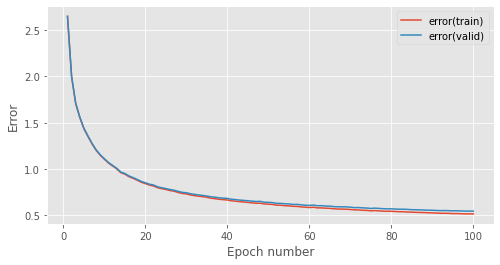

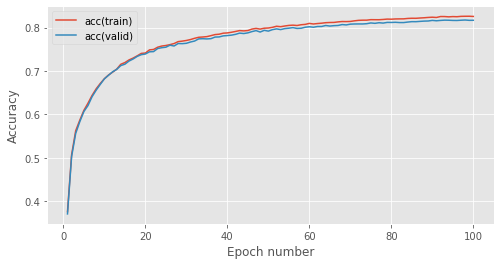

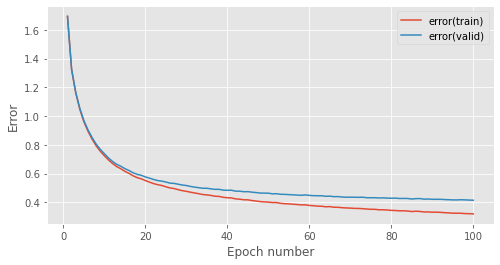

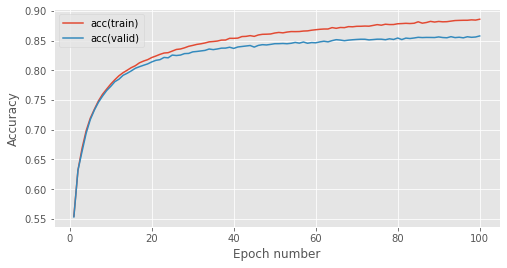

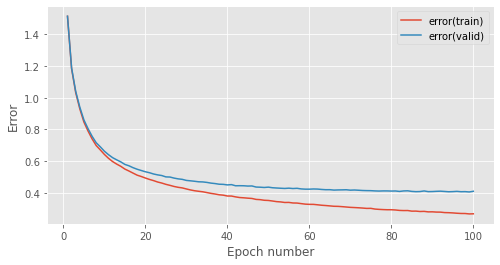

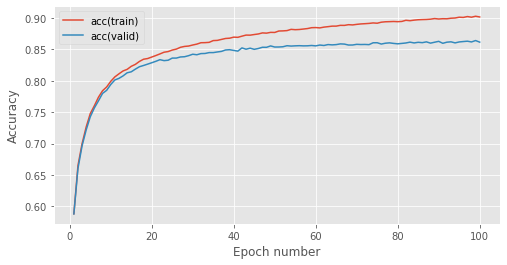

In [93]:
probs = [0.7, 0.9, 0.95]
input_dim, output_dim, hidden_dim = 784, 47, 128

error = CrossEntropySoftmaxError()
# Use a Adam learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

for incl_prob in probs:
    print("Dropout prob: " + str(incl_prob))
    model = MultipleLayerModel([
        DropoutLayer(rng, incl_prob),
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), # first hidden layer
        ReluLayer(),
        DropoutLayer(rng, incl_prob),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # second hidden layer
        ReluLayer(),
        DropoutLayer(rng, incl_prob),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # third hidden layer
        ReluLayer(),
        DropoutLayer(rng, incl_prob),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init) # output layer
    ])
    # Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    
    record_all(stats, keys, hidden_dim, fig_1, fig_2, "dropout/dropout-prob-" + str(incl_prob))

### Weight Penalty

In [94]:
%run ./DropoutandPenalty_tests.ipynb

Dropout Layer Fprop Functionality Test Passed
Dropout Layer Bprop Test Passed
L1 Penalty Call Functionality Test Passed
L1 Penalty Grad Function Test Passed
L2 Penalty Call Functionality Test Passed
L2 Penalty Grad Function Test Passed


In [95]:
from mlp.penalties import L1Penalty, L2Penalty

#### L1Penalty

L1Penalty coeff: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.11e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.23e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.23e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 2.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 2.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 2.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 2.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 2.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 2.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 2.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Finished model accuracy
Train acc: 0.02174999999999998
Val acc: 0.019810126582278462

Finished model error
Train err: 3.850095788029594
Val err: 3.8505359848380056

L1Penalty coeff: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 2.2s to complete
    error(train)=1.73e+00, acc(train)=5.46e-01, error(valid)=1.73e+00, acc(valid)=5.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 2.1s to complete
    error(train)=1.56e+00, acc(train)=5.82e-01, error(valid)=1.56e+00, acc(valid)=5.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 2.1s to complete
    error(train)=1.50e+00, acc(train)=6.01e-01, error(valid)=1.50e+00, acc(valid)=5.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 2.1s to complete
    error(train)=1.45e+00, acc(train)=6.10e-01, error(valid)=1.46e+00, acc(valid)=6.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 2.1s to complete
    error(train)=1.42e+00, acc(train)=6.18e-01, error(valid)=1.42e+00, acc(valid)=6.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 2.1s to complete
    error(train)=1.38e+00, acc(train)=6.26e-01, error(valid)=1.39e+00, acc(valid)=6.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 2.1s to complete
    error(train)=1.36e+00, acc(train)=6.30e-01, error(valid)=1.37e+00, acc(valid)=6.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 2.2s to complete
    error(train)=1.33e+00, acc(train)=6.36e-01, error(valid)=1.34e+00, acc(valid)=6.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 2.1s to complete
    error(train)=1.31e+00, acc(train)=6.42e-01, error(valid)=1.32e+00, acc(valid)=6.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 2.4s to complete
    error(train)=1.29e+00, acc(train)=6.48e-01, error(valid)=1.30e+00, acc(valid)=6.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 2.2s to complete
    error(train)=1.28e+00, acc(train)=6.51e-01, error(valid)=1.29e+00, acc(valid)=6.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 2.1s to complete
    error(train)=1.26e+00, acc(train)=6.52e-01, error(valid)=1.27e+00, acc(valid)=6.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 2.1s to complete
    error(train)=1.25e+00, acc(train)=6.54e-01, error(valid)=1.26e+00, acc(valid)=6.49e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 2.1s to complete
    error(train)=1.23e+00, acc(train)=6.60e-01, error(valid)=1.24e+00, acc(valid)=6.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 2.1s to complete
    error(train)=1.22e+00, acc(train)=6.62e-01, error(valid)=1.23e+00, acc(valid)=6.56e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 2.2s to complete
    error(train)=1.21e+00, acc(train)=6.64e-01, error(valid)=1.22e+00, acc(valid)=6.59e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 2.1s to complete
    error(train)=1.20e+00, acc(train)=6.65e-01, error(valid)=1.21e+00, acc(valid)=6.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 2.1s to complete
    error(train)=1.19e+00, acc(train)=6.68e-01, error(valid)=1.20e+00, acc(valid)=6.63e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 2.1s to complete
    error(train)=1.18e+00, acc(train)=6.70e-01, error(valid)=1.19e+00, acc(valid)=6.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 2.2s to complete
    error(train)=1.17e+00, acc(train)=6.74e-01, error(valid)=1.18e+00, acc(valid)=6.69e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 2.1s to complete
    error(train)=1.16e+00, acc(train)=6.75e-01, error(valid)=1.17e+00, acc(valid)=6.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 2.1s to complete
    error(train)=1.15e+00, acc(train)=6.77e-01, error(valid)=1.16e+00, acc(valid)=6.71e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 2.1s to complete
    error(train)=1.14e+00, acc(train)=6.80e-01, error(valid)=1.15e+00, acc(valid)=6.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 2.2s to complete
    error(train)=1.13e+00, acc(train)=6.81e-01, error(valid)=1.14e+00, acc(valid)=6.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 2.1s to complete
    error(train)=1.12e+00, acc(train)=6.83e-01, error(valid)=1.14e+00, acc(valid)=6.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 2.1s to complete
    error(train)=1.11e+00, acc(train)=6.86e-01, error(valid)=1.13e+00, acc(valid)=6.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 2.1s to complete
    error(train)=1.10e+00, acc(train)=6.87e-01, error(valid)=1.12e+00, acc(valid)=6.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 2.1s to complete
    error(train)=1.10e+00, acc(train)=6.89e-01, error(valid)=1.11e+00, acc(valid)=6.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 2.1s to complete
    error(train)=1.09e+00, acc(train)=6.89e-01, error(valid)=1.10e+00, acc(valid)=6.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 2.1s to complete
    error(train)=1.08e+00, acc(train)=6.91e-01, error(valid)=1.10e+00, acc(valid)=6.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 2.1s to complete
    error(train)=1.08e+00, acc(train)=6.94e-01, error(valid)=1.09e+00, acc(valid)=6.89e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 2.1s to complete
    error(train)=1.07e+00, acc(train)=6.96e-01, error(valid)=1.08e+00, acc(valid)=6.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 2.1s to complete
    error(train)=1.06e+00, acc(train)=6.95e-01, error(valid)=1.08e+00, acc(valid)=6.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 2.2s to complete
    error(train)=1.06e+00, acc(train)=6.98e-01, error(valid)=1.07e+00, acc(valid)=6.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 2.1s to complete
    error(train)=1.05e+00, acc(train)=6.99e-01, error(valid)=1.06e+00, acc(valid)=6.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 2.1s to complete
    error(train)=1.05e+00, acc(train)=6.99e-01, error(valid)=1.06e+00, acc(valid)=6.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 2.2s to complete
    error(train)=1.04e+00, acc(train)=7.02e-01, error(valid)=1.05e+00, acc(valid)=6.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 2.1s to complete
    error(train)=1.03e+00, acc(train)=7.04e-01, error(valid)=1.05e+00, acc(valid)=7.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 2.1s to complete
    error(train)=1.03e+00, acc(train)=7.05e-01, error(valid)=1.04e+00, acc(valid)=7.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 2.1s to complete
    error(train)=1.02e+00, acc(train)=7.06e-01, error(valid)=1.03e+00, acc(valid)=7.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 2.2s to complete
    error(train)=1.02e+00, acc(train)=7.06e-01, error(valid)=1.03e+00, acc(valid)=7.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 2.1s to complete
    error(train)=1.01e+00, acc(train)=7.08e-01, error(valid)=1.02e+00, acc(valid)=7.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 2.1s to complete
    error(train)=1.01e+00, acc(train)=7.10e-01, error(valid)=1.02e+00, acc(valid)=7.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 2.1s to complete
    error(train)=1.00e+00, acc(train)=7.10e-01, error(valid)=1.01e+00, acc(valid)=7.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 2.1s to complete
    error(train)=9.99e-01, acc(train)=7.12e-01, error(valid)=1.01e+00, acc(valid)=7.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 2.1s to complete
    error(train)=9.98e-01, acc(train)=7.12e-01, error(valid)=1.01e+00, acc(valid)=7.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 2.2s to complete
    error(train)=9.95e-01, acc(train)=7.13e-01, error(valid)=1.00e+00, acc(valid)=7.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 2.1s to complete
    error(train)=9.92e-01, acc(train)=7.13e-01, error(valid)=1.00e+00, acc(valid)=7.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 2.1s to complete
    error(train)=9.87e-01, acc(train)=7.15e-01, error(valid)=9.95e-01, acc(valid)=7.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 2.1s to complete
    error(train)=9.89e-01, acc(train)=7.15e-01, error(valid)=9.98e-01, acc(valid)=7.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 2.1s to complete
    error(train)=9.82e-01, acc(train)=7.16e-01, error(valid)=9.89e-01, acc(valid)=7.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 2.2s to complete
    error(train)=9.78e-01, acc(train)=7.17e-01, error(valid)=9.87e-01, acc(valid)=7.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 2.1s to complete
    error(train)=9.74e-01, acc(train)=7.17e-01, error(valid)=9.82e-01, acc(valid)=7.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 2.1s to complete
    error(train)=9.72e-01, acc(train)=7.18e-01, error(valid)=9.79e-01, acc(valid)=7.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 2.2s to complete
    error(train)=9.71e-01, acc(train)=7.17e-01, error(valid)=9.80e-01, acc(valid)=7.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 2.3s to complete
    error(train)=9.66e-01, acc(train)=7.20e-01, error(valid)=9.75e-01, acc(valid)=7.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 2.2s to complete
    error(train)=9.66e-01, acc(train)=7.20e-01, error(valid)=9.74e-01, acc(valid)=7.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 2.3s to complete
    error(train)=9.61e-01, acc(train)=7.21e-01, error(valid)=9.70e-01, acc(valid)=7.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 2.2s to complete
    error(train)=9.59e-01, acc(train)=7.21e-01, error(valid)=9.67e-01, acc(valid)=7.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 2.1s to complete
    error(train)=9.58e-01, acc(train)=7.21e-01, error(valid)=9.66e-01, acc(valid)=7.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 2.1s to complete
    error(train)=9.54e-01, acc(train)=7.22e-01, error(valid)=9.63e-01, acc(valid)=7.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 2.1s to complete
    error(train)=9.51e-01, acc(train)=7.23e-01, error(valid)=9.60e-01, acc(valid)=7.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 2.1s to complete
    error(train)=9.49e-01, acc(train)=7.22e-01, error(valid)=9.59e-01, acc(valid)=7.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 2.2s to complete
    error(train)=9.47e-01, acc(train)=7.25e-01, error(valid)=9.57e-01, acc(valid)=7.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 2.1s to complete
    error(train)=9.44e-01, acc(train)=7.24e-01, error(valid)=9.52e-01, acc(valid)=7.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 2.1s to complete
    error(train)=9.42e-01, acc(train)=7.26e-01, error(valid)=9.50e-01, acc(valid)=7.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 2.1s to complete
    error(train)=9.40e-01, acc(train)=7.26e-01, error(valid)=9.48e-01, acc(valid)=7.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 2.1s to complete
    error(train)=9.39e-01, acc(train)=7.25e-01, error(valid)=9.49e-01, acc(valid)=7.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 2.1s to complete
    error(train)=9.36e-01, acc(train)=7.26e-01, error(valid)=9.44e-01, acc(valid)=7.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 2.2s to complete
    error(train)=9.31e-01, acc(train)=7.28e-01, error(valid)=9.40e-01, acc(valid)=7.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 2.1s to complete
    error(train)=9.31e-01, acc(train)=7.27e-01, error(valid)=9.39e-01, acc(valid)=7.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 2.1s to complete
    error(train)=9.30e-01, acc(train)=7.26e-01, error(valid)=9.37e-01, acc(valid)=7.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 2.1s to complete
    error(train)=9.26e-01, acc(train)=7.29e-01, error(valid)=9.34e-01, acc(valid)=7.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 2.1s to complete
    error(train)=9.25e-01, acc(train)=7.28e-01, error(valid)=9.33e-01, acc(valid)=7.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 2.1s to complete
    error(train)=9.22e-01, acc(train)=7.30e-01, error(valid)=9.30e-01, acc(valid)=7.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 2.1s to complete
    error(train)=9.20e-01, acc(train)=7.30e-01, error(valid)=9.28e-01, acc(valid)=7.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 2.2s to complete
    error(train)=9.19e-01, acc(train)=7.29e-01, error(valid)=9.29e-01, acc(valid)=7.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 2.2s to complete
    error(train)=9.19e-01, acc(train)=7.30e-01, error(valid)=9.28e-01, acc(valid)=7.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 2.1s to complete
    error(train)=9.14e-01, acc(train)=7.31e-01, error(valid)=9.22e-01, acc(valid)=7.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 2.1s to complete
    error(train)=9.15e-01, acc(train)=7.30e-01, error(valid)=9.24e-01, acc(valid)=7.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 2.1s to complete
    error(train)=9.15e-01, acc(train)=7.32e-01, error(valid)=9.22e-01, acc(valid)=7.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 2.1s to complete
    error(train)=9.12e-01, acc(train)=7.32e-01, error(valid)=9.21e-01, acc(valid)=7.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 2.1s to complete
    error(train)=9.10e-01, acc(train)=7.33e-01, error(valid)=9.17e-01, acc(valid)=7.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 2.1s to complete
    error(train)=9.07e-01, acc(train)=7.35e-01, error(valid)=9.15e-01, acc(valid)=7.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 2.1s to complete
    error(train)=9.07e-01, acc(train)=7.33e-01, error(valid)=9.15e-01, acc(valid)=7.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 2.1s to complete
    error(train)=9.08e-01, acc(train)=7.32e-01, error(valid)=9.16e-01, acc(valid)=7.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 2.2s to complete
    error(train)=9.03e-01, acc(train)=7.35e-01, error(valid)=9.12e-01, acc(valid)=7.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 2.1s to complete
    error(train)=9.05e-01, acc(train)=7.33e-01, error(valid)=9.13e-01, acc(valid)=7.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 2.1s to complete
    error(train)=9.01e-01, acc(train)=7.34e-01, error(valid)=9.09e-01, acc(valid)=7.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 2.2s to complete
    error(train)=8.99e-01, acc(train)=7.35e-01, error(valid)=9.07e-01, acc(valid)=7.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 2.1s to complete
    error(train)=8.99e-01, acc(train)=7.37e-01, error(valid)=9.07e-01, acc(valid)=7.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 2.1s to complete
    error(train)=8.98e-01, acc(train)=7.35e-01, error(valid)=9.07e-01, acc(valid)=7.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 2.1s to complete
    error(train)=8.94e-01, acc(train)=7.36e-01, error(valid)=9.03e-01, acc(valid)=7.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 2.2s to complete
    error(train)=8.97e-01, acc(train)=7.35e-01, error(valid)=9.05e-01, acc(valid)=7.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 2.2s to complete
    error(train)=8.95e-01, acc(train)=7.35e-01, error(valid)=9.02e-01, acc(valid)=7.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 2.2s to complete
    error(train)=8.93e-01, acc(train)=7.37e-01, error(valid)=9.00e-01, acc(valid)=7.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 2.1s to complete
    error(train)=8.91e-01, acc(train)=7.37e-01, error(valid)=9.00e-01, acc(valid)=7.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 2.1s to complete
    error(train)=8.90e-01, acc(train)=7.38e-01, error(valid)=8.97e-01, acc(valid)=7.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 2.2s to complete
    error(train)=8.89e-01, acc(train)=7.38e-01, error(valid)=8.97e-01, acc(valid)=7.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 2.2s to complete
    error(train)=8.89e-01, acc(train)=7.38e-01, error(valid)=8.97e-01, acc(valid)=7.32e-01


Finished model accuracy
Train acc: 0.737610000000001
Val acc: 0.7319620253164556

Finished model error
Train err: 0.8887284586300597
Val err: 0.896800697763902

L1Penalty coeff: 0.0001


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 2.3s to complete
    error(train)=1.37e+00, acc(train)=6.20e-01, error(valid)=1.37e+00, acc(valid)=6.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 2.2s to complete
    error(train)=1.14e+00, acc(train)=6.77e-01, error(valid)=1.14e+00, acc(valid)=6.75e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 2.2s to complete
    error(train)=1.00e+00, acc(train)=7.13e-01, error(valid)=1.01e+00, acc(valid)=7.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 2.2s to complete
    error(train)=9.22e-01, acc(train)=7.32e-01, error(valid)=9.33e-01, acc(valid)=7.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 2.2s to complete
    error(train)=8.62e-01, acc(train)=7.47e-01, error(valid)=8.75e-01, acc(valid)=7.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 2.2s to complete
    error(train)=8.12e-01, acc(train)=7.59e-01, error(valid)=8.27e-01, acc(valid)=7.54e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 2.3s to complete
    error(train)=7.71e-01, acc(train)=7.71e-01, error(valid)=7.88e-01, acc(valid)=7.65e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 2.2s to complete
    error(train)=7.34e-01, acc(train)=7.82e-01, error(valid)=7.54e-01, acc(valid)=7.77e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 2.1s to complete
    error(train)=7.13e-01, acc(train)=7.87e-01, error(valid)=7.34e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 2.1s to complete
    error(train)=6.85e-01, acc(train)=7.93e-01, error(valid)=7.09e-01, acc(valid)=7.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 2.1s to complete
    error(train)=6.69e-01, acc(train)=7.96e-01, error(valid)=6.92e-01, acc(valid)=7.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 2.1s to complete
    error(train)=6.48e-01, acc(train)=8.04e-01, error(valid)=6.72e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 2.1s to complete
    error(train)=6.31e-01, acc(train)=8.08e-01, error(valid)=6.58e-01, acc(valid)=7.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 2.1s to complete
    error(train)=6.22e-01, acc(train)=8.10e-01, error(valid)=6.48e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 2.2s to complete
    error(train)=6.06e-01, acc(train)=8.14e-01, error(valid)=6.35e-01, acc(valid)=8.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 2.1s to complete
    error(train)=5.96e-01, acc(train)=8.16e-01, error(valid)=6.25e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 2.1s to complete
    error(train)=5.88e-01, acc(train)=8.19e-01, error(valid)=6.21e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 2.1s to complete
    error(train)=5.74e-01, acc(train)=8.22e-01, error(valid)=6.06e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 2.1s to complete
    error(train)=5.74e-01, acc(train)=8.22e-01, error(valid)=6.09e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 2.1s to complete
    error(train)=5.61e-01, acc(train)=8.25e-01, error(valid)=5.94e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 2.1s to complete
    error(train)=5.56e-01, acc(train)=8.27e-01, error(valid)=5.92e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 2.1s to complete
    error(train)=5.49e-01, acc(train)=8.30e-01, error(valid)=5.84e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 2.1s to complete
    error(train)=5.41e-01, acc(train)=8.29e-01, error(valid)=5.79e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 2.2s to complete
    error(train)=5.31e-01, acc(train)=8.34e-01, error(valid)=5.69e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 2.1s to complete
    error(train)=5.31e-01, acc(train)=8.33e-01, error(valid)=5.71e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 2.1s to complete
    error(train)=5.23e-01, acc(train)=8.35e-01, error(valid)=5.65e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 2.1s to complete
    error(train)=5.19e-01, acc(train)=8.36e-01, error(valid)=5.61e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 2.1s to complete
    error(train)=5.15e-01, acc(train)=8.36e-01, error(valid)=5.57e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 2.1s to complete
    error(train)=5.06e-01, acc(train)=8.40e-01, error(valid)=5.49e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 2.1s to complete
    error(train)=5.09e-01, acc(train)=8.37e-01, error(valid)=5.55e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 2.1s to complete
    error(train)=5.00e-01, acc(train)=8.41e-01, error(valid)=5.44e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 2.1s to complete
    error(train)=4.93e-01, acc(train)=8.43e-01, error(valid)=5.40e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 2.1s to complete
    error(train)=4.90e-01, acc(train)=8.43e-01, error(valid)=5.34e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 2.1s to complete
    error(train)=4.88e-01, acc(train)=8.46e-01, error(valid)=5.33e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 2.1s to complete
    error(train)=4.83e-01, acc(train)=8.45e-01, error(valid)=5.31e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 2.1s to complete
    error(train)=4.81e-01, acc(train)=8.46e-01, error(valid)=5.28e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 2.1s to complete
    error(train)=4.79e-01, acc(train)=8.46e-01, error(valid)=5.29e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 2.1s to complete
    error(train)=4.76e-01, acc(train)=8.47e-01, error(valid)=5.28e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 2.1s to complete
    error(train)=4.71e-01, acc(train)=8.49e-01, error(valid)=5.20e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 2.1s to complete
    error(train)=4.67e-01, acc(train)=8.49e-01, error(valid)=5.19e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 2.2s to complete
    error(train)=4.62e-01, acc(train)=8.50e-01, error(valid)=5.13e-01, acc(valid)=8.34e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 2.1s to complete
    error(train)=4.67e-01, acc(train)=8.48e-01, error(valid)=5.18e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 2.1s to complete
    error(train)=4.64e-01, acc(train)=8.50e-01, error(valid)=5.17e-01, acc(valid)=8.32e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 2.2s to complete
    error(train)=4.59e-01, acc(train)=8.51e-01, error(valid)=5.12e-01, acc(valid)=8.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 2.1s to complete
    error(train)=4.52e-01, acc(train)=8.53e-01, error(valid)=5.07e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 2.1s to complete
    error(train)=4.51e-01, acc(train)=8.54e-01, error(valid)=5.05e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 2.1s to complete
    error(train)=4.52e-01, acc(train)=8.53e-01, error(valid)=5.09e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 2.1s to complete
    error(train)=4.50e-01, acc(train)=8.53e-01, error(valid)=5.06e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 2.2s to complete
    error(train)=4.46e-01, acc(train)=8.56e-01, error(valid)=5.02e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 2.2s to complete
    error(train)=4.48e-01, acc(train)=8.53e-01, error(valid)=5.06e-01, acc(valid)=8.35e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 2.1s to complete
    error(train)=4.41e-01, acc(train)=8.56e-01, error(valid)=4.99e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 2.1s to complete
    error(train)=4.39e-01, acc(train)=8.56e-01, error(valid)=4.95e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 2.2s to complete
    error(train)=4.37e-01, acc(train)=8.59e-01, error(valid)=4.95e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 2.1s to complete
    error(train)=4.37e-01, acc(train)=8.58e-01, error(valid)=4.97e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 2.2s to complete
    error(train)=4.39e-01, acc(train)=8.57e-01, error(valid)=4.99e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 2.2s to complete
    error(train)=4.33e-01, acc(train)=8.58e-01, error(valid)=4.92e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 2.3s to complete
    error(train)=4.36e-01, acc(train)=8.57e-01, error(valid)=4.96e-01, acc(valid)=8.37e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 2.1s to complete
    error(train)=4.32e-01, acc(train)=8.59e-01, error(valid)=4.93e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 2.1s to complete
    error(train)=4.27e-01, acc(train)=8.61e-01, error(valid)=4.88e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 2.2s to complete
    error(train)=4.29e-01, acc(train)=8.59e-01, error(valid)=4.90e-01, acc(valid)=8.38e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 2.2s to complete
    error(train)=4.28e-01, acc(train)=8.59e-01, error(valid)=4.93e-01, acc(valid)=8.39e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 2.2s to complete
    error(train)=4.24e-01, acc(train)=8.61e-01, error(valid)=4.84e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 2.2s to complete
    error(train)=4.21e-01, acc(train)=8.63e-01, error(valid)=4.82e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 2.2s to complete
    error(train)=4.20e-01, acc(train)=8.62e-01, error(valid)=4.83e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 2.2s to complete
    error(train)=4.19e-01, acc(train)=8.62e-01, error(valid)=4.82e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 2.2s to complete
    error(train)=4.17e-01, acc(train)=8.63e-01, error(valid)=4.81e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 2.2s to complete
    error(train)=4.21e-01, acc(train)=8.61e-01, error(valid)=4.85e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 2.2s to complete
    error(train)=4.20e-01, acc(train)=8.62e-01, error(valid)=4.87e-01, acc(valid)=8.40e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 2.2s to complete
    error(train)=4.15e-01, acc(train)=8.64e-01, error(valid)=4.83e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 2.2s to complete
    error(train)=4.15e-01, acc(train)=8.63e-01, error(valid)=4.81e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 2.2s to complete
    error(train)=4.11e-01, acc(train)=8.65e-01, error(valid)=4.78e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 2.2s to complete
    error(train)=4.10e-01, acc(train)=8.66e-01, error(valid)=4.76e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 2.2s to complete
    error(train)=4.12e-01, acc(train)=8.64e-01, error(valid)=4.80e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 2.2s to complete
    error(train)=4.07e-01, acc(train)=8.66e-01, error(valid)=4.73e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 2.1s to complete
    error(train)=4.07e-01, acc(train)=8.66e-01, error(valid)=4.75e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 2.2s to complete
    error(train)=4.07e-01, acc(train)=8.65e-01, error(valid)=4.76e-01, acc(valid)=8.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 2.3s to complete
    error(train)=4.03e-01, acc(train)=8.67e-01, error(valid)=4.72e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 2.1s to complete
    error(train)=4.01e-01, acc(train)=8.68e-01, error(valid)=4.69e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 2.1s to complete
    error(train)=4.03e-01, acc(train)=8.67e-01, error(valid)=4.75e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 2.2s to complete
    error(train)=4.05e-01, acc(train)=8.66e-01, error(valid)=4.76e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 2.3s to complete
    error(train)=4.02e-01, acc(train)=8.68e-01, error(valid)=4.73e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 2.1s to complete
    error(train)=4.05e-01, acc(train)=8.66e-01, error(valid)=4.75e-01, acc(valid)=8.41e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 2.2s to complete
    error(train)=3.96e-01, acc(train)=8.70e-01, error(valid)=4.68e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 2.3s to complete
    error(train)=3.97e-01, acc(train)=8.69e-01, error(valid)=4.68e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 2.1s to complete
    error(train)=3.95e-01, acc(train)=8.70e-01, error(valid)=4.69e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 2.3s to complete
    error(train)=3.98e-01, acc(train)=8.67e-01, error(valid)=4.71e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 2.2s to complete
    error(train)=3.94e-01, acc(train)=8.70e-01, error(valid)=4.67e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 2.2s to complete
    error(train)=3.96e-01, acc(train)=8.68e-01, error(valid)=4.70e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 2.1s to complete
    error(train)=3.93e-01, acc(train)=8.69e-01, error(valid)=4.68e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 2.2s to complete
    error(train)=3.91e-01, acc(train)=8.70e-01, error(valid)=4.67e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 2.2s to complete
    error(train)=3.90e-01, acc(train)=8.71e-01, error(valid)=4.65e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 2.2s to complete
    error(train)=3.94e-01, acc(train)=8.70e-01, error(valid)=4.69e-01, acc(valid)=8.44e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 2.2s to complete
    error(train)=3.93e-01, acc(train)=8.69e-01, error(valid)=4.69e-01, acc(valid)=8.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 2.1s to complete
    error(train)=3.90e-01, acc(train)=8.70e-01, error(valid)=4.67e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 2.2s to complete
    error(train)=3.90e-01, acc(train)=8.69e-01, error(valid)=4.67e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 2.2s to complete
    error(train)=3.87e-01, acc(train)=8.72e-01, error(valid)=4.63e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 2.2s to complete
    error(train)=3.86e-01, acc(train)=8.71e-01, error(valid)=4.64e-01, acc(valid)=8.45e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 2.2s to complete
    error(train)=3.90e-01, acc(train)=8.70e-01, error(valid)=4.68e-01, acc(valid)=8.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 2.2s to complete
    error(train)=3.87e-01, acc(train)=8.71e-01, error(valid)=4.64e-01, acc(valid)=8.47e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 2.2s to complete
    error(train)=3.87e-01, acc(train)=8.72e-01, error(valid)=4.64e-01, acc(valid)=8.46e-01


Finished model accuracy
Train acc: 0.871879999999999
Val acc: 0.846012658227848

Finished model error
Train err: 0.38652124296269597
Val err: 0.4642638687193698



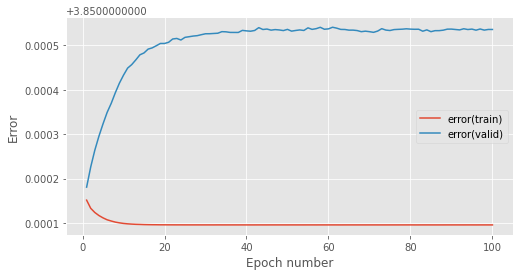

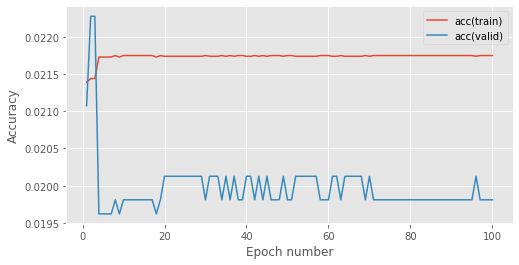

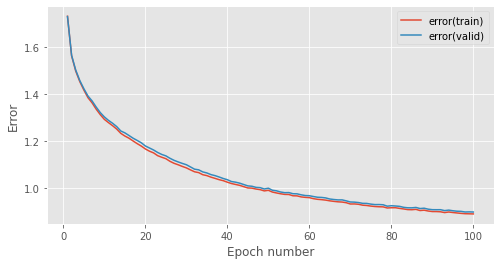

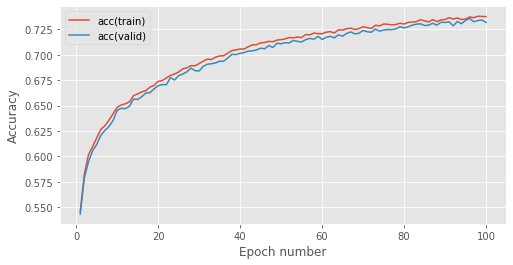

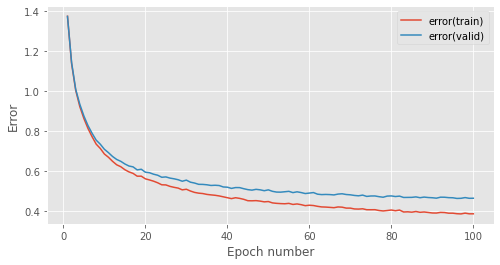

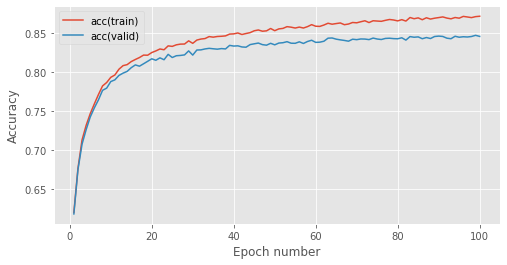

In [96]:
coeffs = [1e-1, 1e-3, 1e-4]
input_dim, output_dim, hidden_dim = 784, 47, 128

error = CrossEntropySoftmaxError()
# Use a Adam learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

for coeff in coeffs:
    print("L1Penalty coeff: " + str(coeff))
    weights_penalty = L1Penalty(coeff)
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty=weights_penalty), # first hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=weights_penalty), # second hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=weights_penalty), # third hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty=weights_penalty) # output layer
    ])
    # Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    
    record_all(stats, keys, hidden_dim, fig_1, fig_2, "L1/L1-coeff-" + str(coeff))

#### L2Penalty

L2Penalty coeff: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 1.2s to complete
    error(train)=2.98e+00, acc(train)=4.48e-01, error(valid)=2.98e+00, acc(valid)=4.50e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 1.2s to complete
    error(train)=2.90e+00, acc(train)=4.48e-01, error(valid)=2.91e+00, acc(valid)=4.46e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 1.2s to complete
    error(train)=2.90e+00, acc(train)=4.16e-01, error(valid)=2.91e+00, acc(valid)=4.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 1.2s to complete
    error(train)=2.91e+00, acc(train)=4.19e-01, error(valid)=2.91e+00, acc(valid)=4.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 1.2s to complete
    error(train)=2.90e+00, acc(train)=4.02e-01, error(valid)=2.90e+00, acc(valid)=3.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 1.2s to complete
    error(train)=2.90e+00, acc(train)=3.95e-01, error(valid)=2.90e+00, acc(valid)=3.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 1.2s to complete
    error(train)=2.90e+00, acc(train)=3.98e-01, error(valid)=2.90e+00, acc(valid)=3.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 1.2s to complete
    error(train)=2.89e+00, acc(train)=3.92e-01, error(valid)=2.89e+00, acc(valid)=3.89e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 1.2s to complete
    error(train)=2.88e+00, acc(train)=3.95e-01, error(valid)=2.88e+00, acc(valid)=3.90e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 1.2s to complete
    error(train)=2.87e+00, acc(train)=3.83e-01, error(valid)=2.88e+00, acc(valid)=3.79e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 1.3s to complete
    error(train)=2.87e+00, acc(train)=3.99e-01, error(valid)=2.87e+00, acc(valid)=3.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 1.2s to complete
    error(train)=2.87e+00, acc(train)=4.02e-01, error(valid)=2.87e+00, acc(valid)=3.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 1.2s to complete
    error(train)=2.86e+00, acc(train)=3.81e-01, error(valid)=2.86e+00, acc(valid)=3.76e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 1.2s to complete
    error(train)=2.86e+00, acc(train)=3.96e-01, error(valid)=2.86e+00, acc(valid)=3.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 1.6s to complete
    error(train)=2.85e+00, acc(train)=3.99e-01, error(valid)=2.86e+00, acc(valid)=3.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 2.1s to complete
    error(train)=2.85e+00, acc(train)=3.94e-01, error(valid)=2.85e+00, acc(valid)=3.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 2.5s to complete
    error(train)=2.85e+00, acc(train)=3.89e-01, error(valid)=2.85e+00, acc(valid)=3.86e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 2.8s to complete
    error(train)=2.84e+00, acc(train)=3.96e-01, error(valid)=2.84e+00, acc(valid)=3.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 2.5s to complete
    error(train)=2.84e+00, acc(train)=3.99e-01, error(valid)=2.84e+00, acc(valid)=3.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 1.9s to complete
    error(train)=2.83e+00, acc(train)=3.85e-01, error(valid)=2.84e+00, acc(valid)=3.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 1.3s to complete
    error(train)=2.84e+00, acc(train)=4.03e-01, error(valid)=2.84e+00, acc(valid)=3.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 1.3s to complete
    error(train)=2.83e+00, acc(train)=4.00e-01, error(valid)=2.83e+00, acc(valid)=3.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 1.3s to complete
    error(train)=2.83e+00, acc(train)=3.97e-01, error(valid)=2.83e+00, acc(valid)=3.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 1.3s to complete
    error(train)=2.83e+00, acc(train)=4.03e-01, error(valid)=2.83e+00, acc(valid)=4.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 1.3s to complete
    error(train)=2.83e+00, acc(train)=3.98e-01, error(valid)=2.83e+00, acc(valid)=3.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 1.3s to complete
    error(train)=2.82e+00, acc(train)=4.04e-01, error(valid)=2.82e+00, acc(valid)=4.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 1.3s to complete
    error(train)=2.82e+00, acc(train)=3.96e-01, error(valid)=2.82e+00, acc(valid)=3.92e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 1.3s to complete
    error(train)=2.82e+00, acc(train)=3.94e-01, error(valid)=2.82e+00, acc(valid)=3.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 1.3s to complete
    error(train)=2.82e+00, acc(train)=3.94e-01, error(valid)=2.82e+00, acc(valid)=3.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 1.3s to complete
    error(train)=2.82e+00, acc(train)=4.06e-01, error(valid)=2.82e+00, acc(valid)=4.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 1.4s to complete
    error(train)=2.81e+00, acc(train)=4.03e-01, error(valid)=2.81e+00, acc(valid)=4.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 1.4s to complete
    error(train)=2.81e+00, acc(train)=4.05e-01, error(valid)=2.82e+00, acc(valid)=4.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 1.3s to complete
    error(train)=2.81e+00, acc(train)=3.93e-01, error(valid)=2.81e+00, acc(valid)=3.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 1.3s to complete
    error(train)=2.81e+00, acc(train)=3.91e-01, error(valid)=2.81e+00, acc(valid)=3.86e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 1.3s to complete
    error(train)=2.81e+00, acc(train)=4.04e-01, error(valid)=2.81e+00, acc(valid)=4.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 1.3s to complete
    error(train)=2.81e+00, acc(train)=4.03e-01, error(valid)=2.81e+00, acc(valid)=4.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 1.3s to complete
    error(train)=2.81e+00, acc(train)=4.02e-01, error(valid)=2.81e+00, acc(valid)=4.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 1.3s to complete
    error(train)=2.81e+00, acc(train)=3.99e-01, error(valid)=2.81e+00, acc(valid)=4.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 1.3s to complete
    error(train)=2.81e+00, acc(train)=4.03e-01, error(valid)=2.81e+00, acc(valid)=4.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 1.3s to complete
    error(train)=2.80e+00, acc(train)=3.95e-01, error(valid)=2.81e+00, acc(valid)=3.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 1.3s to complete
    error(train)=2.81e+00, acc(train)=4.02e-01, error(valid)=2.81e+00, acc(valid)=4.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 1.3s to complete
    error(train)=2.81e+00, acc(train)=4.00e-01, error(valid)=2.81e+00, acc(valid)=3.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 1.3s to complete
    error(train)=2.80e+00, acc(train)=4.01e-01, error(valid)=2.81e+00, acc(valid)=4.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 1.4s to complete
    error(train)=2.80e+00, acc(train)=4.00e-01, error(valid)=2.80e+00, acc(valid)=4.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 1.3s to complete
    error(train)=2.80e+00, acc(train)=3.99e-01, error(valid)=2.80e+00, acc(valid)=3.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 1.3s to complete
    error(train)=2.80e+00, acc(train)=3.95e-01, error(valid)=2.80e+00, acc(valid)=3.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 1.3s to complete
    error(train)=2.80e+00, acc(train)=3.97e-01, error(valid)=2.80e+00, acc(valid)=3.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 1.3s to complete
    error(train)=2.80e+00, acc(train)=3.98e-01, error(valid)=2.80e+00, acc(valid)=3.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 1.3s to complete
    error(train)=2.80e+00, acc(train)=4.09e-01, error(valid)=2.80e+00, acc(valid)=4.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 1.3s to complete
    error(train)=2.80e+00, acc(train)=4.00e-01, error(valid)=2.80e+00, acc(valid)=4.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 1.3s to complete
    error(train)=2.80e+00, acc(train)=4.05e-01, error(valid)=2.80e+00, acc(valid)=4.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 1.3s to complete
    error(train)=2.80e+00, acc(train)=4.04e-01, error(valid)=2.80e+00, acc(valid)=4.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 1.4s to complete
    error(train)=2.80e+00, acc(train)=3.96e-01, error(valid)=2.80e+00, acc(valid)=3.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 1.3s to complete
    error(train)=2.80e+00, acc(train)=4.12e-01, error(valid)=2.80e+00, acc(valid)=4.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 1.3s to complete
    error(train)=2.80e+00, acc(train)=3.98e-01, error(valid)=2.80e+00, acc(valid)=3.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 1.3s to complete
    error(train)=2.80e+00, acc(train)=4.00e-01, error(valid)=2.80e+00, acc(valid)=3.97e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 1.3s to complete
    error(train)=2.80e+00, acc(train)=4.05e-01, error(valid)=2.80e+00, acc(valid)=4.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 1.4s to complete
    error(train)=2.80e+00, acc(train)=3.94e-01, error(valid)=2.80e+00, acc(valid)=3.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.07e-01, error(valid)=2.80e+00, acc(valid)=4.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.10e-01, error(valid)=2.79e+00, acc(valid)=4.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 1.3s to complete
    error(train)=2.80e+00, acc(train)=4.07e-01, error(valid)=2.80e+00, acc(valid)=4.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.04e-01, error(valid)=2.79e+00, acc(valid)=4.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 1.3s to complete
    error(train)=2.80e+00, acc(train)=4.05e-01, error(valid)=2.80e+00, acc(valid)=4.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 1.3s to complete
    error(train)=2.80e+00, acc(train)=4.04e-01, error(valid)=2.80e+00, acc(valid)=4.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 1.3s to complete
    error(train)=2.79e+00, acc(train)=3.92e-01, error(valid)=2.79e+00, acc(valid)=3.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 1.3s to complete
    error(train)=2.79e+00, acc(train)=3.94e-01, error(valid)=2.79e+00, acc(valid)=3.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 1.3s to complete
    error(train)=2.80e+00, acc(train)=4.02e-01, error(valid)=2.80e+00, acc(valid)=3.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.07e-01, error(valid)=2.79e+00, acc(valid)=4.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.02e-01, error(valid)=2.80e+00, acc(valid)=3.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.03e-01, error(valid)=2.79e+00, acc(valid)=4.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 1.3s to complete
    error(train)=2.79e+00, acc(train)=3.98e-01, error(valid)=2.79e+00, acc(valid)=3.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 1.3s to complete
    error(train)=2.79e+00, acc(train)=3.99e-01, error(valid)=2.79e+00, acc(valid)=3.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 1.4s to complete
    error(train)=2.79e+00, acc(train)=3.88e-01, error(valid)=2.79e+00, acc(valid)=3.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.08e-01, error(valid)=2.80e+00, acc(valid)=4.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.07e-01, error(valid)=2.79e+00, acc(valid)=4.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.03e-01, error(valid)=2.79e+00, acc(valid)=3.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.01e-01, error(valid)=2.79e+00, acc(valid)=4.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 1.3s to complete
    error(train)=2.79e+00, acc(train)=3.99e-01, error(valid)=2.79e+00, acc(valid)=3.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.05e-01, error(valid)=2.79e+00, acc(valid)=4.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 1.3s to complete
    error(train)=2.79e+00, acc(train)=3.82e-01, error(valid)=2.79e+00, acc(valid)=3.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 1.3s to complete
    error(train)=2.80e+00, acc(train)=3.99e-01, error(valid)=2.80e+00, acc(valid)=3.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.03e-01, error(valid)=2.79e+00, acc(valid)=4.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 1.3s to complete
    error(train)=2.79e+00, acc(train)=3.96e-01, error(valid)=2.79e+00, acc(valid)=3.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 1.4s to complete
    error(train)=2.79e+00, acc(train)=3.98e-01, error(valid)=2.79e+00, acc(valid)=3.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.05e-01, error(valid)=2.79e+00, acc(valid)=4.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 1.3s to complete
    error(train)=2.79e+00, acc(train)=3.93e-01, error(valid)=2.79e+00, acc(valid)=3.91e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 1.3s to complete
    error(train)=2.79e+00, acc(train)=3.96e-01, error(valid)=2.79e+00, acc(valid)=3.95e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 1.3s to complete
    error(train)=2.79e+00, acc(train)=3.90e-01, error(valid)=2.79e+00, acc(valid)=3.87e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 1.3s to complete
    error(train)=2.79e+00, acc(train)=3.97e-01, error(valid)=2.79e+00, acc(valid)=3.99e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 1.3s to complete
    error(train)=2.79e+00, acc(train)=3.99e-01, error(valid)=2.79e+00, acc(valid)=3.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.15e-01, error(valid)=2.79e+00, acc(valid)=4.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.05e-01, error(valid)=2.79e+00, acc(valid)=4.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 1.4s to complete
    error(train)=2.79e+00, acc(train)=4.03e-01, error(valid)=2.79e+00, acc(valid)=4.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.10e-01, error(valid)=2.79e+00, acc(valid)=4.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.00e-01, error(valid)=2.79e+00, acc(valid)=4.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 1.3s to complete
    error(train)=2.79e+00, acc(train)=3.99e-01, error(valid)=2.79e+00, acc(valid)=3.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.09e-01, error(valid)=2.79e+00, acc(valid)=4.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 1.3s to complete
    error(train)=2.79e+00, acc(train)=3.89e-01, error(valid)=2.79e+00, acc(valid)=3.89e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 1.3s to complete
    error(train)=2.79e+00, acc(train)=4.11e-01, error(valid)=2.79e+00, acc(valid)=4.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 1.3s to complete
    error(train)=2.79e+00, acc(train)=3.98e-01, error(valid)=2.79e+00, acc(valid)=3.97e-01


Finished model accuracy
Train acc: 0.3976300000000003
Val acc: 0.39689873417721505

Finished model error
Train err: 2.789540478177018
Val err: 2.790091716810068

L2Penalty coeff: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 1.2s to complete
    error(train)=1.61e+00, acc(train)=5.83e-01, error(valid)=1.61e+00, acc(valid)=5.86e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 1.2s to complete
    error(train)=1.32e+00, acc(train)=6.41e-01, error(valid)=1.32e+00, acc(valid)=6.42e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 1.2s to complete
    error(train)=1.22e+00, acc(train)=6.66e-01, error(valid)=1.22e+00, acc(valid)=6.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 1.2s to complete
    error(train)=1.15e+00, acc(train)=6.83e-01, error(valid)=1.16e+00, acc(valid)=6.81e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 1.2s to complete
    error(train)=1.10e+00, acc(train)=6.96e-01, error(valid)=1.11e+00, acc(valid)=6.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 1.2s to complete
    error(train)=1.06e+00, acc(train)=7.07e-01, error(valid)=1.07e+00, acc(valid)=7.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 1.2s to complete
    error(train)=1.02e+00, acc(train)=7.16e-01, error(valid)=1.03e+00, acc(valid)=7.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 1.2s to complete
    error(train)=9.86e-01, acc(train)=7.25e-01, error(valid)=1.00e+00, acc(valid)=7.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 1.2s to complete
    error(train)=9.56e-01, acc(train)=7.33e-01, error(valid)=9.72e-01, acc(valid)=7.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 1.2s to complete
    error(train)=9.28e-01, acc(train)=7.41e-01, error(valid)=9.45e-01, acc(valid)=7.36e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 1.2s to complete
    error(train)=9.04e-01, acc(train)=7.47e-01, error(valid)=9.22e-01, acc(valid)=7.43e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 1.2s to complete
    error(train)=8.81e-01, acc(train)=7.53e-01, error(valid)=9.00e-01, acc(valid)=7.48e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 1.2s to complete
    error(train)=8.60e-01, acc(train)=7.59e-01, error(valid)=8.80e-01, acc(valid)=7.53e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 1.6s to complete
    error(train)=8.41e-01, acc(train)=7.63e-01, error(valid)=8.62e-01, acc(valid)=7.57e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 2.1s to complete
    error(train)=8.23e-01, acc(train)=7.69e-01, error(valid)=8.45e-01, acc(valid)=7.62e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 2.5s to complete
    error(train)=8.06e-01, acc(train)=7.71e-01, error(valid)=8.29e-01, acc(valid)=7.66e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 3.0s to complete
    error(train)=7.92e-01, acc(train)=7.77e-01, error(valid)=8.15e-01, acc(valid)=7.68e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 3.5s to complete
    error(train)=7.78e-01, acc(train)=7.80e-01, error(valid)=8.03e-01, acc(valid)=7.73e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 3.7s to complete
    error(train)=7.65e-01, acc(train)=7.83e-01, error(valid)=7.91e-01, acc(valid)=7.76e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 3.6s to complete
    error(train)=7.53e-01, acc(train)=7.85e-01, error(valid)=7.79e-01, acc(valid)=7.78e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 3.6s to complete
    error(train)=7.43e-01, acc(train)=7.88e-01, error(valid)=7.70e-01, acc(valid)=7.80e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 3.6s to complete
    error(train)=7.32e-01, acc(train)=7.91e-01, error(valid)=7.59e-01, acc(valid)=7.83e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 3.6s to complete
    error(train)=7.21e-01, acc(train)=7.95e-01, error(valid)=7.50e-01, acc(valid)=7.86e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 3.6s to complete
    error(train)=7.14e-01, acc(train)=7.96e-01, error(valid)=7.44e-01, acc(valid)=7.84e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 3.6s to complete
    error(train)=7.05e-01, acc(train)=7.98e-01, error(valid)=7.35e-01, acc(valid)=7.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 3.7s to complete
    error(train)=6.97e-01, acc(train)=8.00e-01, error(valid)=7.28e-01, acc(valid)=7.88e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 3.6s to complete
    error(train)=6.90e-01, acc(train)=8.02e-01, error(valid)=7.21e-01, acc(valid)=7.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 3.6s to complete
    error(train)=6.83e-01, acc(train)=8.04e-01, error(valid)=7.15e-01, acc(valid)=7.93e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 3.7s to complete
    error(train)=6.77e-01, acc(train)=8.04e-01, error(valid)=7.10e-01, acc(valid)=7.94e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 3.6s to complete
    error(train)=6.71e-01, acc(train)=8.06e-01, error(valid)=7.04e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 3.6s to complete
    error(train)=6.64e-01, acc(train)=8.09e-01, error(valid)=6.98e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 3.7s to complete
    error(train)=6.60e-01, acc(train)=8.10e-01, error(valid)=6.93e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 3.6s to complete
    error(train)=6.54e-01, acc(train)=8.11e-01, error(valid)=6.89e-01, acc(valid)=7.98e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 3.6s to complete
    error(train)=6.50e-01, acc(train)=8.12e-01, error(valid)=6.85e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 3.6s to complete
    error(train)=6.45e-01, acc(train)=8.13e-01, error(valid)=6.80e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 3.7s to complete
    error(train)=6.40e-01, acc(train)=8.15e-01, error(valid)=6.76e-01, acc(valid)=8.02e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 3.6s to complete
    error(train)=6.35e-01, acc(train)=8.16e-01, error(valid)=6.71e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 3.6s to complete
    error(train)=6.31e-01, acc(train)=8.17e-01, error(valid)=6.66e-01, acc(valid)=8.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 3.6s to complete
    error(train)=6.28e-01, acc(train)=8.17e-01, error(valid)=6.65e-01, acc(valid)=8.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 3.6s to complete
    error(train)=6.23e-01, acc(train)=8.19e-01, error(valid)=6.60e-01, acc(valid)=8.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 3.6s to complete
    error(train)=6.21e-01, acc(train)=8.19e-01, error(valid)=6.57e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 3.6s to complete
    error(train)=6.18e-01, acc(train)=8.20e-01, error(valid)=6.55e-01, acc(valid)=8.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 3.6s to complete
    error(train)=6.14e-01, acc(train)=8.21e-01, error(valid)=6.51e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 3.6s to complete
    error(train)=6.10e-01, acc(train)=8.22e-01, error(valid)=6.48e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 3.6s to complete
    error(train)=6.09e-01, acc(train)=8.22e-01, error(valid)=6.47e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 3.6s to complete
    error(train)=6.06e-01, acc(train)=8.22e-01, error(valid)=6.44e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 3.6s to complete
    error(train)=6.02e-01, acc(train)=8.24e-01, error(valid)=6.40e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 3.6s to complete
    error(train)=5.99e-01, acc(train)=8.25e-01, error(valid)=6.38e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 3.7s to complete
    error(train)=5.97e-01, acc(train)=8.26e-01, error(valid)=6.35e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 3.6s to complete
    error(train)=5.95e-01, acc(train)=8.26e-01, error(valid)=6.33e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 3.7s to complete
    error(train)=5.91e-01, acc(train)=8.27e-01, error(valid)=6.29e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 3.6s to complete
    error(train)=5.88e-01, acc(train)=8.27e-01, error(valid)=6.27e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 3.6s to complete
    error(train)=5.86e-01, acc(train)=8.27e-01, error(valid)=6.26e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 3.6s to complete
    error(train)=5.85e-01, acc(train)=8.29e-01, error(valid)=6.24e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 3.6s to complete
    error(train)=5.82e-01, acc(train)=8.30e-01, error(valid)=6.22e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 3.6s to complete
    error(train)=5.81e-01, acc(train)=8.30e-01, error(valid)=6.20e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 3.6s to complete
    error(train)=5.78e-01, acc(train)=8.30e-01, error(valid)=6.18e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 3.6s to complete
    error(train)=5.77e-01, acc(train)=8.30e-01, error(valid)=6.16e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 3.6s to complete
    error(train)=5.75e-01, acc(train)=8.31e-01, error(valid)=6.14e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 3.6s to complete
    error(train)=5.73e-01, acc(train)=8.31e-01, error(valid)=6.12e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 3.5s to complete
    error(train)=5.72e-01, acc(train)=8.31e-01, error(valid)=6.12e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 3.5s to complete
    error(train)=5.70e-01, acc(train)=8.32e-01, error(valid)=6.10e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 3.6s to complete
    error(train)=5.67e-01, acc(train)=8.33e-01, error(valid)=6.08e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 3.5s to complete
    error(train)=5.65e-01, acc(train)=8.34e-01, error(valid)=6.05e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 3.5s to complete
    error(train)=5.64e-01, acc(train)=8.33e-01, error(valid)=6.05e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 3.6s to complete
    error(train)=5.64e-01, acc(train)=8.33e-01, error(valid)=6.03e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 3.5s to complete
    error(train)=5.61e-01, acc(train)=8.35e-01, error(valid)=6.00e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 3.6s to complete
    error(train)=5.61e-01, acc(train)=8.34e-01, error(valid)=6.02e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 3.6s to complete
    error(train)=5.58e-01, acc(train)=8.36e-01, error(valid)=5.99e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 3.6s to complete
    error(train)=5.57e-01, acc(train)=8.36e-01, error(valid)=5.98e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 3.6s to complete
    error(train)=5.56e-01, acc(train)=8.36e-01, error(valid)=5.98e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 3.6s to complete
    error(train)=5.55e-01, acc(train)=8.36e-01, error(valid)=5.97e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 3.6s to complete
    error(train)=5.54e-01, acc(train)=8.36e-01, error(valid)=5.95e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 3.6s to complete
    error(train)=5.51e-01, acc(train)=8.37e-01, error(valid)=5.93e-01, acc(valid)=8.20e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 3.6s to complete
    error(train)=5.51e-01, acc(train)=8.37e-01, error(valid)=5.93e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 3.6s to complete
    error(train)=5.49e-01, acc(train)=8.38e-01, error(valid)=5.91e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 3.6s to complete
    error(train)=5.49e-01, acc(train)=8.38e-01, error(valid)=5.91e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 3.6s to complete
    error(train)=5.47e-01, acc(train)=8.38e-01, error(valid)=5.89e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 3.6s to complete
    error(train)=5.47e-01, acc(train)=8.37e-01, error(valid)=5.89e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 3.5s to complete
    error(train)=5.46e-01, acc(train)=8.38e-01, error(valid)=5.88e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 3.6s to complete
    error(train)=5.44e-01, acc(train)=8.39e-01, error(valid)=5.86e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 3.6s to complete
    error(train)=5.43e-01, acc(train)=8.39e-01, error(valid)=5.86e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 3.5s to complete
    error(train)=5.42e-01, acc(train)=8.39e-01, error(valid)=5.85e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 3.6s to complete
    error(train)=5.40e-01, acc(train)=8.40e-01, error(valid)=5.83e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 3.5s to complete
    error(train)=5.40e-01, acc(train)=8.40e-01, error(valid)=5.81e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 3.6s to complete
    error(train)=5.39e-01, acc(train)=8.40e-01, error(valid)=5.82e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 3.5s to complete
    error(train)=5.39e-01, acc(train)=8.40e-01, error(valid)=5.82e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 3.5s to complete
    error(train)=5.37e-01, acc(train)=8.40e-01, error(valid)=5.80e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 3.5s to complete
    error(train)=5.36e-01, acc(train)=8.41e-01, error(valid)=5.79e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 3.6s to complete
    error(train)=5.36e-01, acc(train)=8.41e-01, error(valid)=5.78e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 3.6s to complete
    error(train)=5.34e-01, acc(train)=8.42e-01, error(valid)=5.76e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 3.6s to complete
    error(train)=5.34e-01, acc(train)=8.42e-01, error(valid)=5.77e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 3.6s to complete
    error(train)=5.32e-01, acc(train)=8.42e-01, error(valid)=5.75e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 3.6s to complete
    error(train)=5.32e-01, acc(train)=8.43e-01, error(valid)=5.76e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 3.6s to complete
    error(train)=5.32e-01, acc(train)=8.42e-01, error(valid)=5.75e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 3.6s to complete
    error(train)=5.30e-01, acc(train)=8.43e-01, error(valid)=5.74e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 3.6s to complete
    error(train)=5.30e-01, acc(train)=8.43e-01, error(valid)=5.74e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 3.6s to complete
    error(train)=5.31e-01, acc(train)=8.42e-01, error(valid)=5.74e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 3.6s to complete
    error(train)=5.29e-01, acc(train)=8.43e-01, error(valid)=5.71e-01, acc(valid)=8.27e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 3.6s to complete
    error(train)=5.27e-01, acc(train)=8.43e-01, error(valid)=5.70e-01, acc(valid)=8.27e-01


Finished model accuracy
Train acc: 0.8429200000000013
Val acc: 0.8268987341772153

Finished model error
Train err: 0.5269819042041349
Val err: 0.5702571639432491



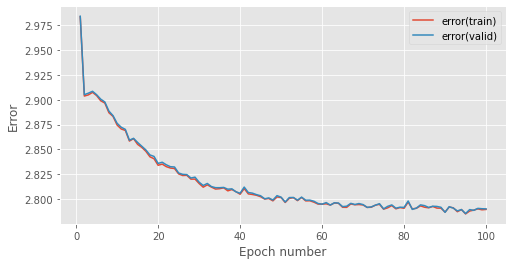

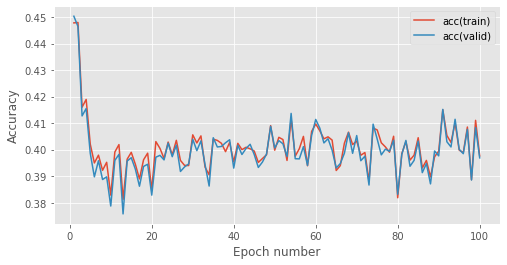

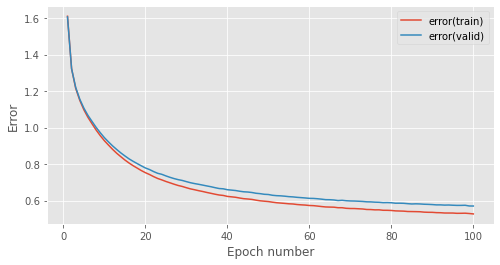

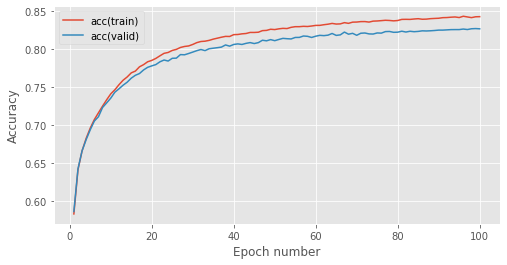

In [98]:
coeffs = [1e-1, 1e-3, 1e-4]
input_dim, output_dim, hidden_dim = 784, 47, 128

error = CrossEntropySoftmaxError()
# Use a Adam learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

for coeff in coeffs:
    print("L2Penalty coeff: " + str(coeff))
    weights_penalty = L2Penalty(coeff)
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty=weights_penalty), # first hidden layer
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty=weights_penalty) # output layer
    ])
    # Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    
    record_all(stats, keys, hidden_dim, fig_1, fig_2, "L2/L2-coeff-" + str(coeff))

## Plot models in single figure

In [105]:
def plot_all_models(d_name, model_names, name, labels):
    
    depth_dir = os.getcwd() + "/results/" + d_name + "/"
    colours = ["red", "blue", "purple", "grey", "yellow", "green"]
    dataset = ["train", "valid"]
    lsty = ["solid","dashed"]

    #ERROR
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)

    #ACCURACY
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    
    for j in range(2):
        for i in range(len(model_names)):
            stats = np.load(depth_dir + model_names[i] + "-stats.npy")

            k = 1 + j*2
            plt_label = name + " " + labels[i] +  "(" + dataset[j] + ")"
            c = colours[j*3 + i]
            
            ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                      stats[1:, k], label=plt_label, color=c, linestyle=lsty[j])

            k = k-1
            ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                      stats[1:, k], label=plt_label, color=c, linestyle=lsty[j])

    lgd = ax_1.legend(bbox_to_anchor=(1, 1))
    ax_1.set_xlabel('Epoch number')
    ax_1.set_ylabel('Accuracy')

    ax_2.legend(bbox_to_anchor=(1, 1))
    ax_2.set_xlabel('Epoch number')
    ax_2.set_ylabel('Error')
    
    fig_1.savefig(os.getcwd() + "/results/" + d_name + "/" + name + "-fig1.svg", bbox_extra_artists=(lgd,), bbox_inches="tight")
    fig_2.savefig(os.getcwd() + "/results/" + d_name + "/" + name + "-fig2.svg", bbox_extra_artists=(lgd,), bbox_inches="tight")
    fig_1.savefig(os.getcwd() + "/results/" + d_name + "/" + name + "-fig1.png", bbox_extra_artists=(lgd,), bbox_inches="tight")
    fig_2.savefig(os.getcwd() + "/results/" + d_name + "/" + name + "-fig2.png", bbox_extra_artists=(lgd,), bbox_inches="tight")
    

### Figure 3: NN depth

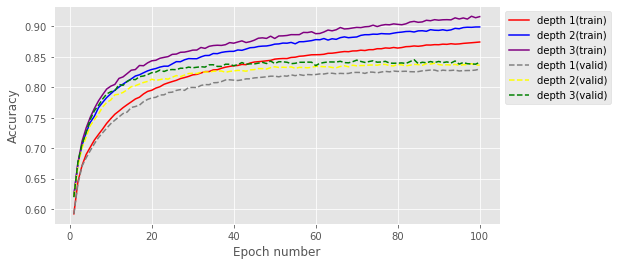

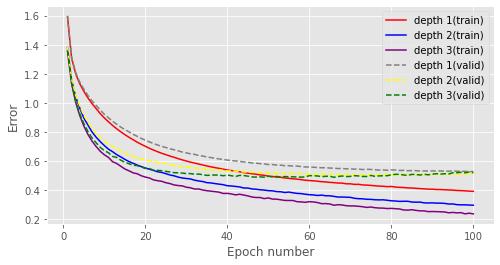

In [100]:
plot_all_models("wd", ["1layer-128units", "2layers-128units", "3layers-128units"], "depth", ["1", "2", "3"])

### Figure 2: NN width

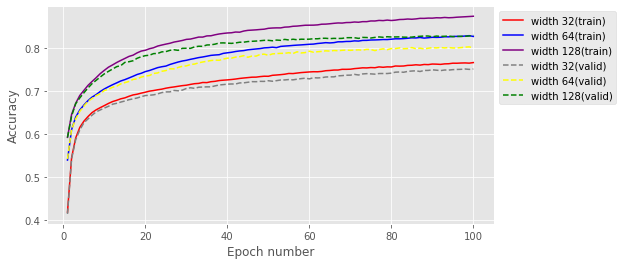

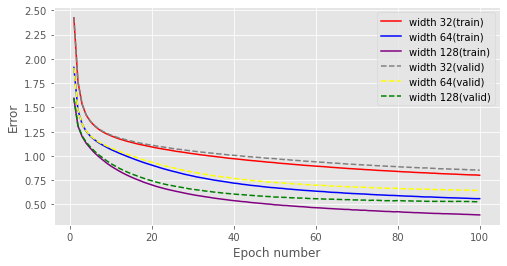

In [101]:
plot_all_models("wd", ["1layer-32units", "1layer-64units", "1layer-128units"], "width", ["32", "64", "128"])

### dropout

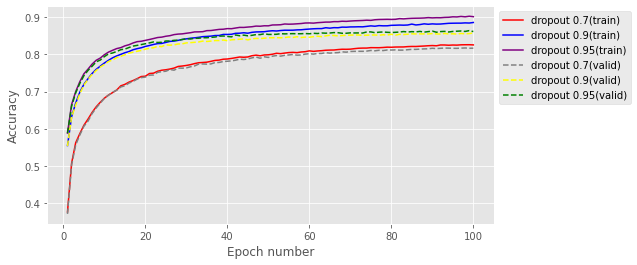

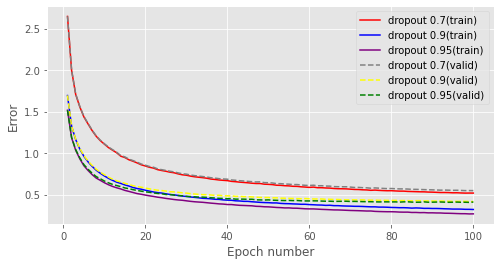

In [106]:
plot_all_models("dropout", ["dropout-prob-0.7", "dropout-prob-0.9", "dropout-prob-0.95"], "dropout", ["0.7", "0.9", "0.95"])

### L1

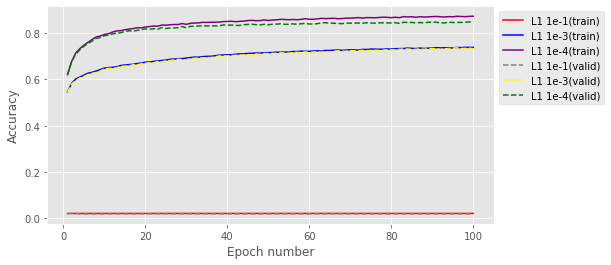

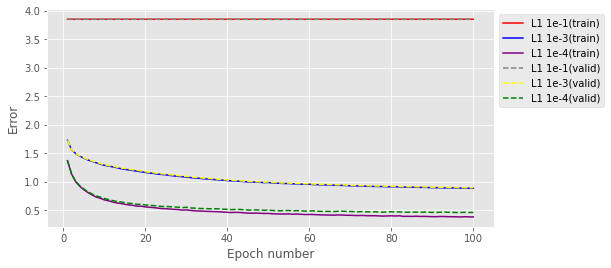

In [107]:
plot_all_models("L1", ["L1-coeff-0.1", "L1-coeff-0.001", "L1-coeff-0.0001"], "L1", ["1e-1", "1e-3", "1e-4"])

### L2

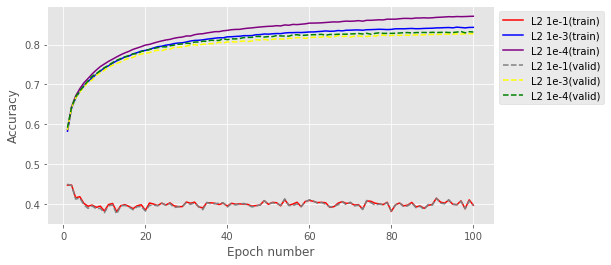

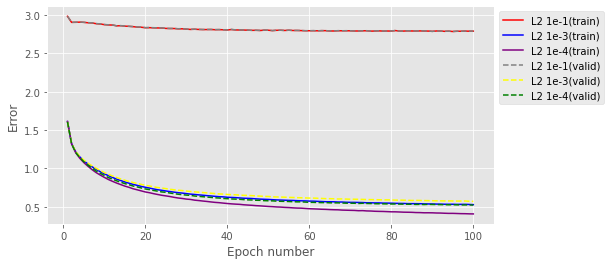

In [108]:
plot_all_models("L2", ["L2-coeff-0.1", "L2-coeff-0.001", "L2-coeff-0.0001"], "L2", ["1e-1", "1e-3", "1e-4"])

## Validation accuracy VS generalization gap

In [102]:
def val_acc_vs_gen_gap(d_name, f_names, f_suffix):
    dir_name = os.getcwd() + d_name 
    
    for f in f_names:
        stats = np.load(dir_name + f + f_suffix)
        val_acc = stats[:, 3][100]
        val_err = stats[:,2][100]
        train_err = stats[:, 0][100]
        gen_gap = val_err - train_err

        print(f)
        print("Validation accuracy: {:.4f}%".format(val_acc))
        print("Generalization gap: {:.3f}".format(gen_gap))
        print()

### Table 1: validation accuracy vs. generalization gap for varying units

In [103]:
val_acc_vs_gen_gap("/results/wd/1layer-", ["32", "64", "128"], "units-stats.npy")

32
Validation accuracy: 0.7515%
Generalization gap: 0.052

64
Validation accuracy: 0.8009%
Generalization gap: 0.086

128
Validation accuracy: 0.8301%
Generalization gap: 0.136



### Table 2: validation accuracy vs. generalization gap for varying depths

keys = [train_err, train_acc, val_err, val_acc]

In [89]:
val_acc_vs_gen_gap("/results/wd/", ["1layer", "2layers", "3layers"], "-128units-stats.npy")

1layer
Validation accuracy: 0.8301%
Generalization gap: 0.136

2layers
Validation accuracy: 0.8364%
Generalization gap: 0.215

3layers
Validation accuracy: 0.8411%
Generalization gap: 0.283



### Table 3: varying hyperparameters

#### dropout

In [49]:
val_acc_vs_gen_gap("/results/q3/dropout/dropout-prob-", ["0.7", "0.9", "0.95"], "-stats.npy")

0.7
Validation accuracy: 0.8411%
Generalization gap: 0.079

0.9
Validation accuracy: 0.8445%
Generalization gap: 0.217

0.95
Validation accuracy: 0.8399%
Generalization gap: 0.315



#### L1

In [50]:
val_acc_vs_gen_gap("/results/q3/L1/L1-coeff-", ["0.1", "0.001", "0.0001"], "-stats.npy")

0.1
Validation accuracy: 0.0198%
Generalization gap: 0.000

0.001
Validation accuracy: 0.7001%
Generalization gap: 0.009

0.0001
Validation accuracy: 0.8422%
Generalization gap: 0.061



#### L2

In [51]:
val_acc_vs_gen_gap("/results/q3/L2/L2-coeff-", ["0.1", "0.001", "0.0001"], "-stats.npy")

0.1
Validation accuracy: 0.3877%
Generalization gap: 0.000

0.001
Validation accuracy: 0.8347%
Generalization gap: 0.040

0.0001
Validation accuracy: 0.8346%
Generalization gap: 0.242

